In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
from imgaug import augmenters as iaa

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.2 MB/s 


In [ ]:
import pydicom as dcm

In [ ]:

from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@73bd80060ea1-af0c760efa534e2bbd15e39d74a60ed5: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@73bd80060ea1-af0c760efa534e2bbd15e39d74a60ed5: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@73bd80060ea1-af0c760efa534e2bbd15e39d74a60ed5: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@73bd80060ea1-af0c760efa534e2bbd15e39d74a60ed5: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 239
root@73bd80060ea1-af0c760efa534e2bbd15e39d74a60ed5: cat /tmp/tmpbwdoholk/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:1

In [ ]:
os.chdir('./drive/MyDrive/capston/')

전처리


*   https://github.com/tuvovan/Unet-with-EfficientnetB7-Backbone/blob/master/Body%20Morphometry.ipynb


모델


*   https://github.com/IanTaehoonYoo/semantic-segmentation-pytorch




In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [ ]:
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(image_medical, window_widht, window_level):
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)
#     image_window_norm = image_window

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    #print(image_window_norm.shape)
    return image_ths

def to_binary(img, lower, upper):
    return (lower <= img) & (img <= upper)

In [ ]:
def mask_binarization(mask, threshold=None):
    if threshold is None:
        threshold = 0.5

    if isinstance(mask, np.ndarray):
        mask_binarized = (mask > threshold).astype(np.uint8)
    
    elif isinstance(mask, torch.Tensor):
        zeros = torch.zeros_like(mask)
        ones = torch.ones_like(mask)
        
        mask_binarized = torch.where(mask > threshold, ones, zeros)
    
    return mask_binarized

def augment_imgs_and_masks(imgs, masks, rot_factor, scale_factor, trans_factor, flip):
    rot_factor = uniform(-rot_factor, rot_factor)
    ran_alp = uniform(10,100)
    scale_factor = uniform(1-scale_factor, 1+scale_factor)
    trans_factor = [int(imgs.shape[1]*uniform(-trans_factor, trans_factor)),
                    int(imgs.shape[2]*uniform(-trans_factor, trans_factor))]

    seq = iaa.Sequential([
            iaa.Affine(
                translate_px={"x": trans_factor[0], "y": trans_factor[1]},
                scale=(scale_factor, scale_factor),
                rotate=rot_factor
            ),
            #iaa.ElasticTransformation(alpha=ran_alp,sigma=5.0)
        
        ])

    seq_det = seq.to_deterministic()

    imgs = seq_det.augment_images(imgs)
    masks = seq_det.augment_images(masks)

    if flip and uniform(0, 1) > 0.5:
        imgs = np.flip(imgs, 2).copy()
        masks = np.flip(masks, 2).copy()
    
    masks = mask_binarization(masks).astype(np.float32)
    return imgs, masks

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir,augmentation=False):
        super().__init__()
        
        self.augmentation = augmentation
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        # Read an image with OpenCV
        x_img = dcm.read_file(x_img)
        y_img =  imread(y_img)

        x_img=read_dicom(x_img,400,0)
        x_img=np.transpose(x_img,(2,0,1))
        x_img=x_img.astype(np.float32)

        y_img = resize(y_img, (512, 512))*255
        color_im = np.zeros([512, 512, 2])
        for i in range(1,3):
            encode_ = to_binary(y_img, i*1.0, i*1.0)
            color_im[:, :, i-1] = encode_
        color_im = np.transpose(color_im,(2,0,1))
        # Data Augmentation
        if self.augmentation:
            img, mask = augment_imgs_and_masks(x_img, color_im, rot_factor, scale_factor, trans_factor, flip)
        
        return x_img, color_im,y_img


In [ ]:
data_path_folder=sorted(os.listdir("./data/DICOM/")) 
label_path_folder=sorted(os.listdir("./data/Label/"))

In [ ]:
#case 겹치지 않게 train,val 나누기
import glob
test_input_files=[]
test_label_files=[]
val_input_files=[]
val_label_files=[]
train_input_files=[]
train_label_files=[]

for i in range(100):
  if i<70:
    train_input_files+=sorted(glob.glob("./data/DICOM/"+data_path_folder[i]+"/*.dcm",recursive=True))
    train_label_files+=sorted(glob.glob("./data/Label/"+label_path_folder[i]+"/*.png",recursive=True))
  elif i<90:
    val_input_files+=sorted(glob.glob("./data/DICOM/"+data_path_folder[i]+"/*.dcm",recursive=True))
    val_label_files+=sorted(glob.glob("./data/Label/"+label_path_folder[i]+"/*.png",recursive=True))
  else:  
    test_input_files+=sorted(glob.glob("./data/DICOM/"+data_path_folder[i]+"/*.dcm",recursive=True))
    test_label_files+=sorted(glob.glob("./data/Label/"+label_path_folder[i]+"/*.png",recursive=True)) 

In [ ]:
train_input_files = np.array(train_input_files)
train_label_files = np.array(train_label_files)

val_input_files = np.array(val_input_files)
val_label_files = np.array(val_label_files)

test_input_files = np.array(test_input_files)
test_label_files = np.array(test_label_files)

In [ ]:
len(test_input_files)

640

In [ ]:
train_dataset = MyDataset(train_input_files,train_label_files)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2,shuffle=True)
val_dataset = MyDataset(val_input_files,val_label_files)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2,shuffle=True)
test_dataset = MyDataset(val_input_files,val_label_files)
test_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1,shuffle=False)

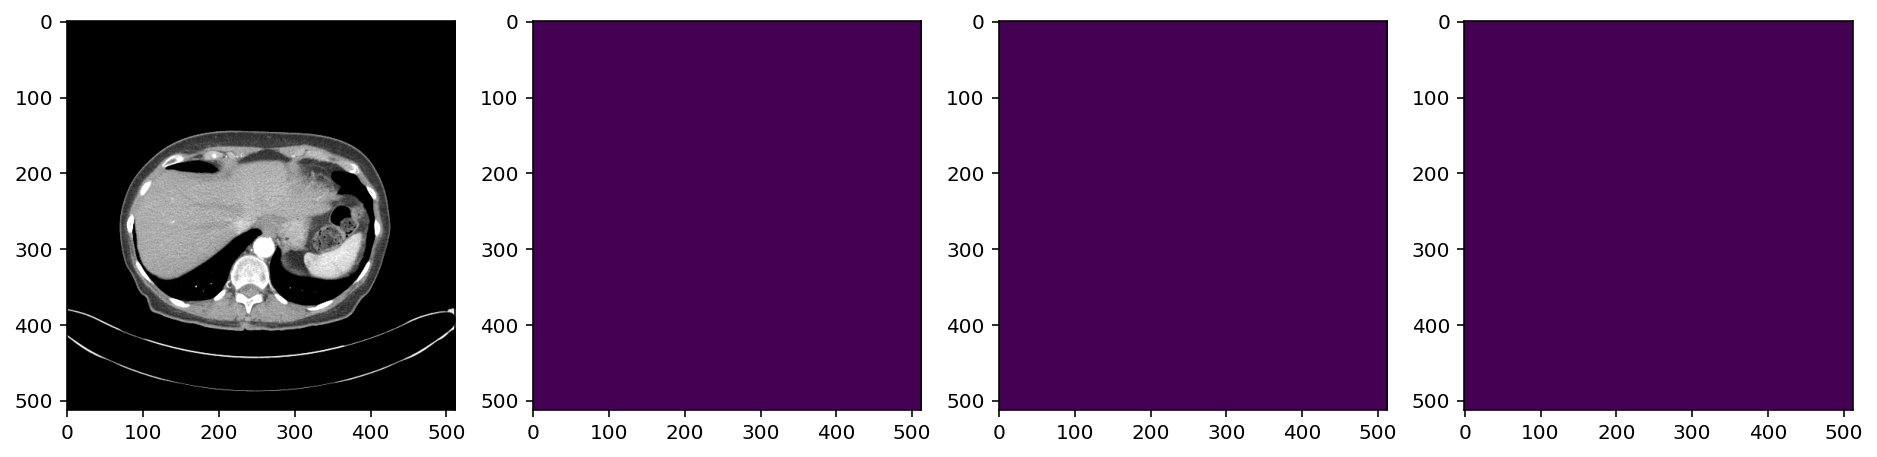

In [ ]:
##input과 label이 맞나 확인
images,labels,a = next(iter(train_loader))
# print(images.shape)
# print(labels.shape)
plt.figure(figsize=(16,18))
plt.subplot(1,4,1)
plt.imshow(images[0][0],cmap='gray')
plt.subplot(1,4,2)
plt.imshow(labels[0][0])
plt.subplot(1,4,3)
plt.imshow(labels[0][1])
plt.subplot(1,4,4)
plt.imshow(a[0])
plt.show()

In [ ]:
def compute_per_channel_dice(input, target, epsilon=1e-5,ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        if isinstance(weight, list):
            weight = torch.Tensor(weight)
            
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits

        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False).to(input.device)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index, weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [ ]:
pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-8hn_lox6
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-8hn_lox6
     |████████████████████████████████| 58 kB 3.1 MB/s 
     |████████████████████████████████| 376 kB 10.9 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.1-py3-none-any.whl size=88599 sha256=12cf75fc2b370611a172044abbac72ae2420c6314bb4417fe4935b9fec0aff47
  Stored in directory: /tmp/pip-ephem-wheel-cache-m1u5hljn/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=0db585a2bc2e47980546d87a9622ba55d22d7a07870c7e93097f5c6eca19f02f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

In [ ]:
import segmentation_models_pytorch as smp
model = smp.FPN(  #DeepLabV3
    encoder_name="resnext101_32x8d",# choose encoder, e.g. mobilenet_v2 or efficientnet-b7 resnext101_32x8d,timm-res2net101_26w_4s     # use `imagenet` pre-trained weights for encoder initialization 
    encoder_weights="imagenet",
    in_channels=3,
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import confusion_matrix  

def compute_iou(y_pred, y_true):
    y_pred=y_pred.detach().cpu()
    y_true=y_true.detach().cpu()
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)
    

In [ ]:
sum([param.nelement() for param in model.parameters()])

89350466

In [ ]:
import torch.optim as optim
criterion =  DiceLoss(sigmoid_normalization=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6)

model.load_state_dict(torch.load('pretrainModel_remove255.pt'))

<All keys matched successfully>

  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


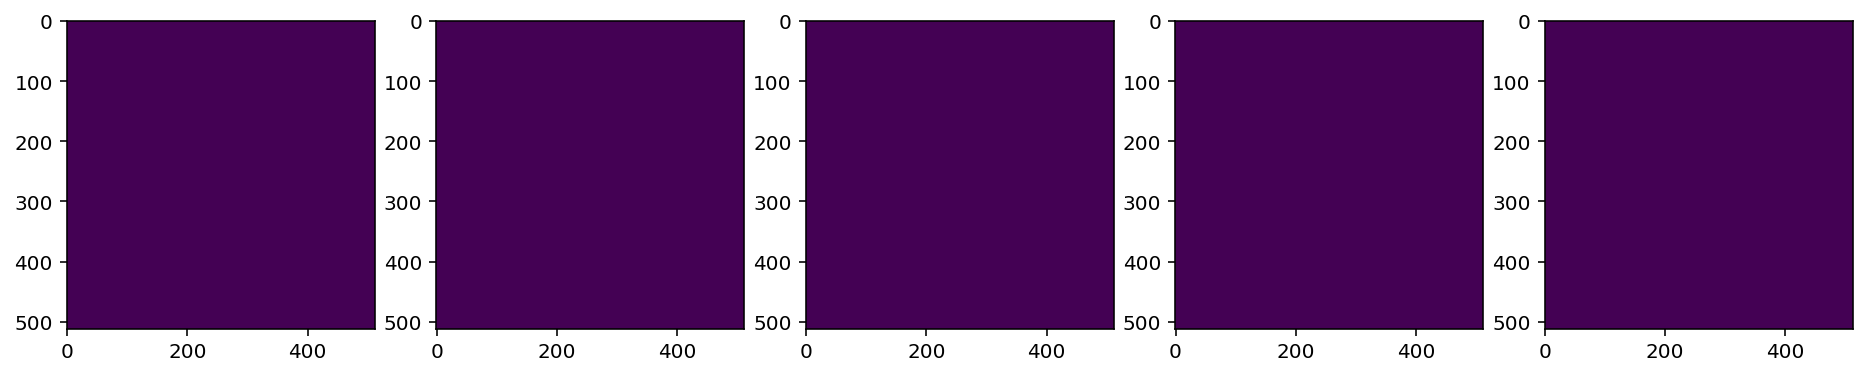

0.9334257143753063


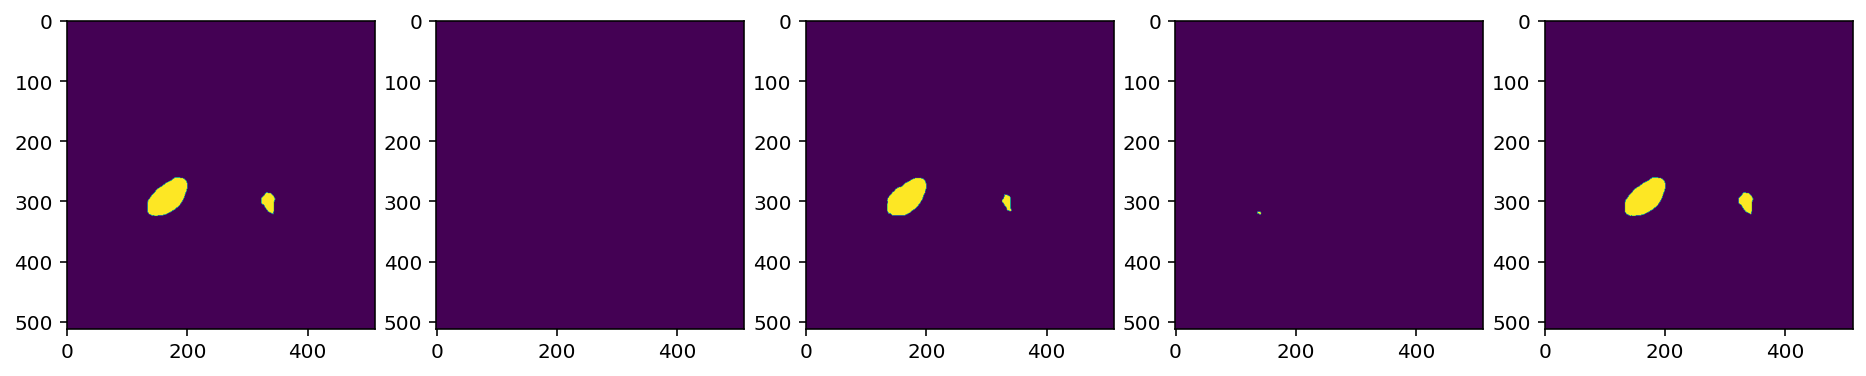

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 0.415923 	Validation Loss: 0.514580


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9872982974366478


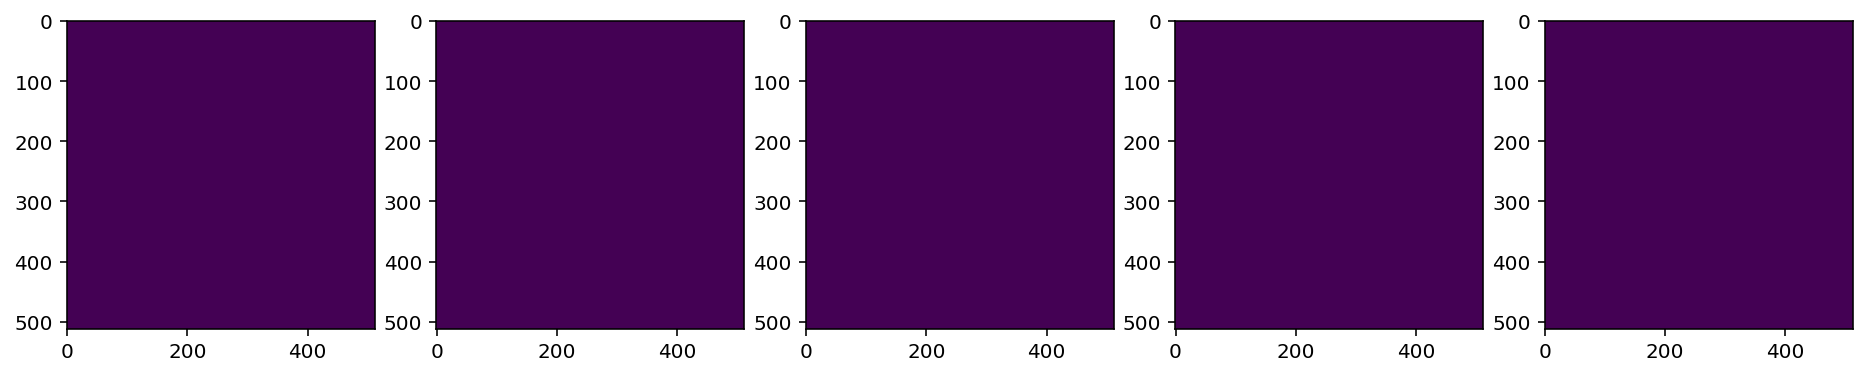

0.964297463322139


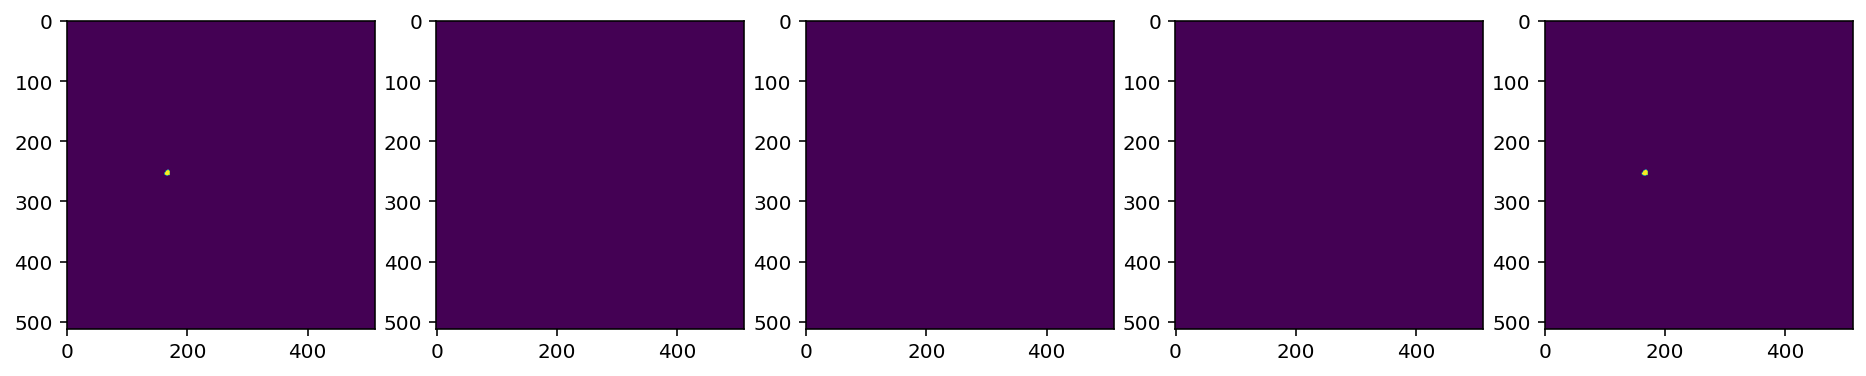

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.413161 	Validation Loss: 0.524327


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9489646283740735


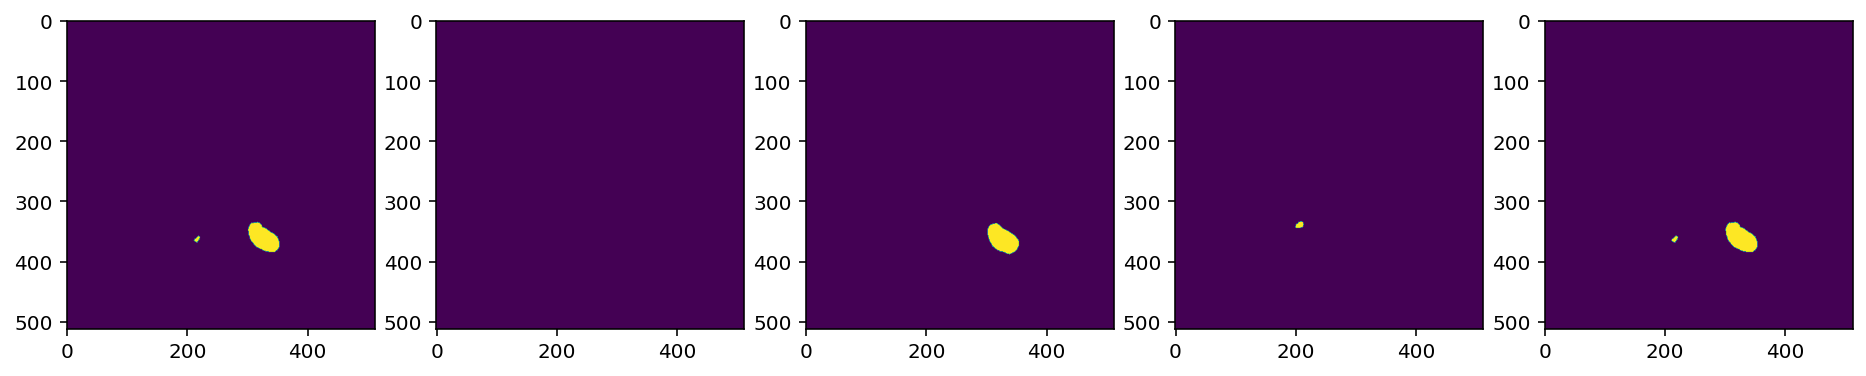

0.9759584946515802


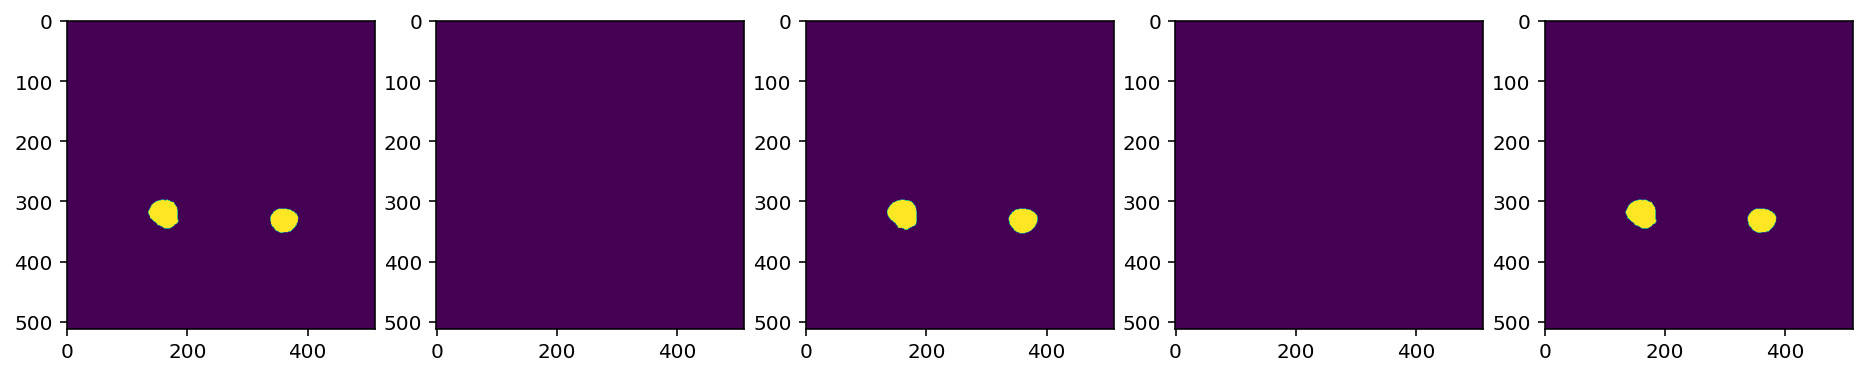

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.407687 	Validation Loss: 0.532043


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9836771803657647


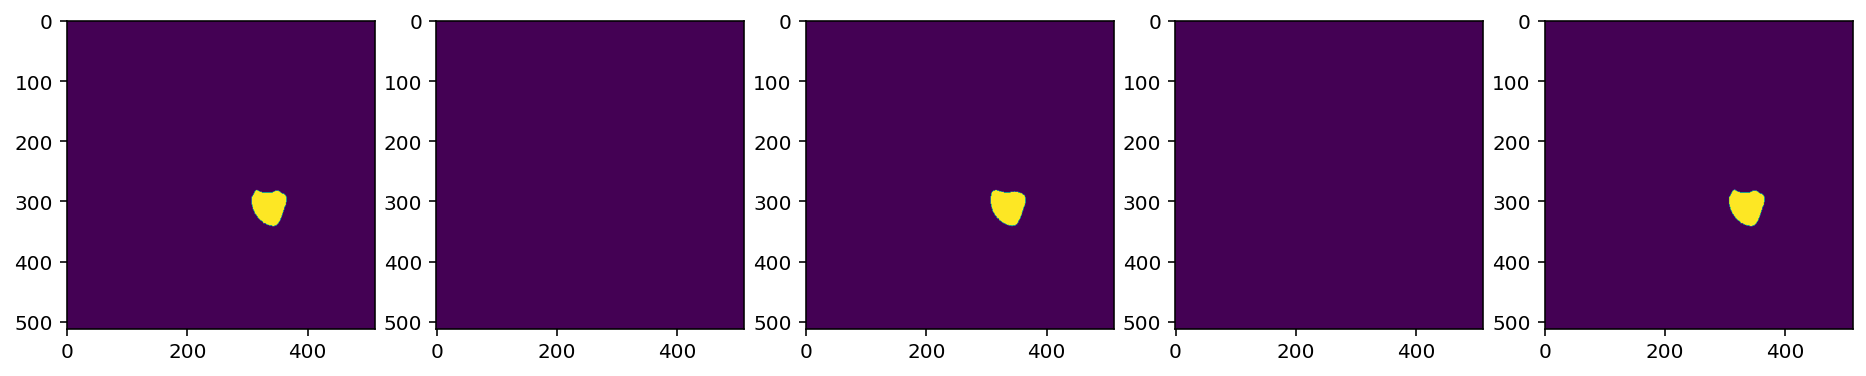

0.9849081044287962


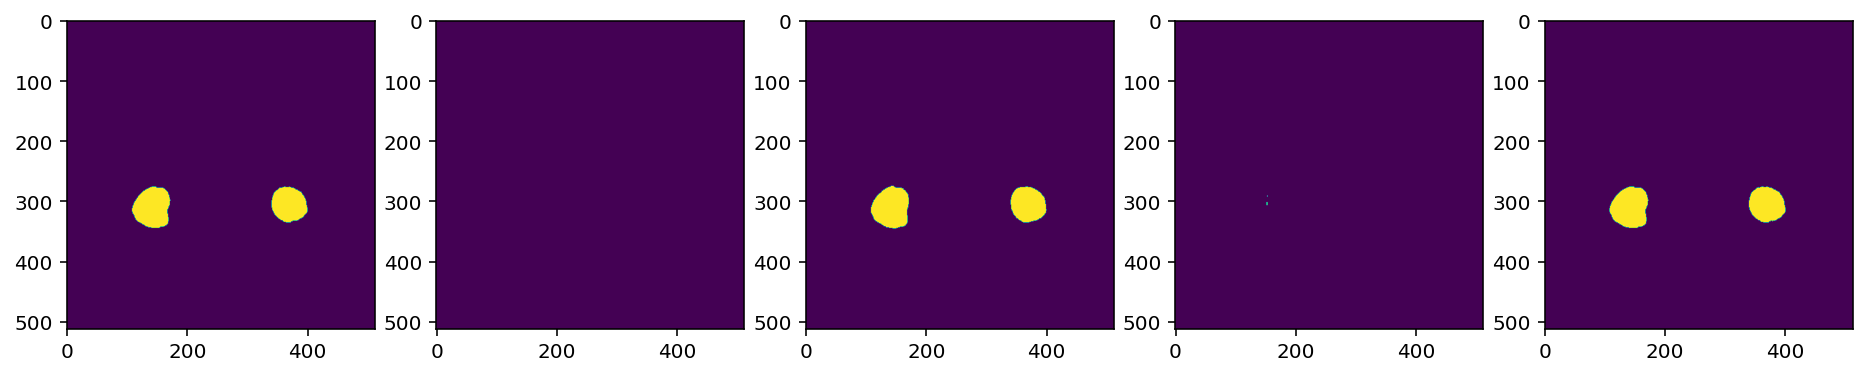

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.406534 	Validation Loss: 0.519816


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9695588938850791


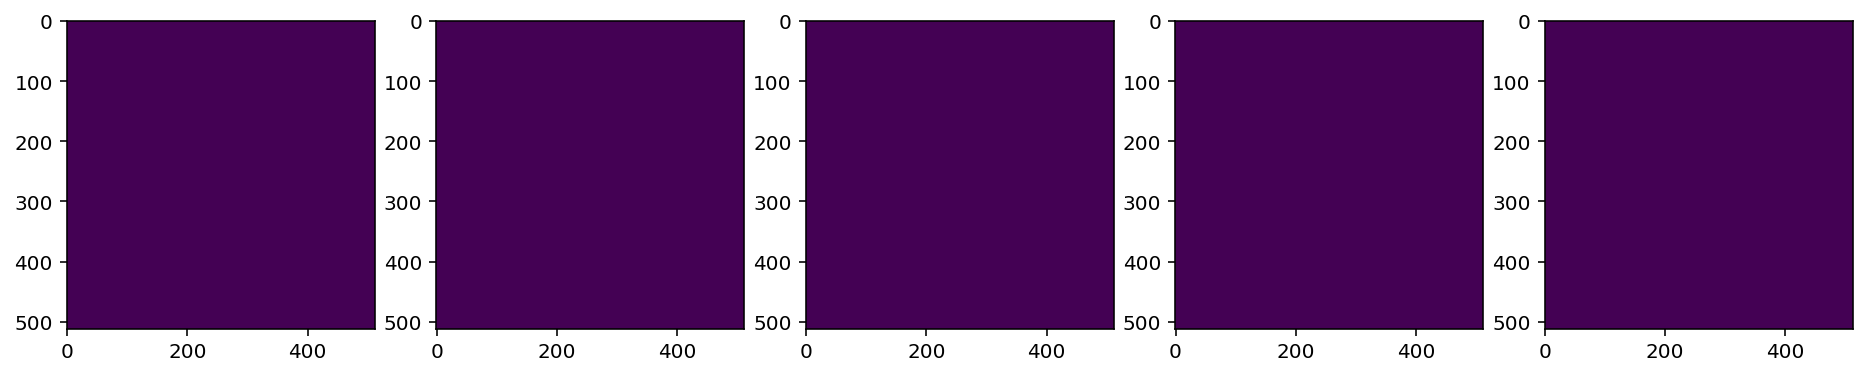

0.890287955904391


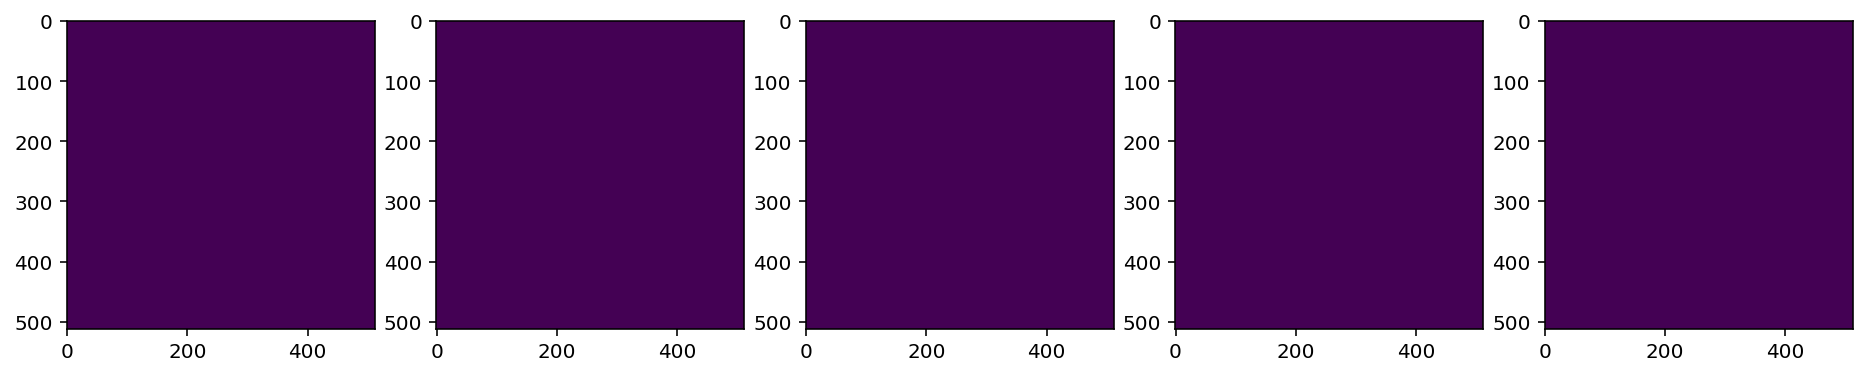

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


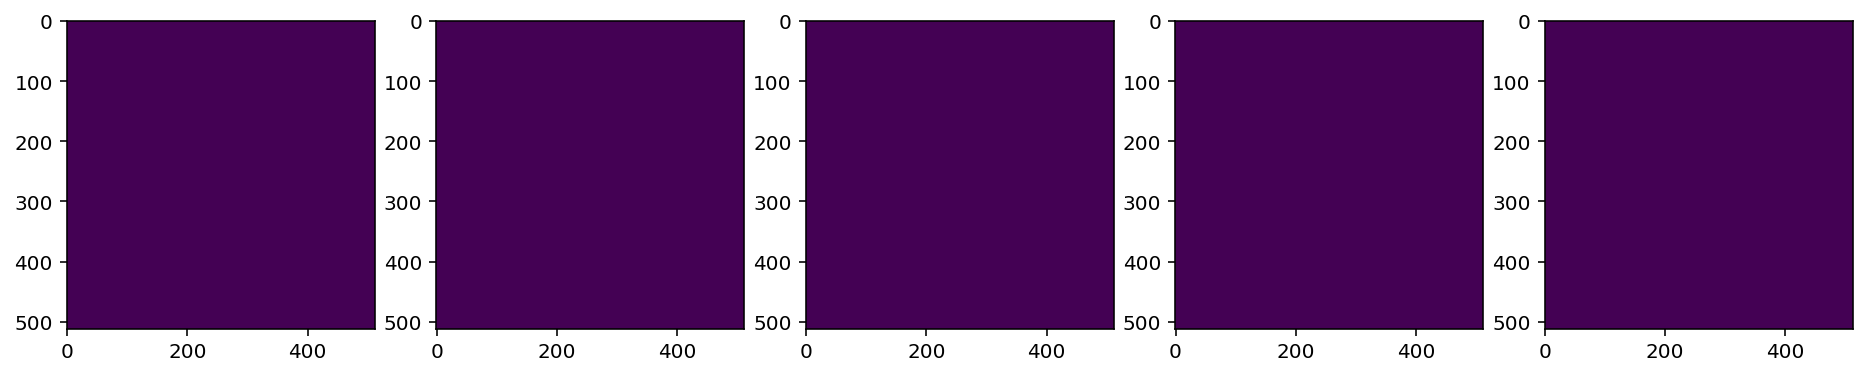

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.410381 	Validation Loss: 0.520870


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9612893111351283


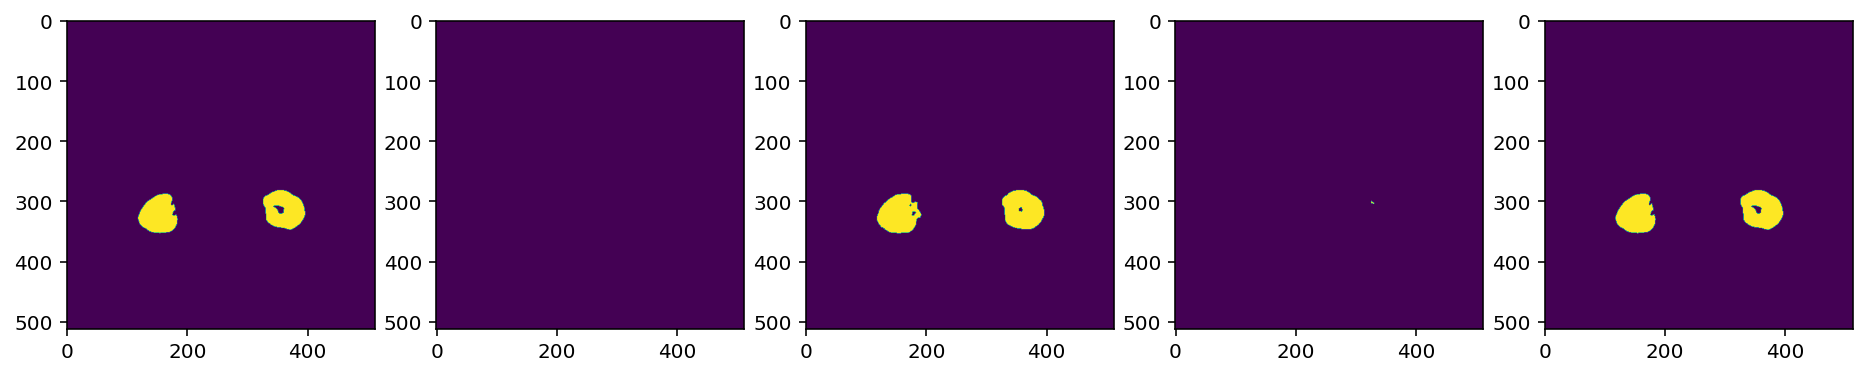

0.9751757443191944


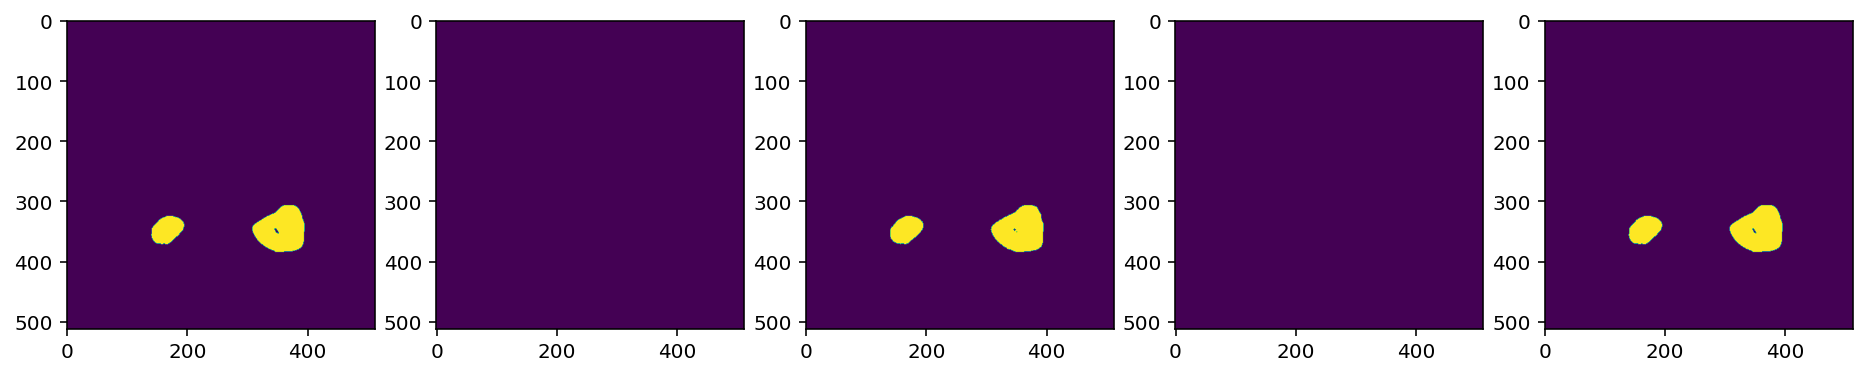

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.403908 	Validation Loss: 0.519955


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9785082570277874


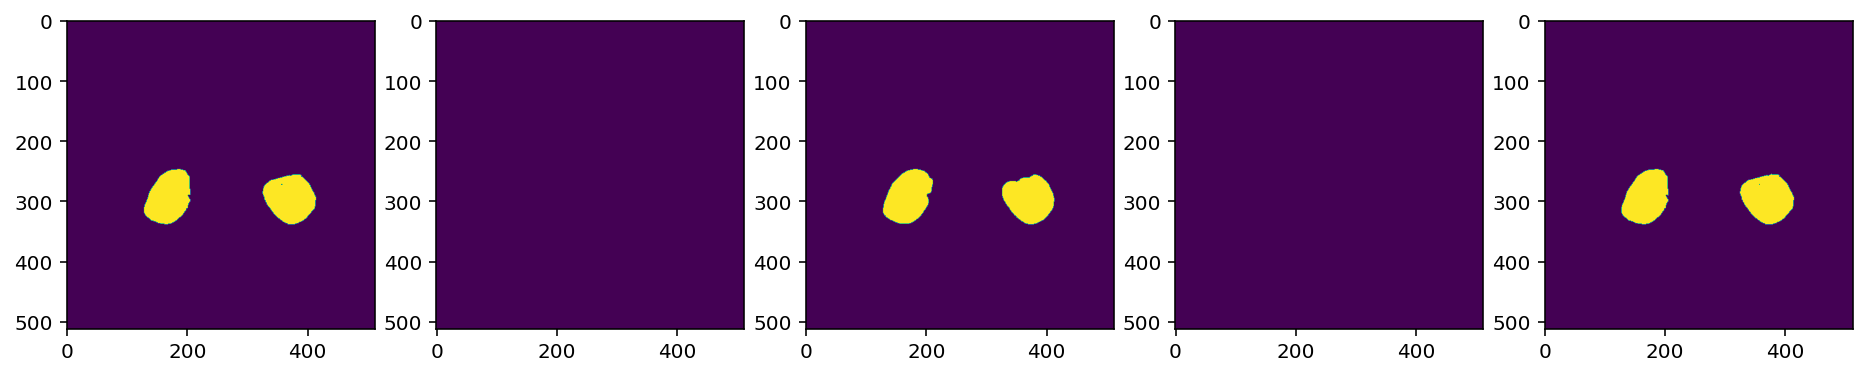

0.9742787215391099


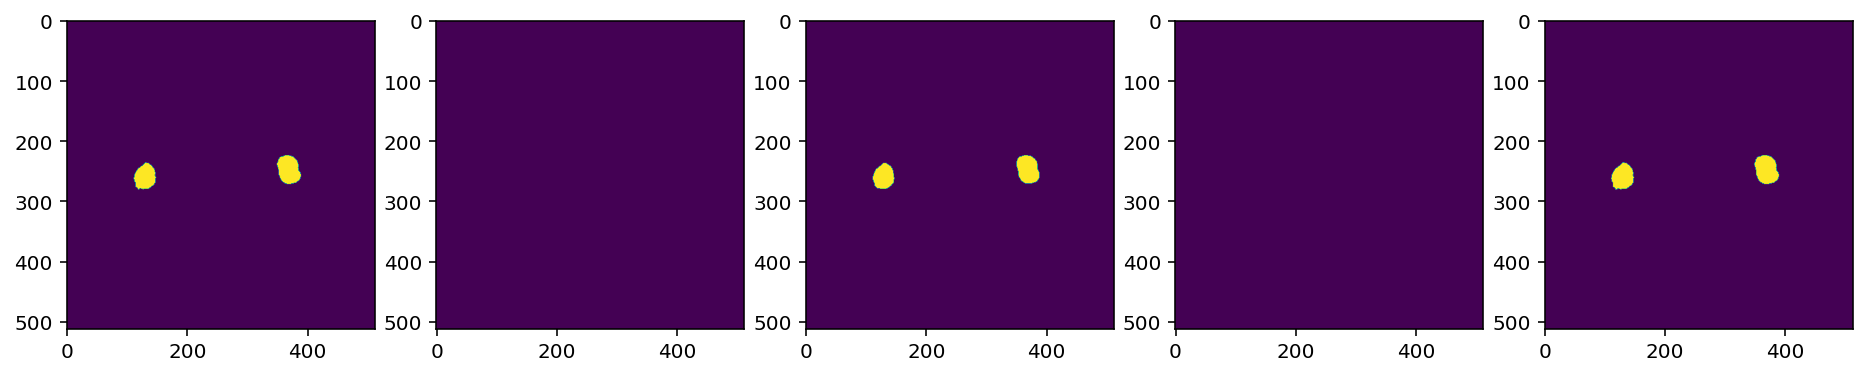

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.407186 	Validation Loss: 0.512205


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


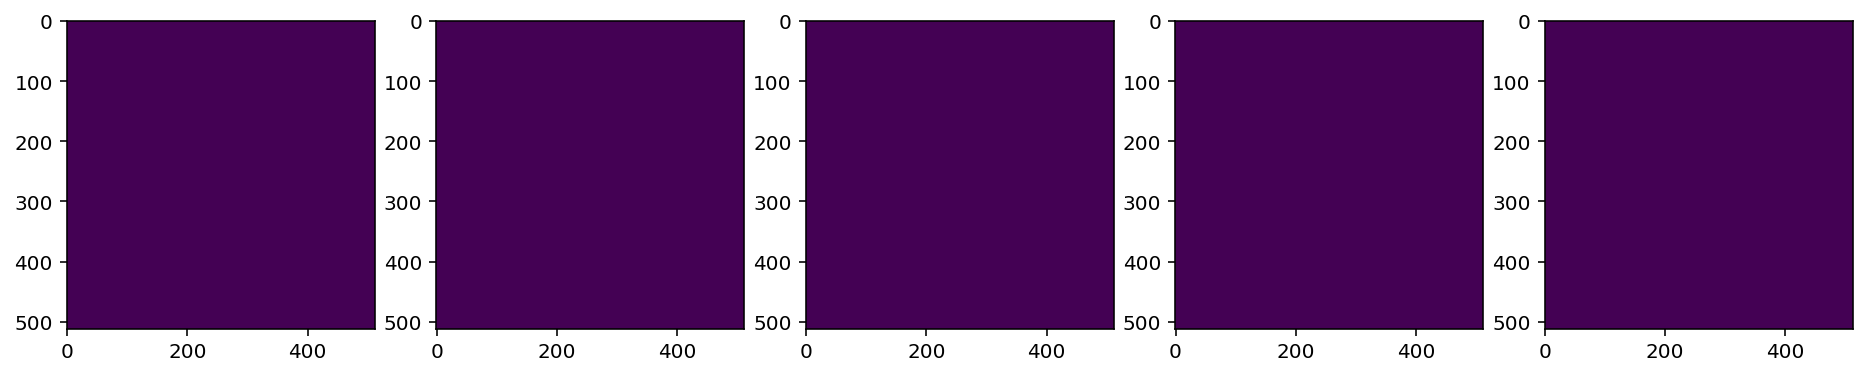

0.9408847590948846


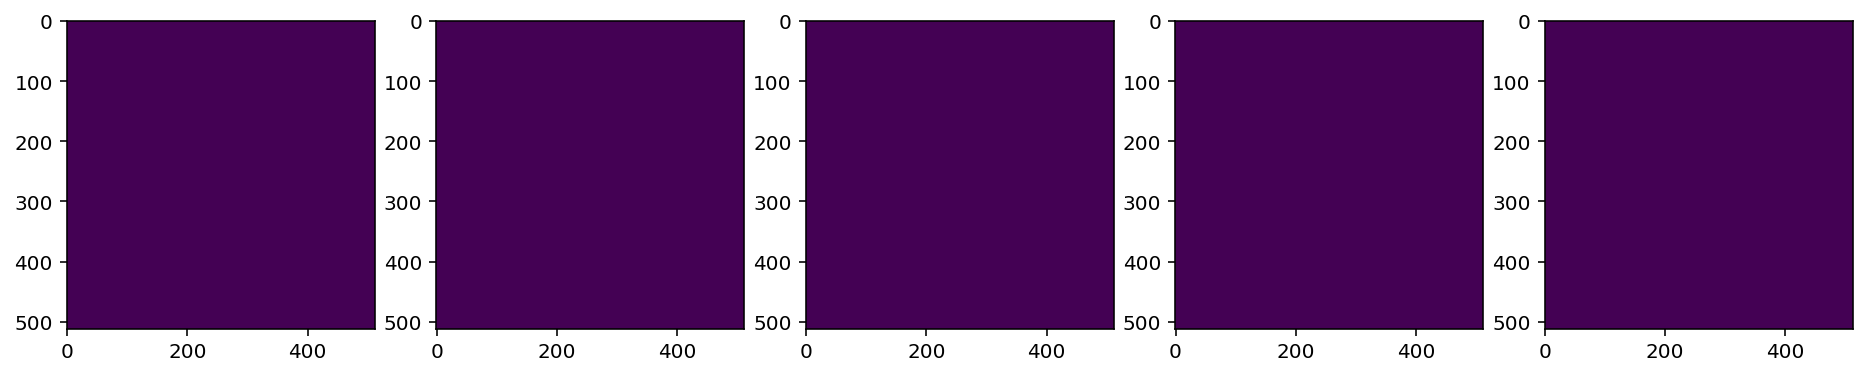

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.402173 	Validation Loss: 0.517736


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9654370605494664


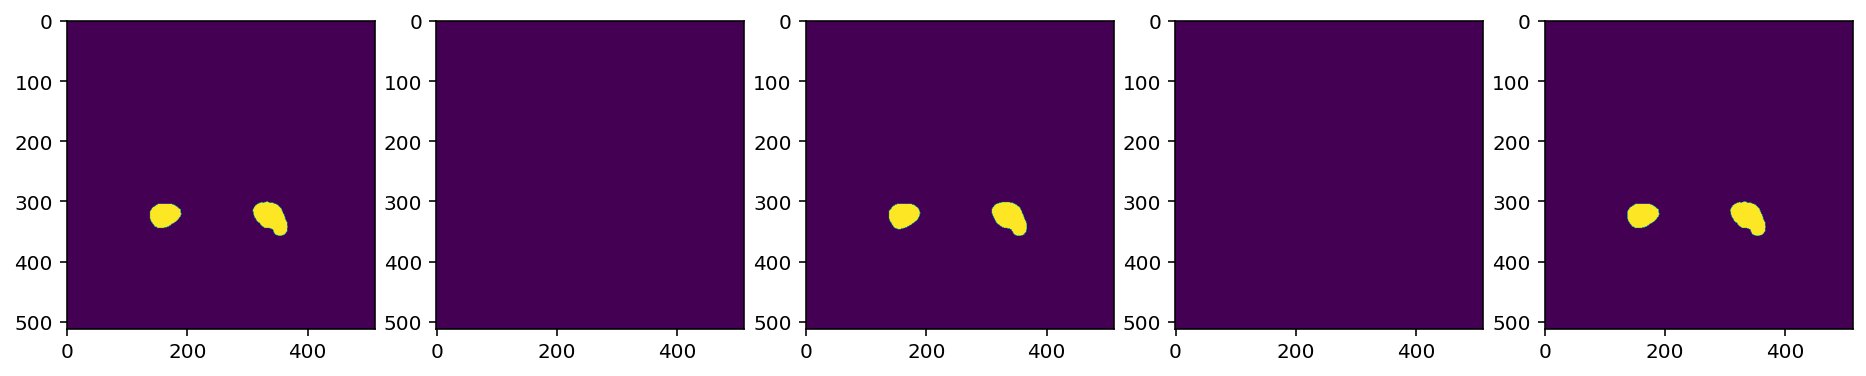

0.9701868803585474


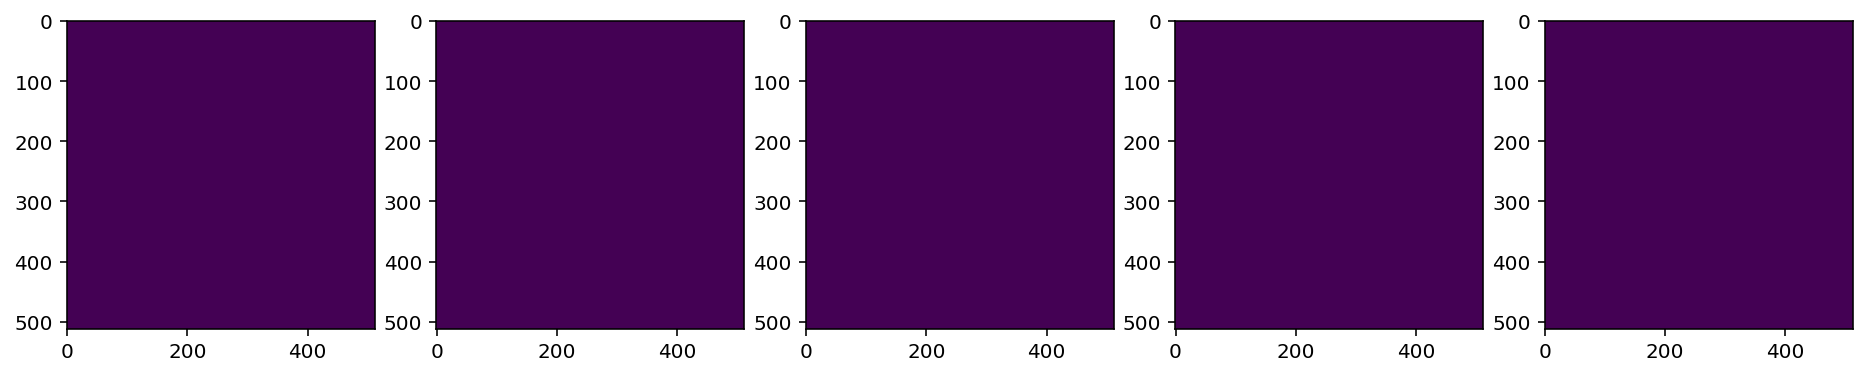

0.9679374488911173


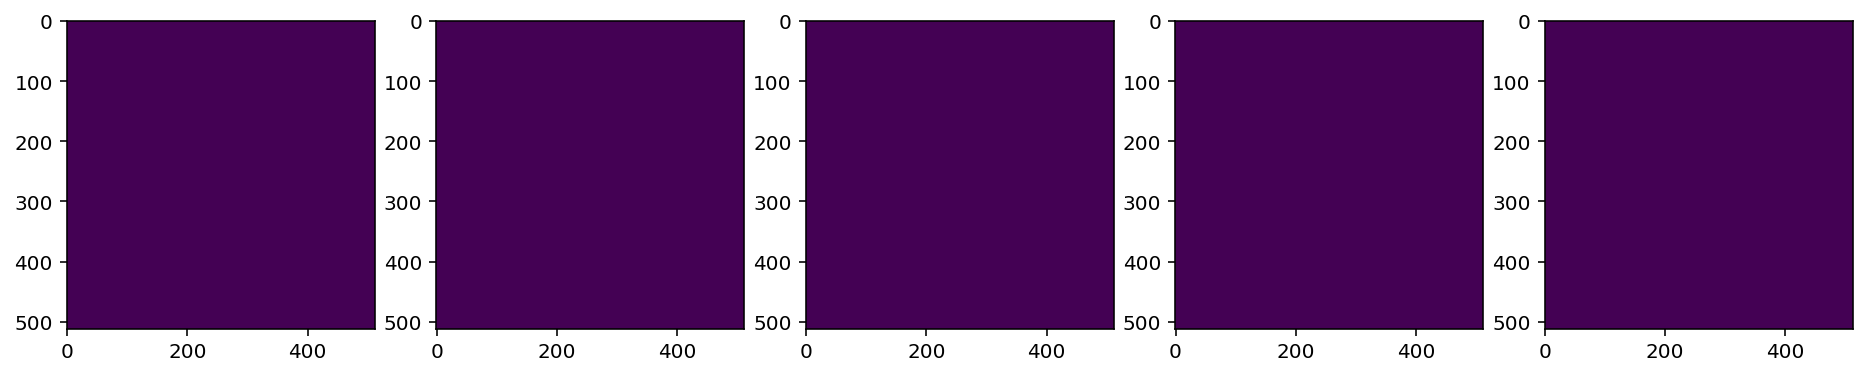

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.398588 	Validation Loss: 0.515529


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9639899469229994


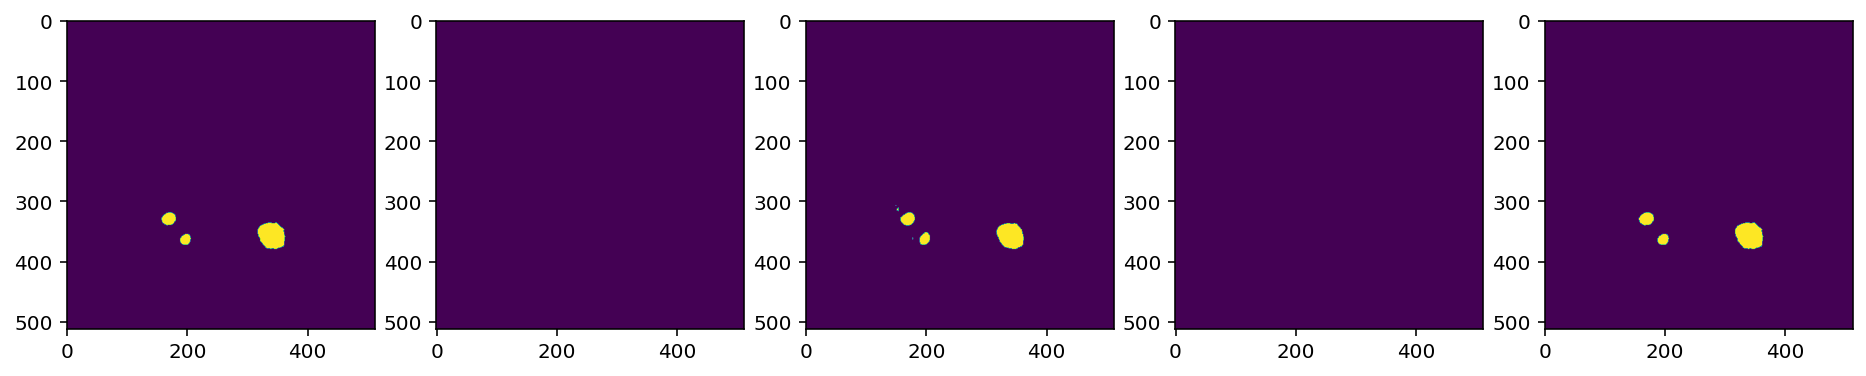

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


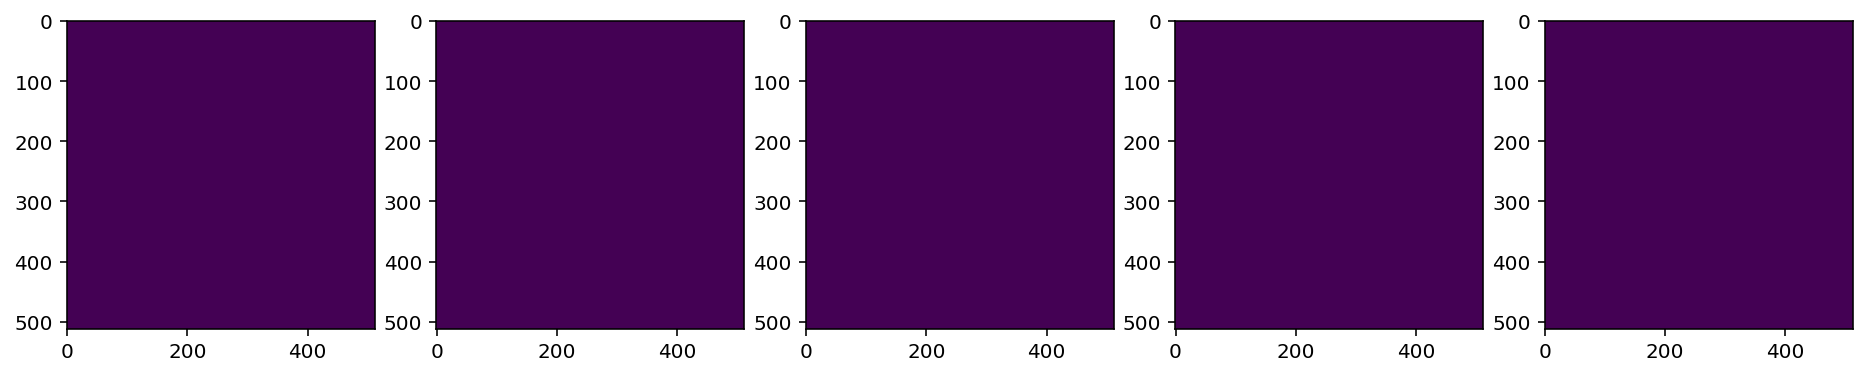

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.408169 	Validation Loss: 0.518389


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9834769624716551


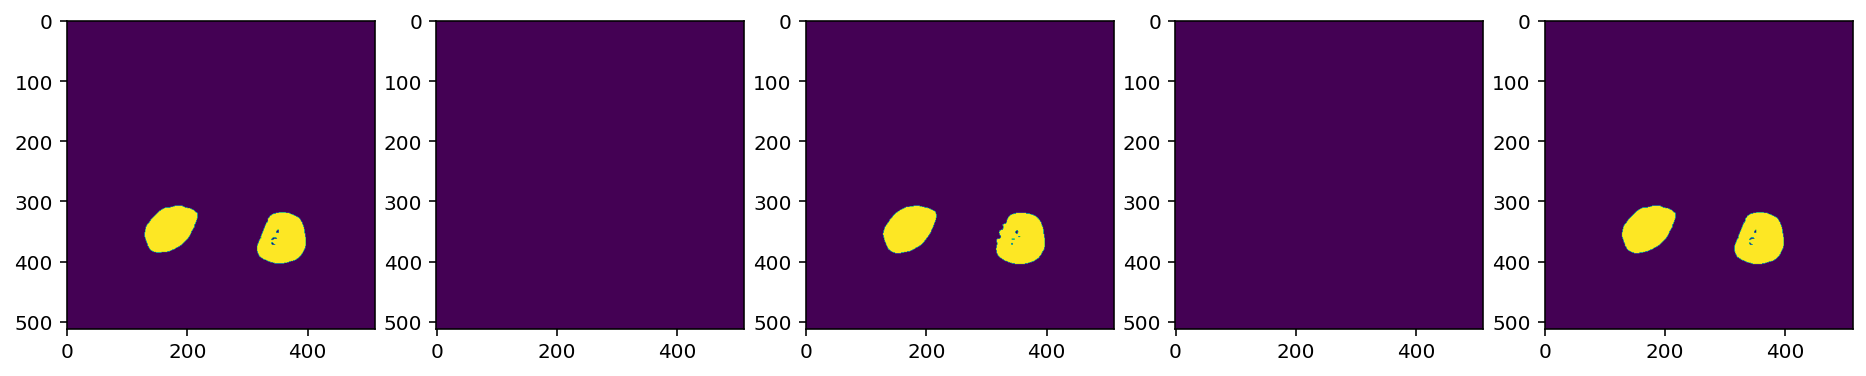

0.9749424634259053


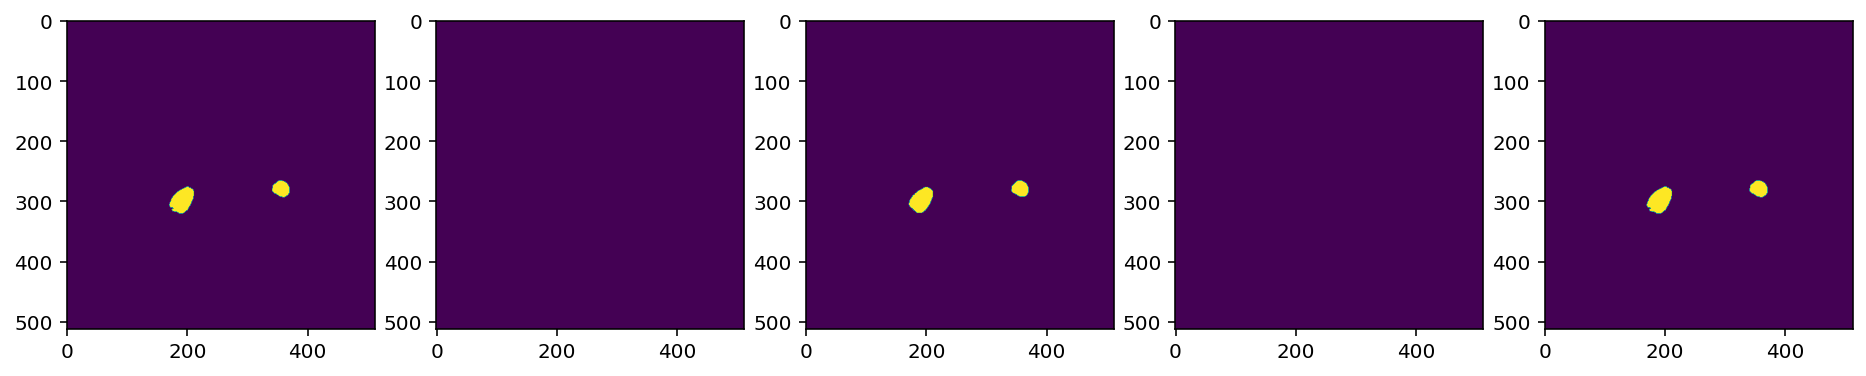

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.397709 	Validation Loss: 0.511923


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9664203799976065


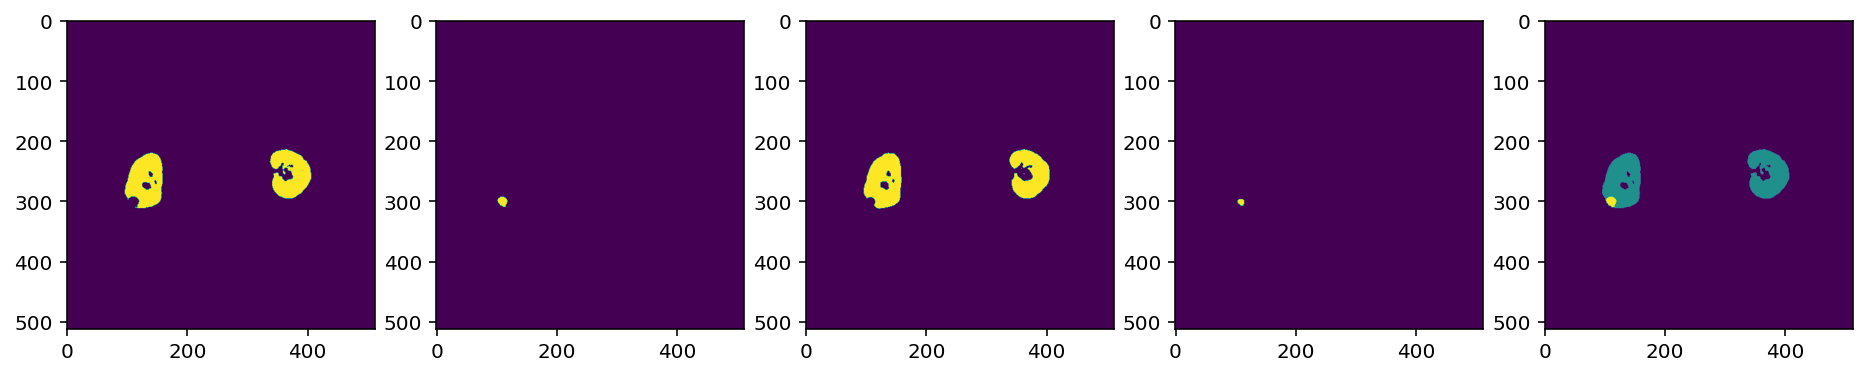

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


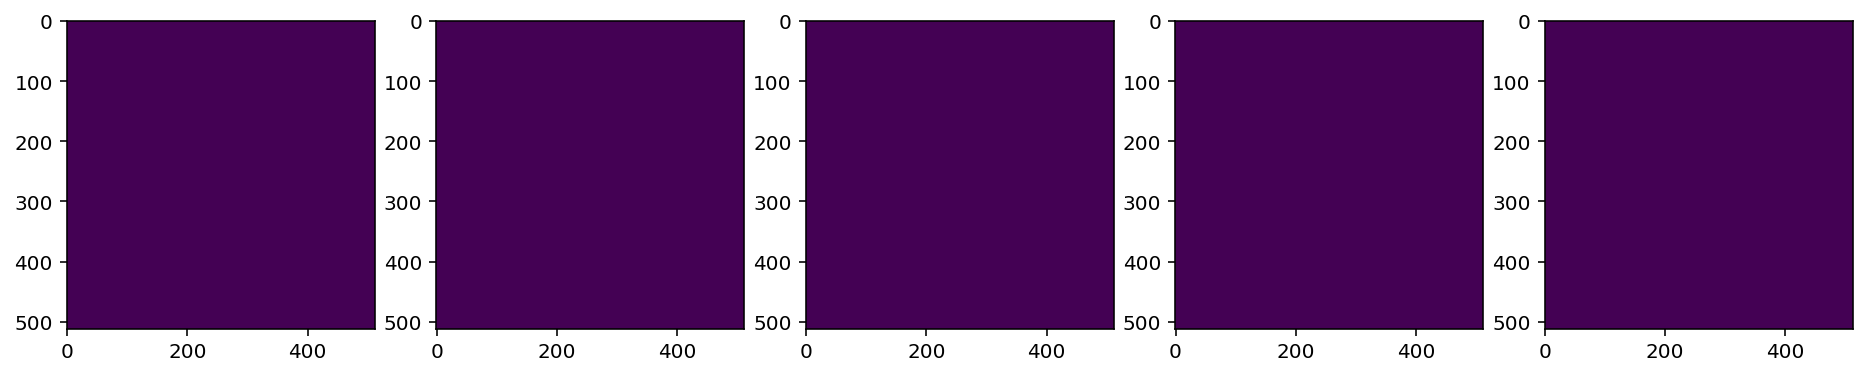

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.403916 	Validation Loss: 0.519024


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


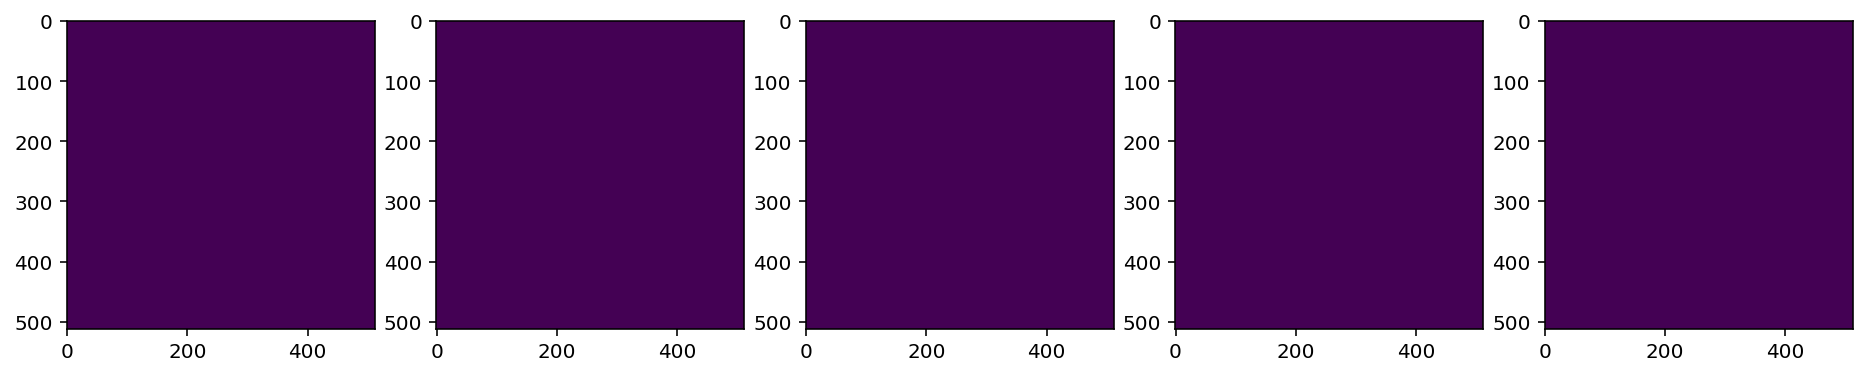

0.9753538667557253


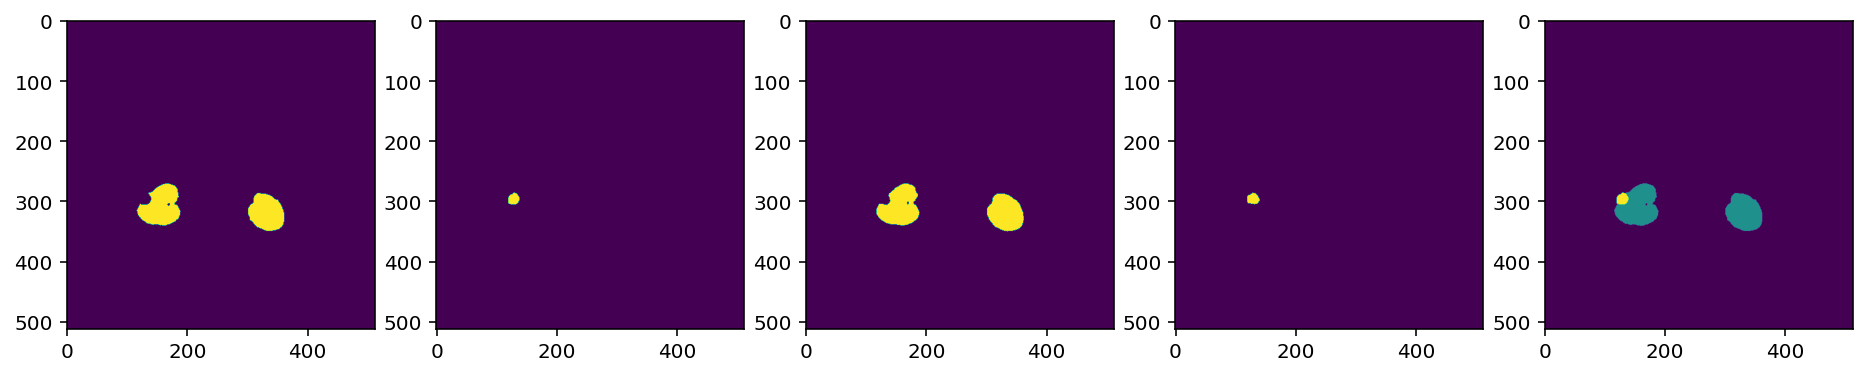

0.9430650174959463


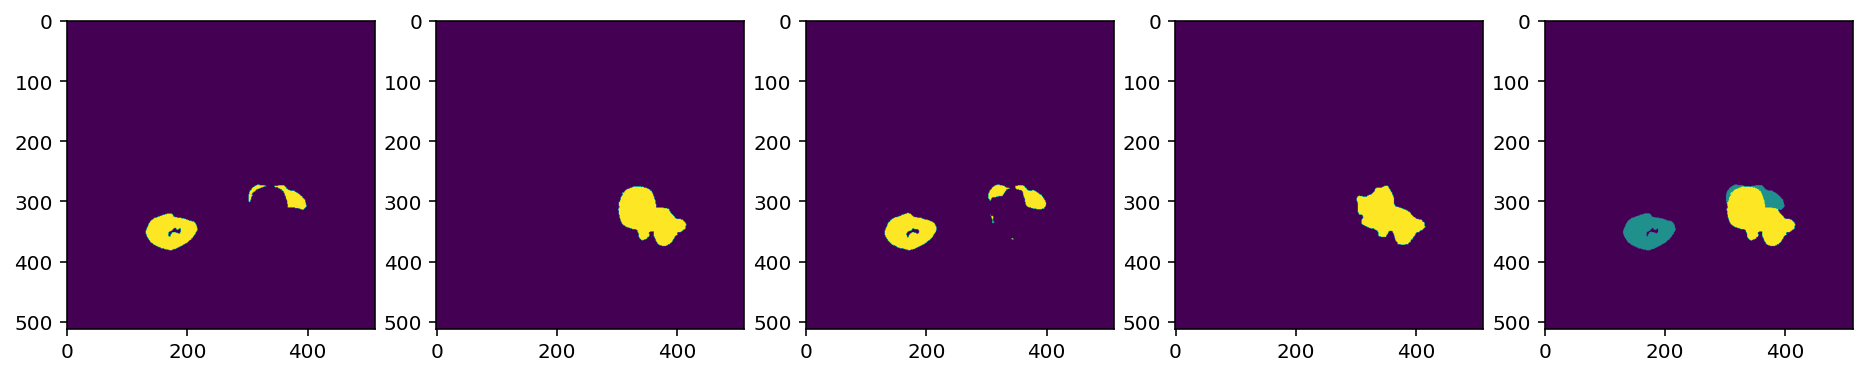

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.403602 	Validation Loss: 0.534053


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9540619836338455


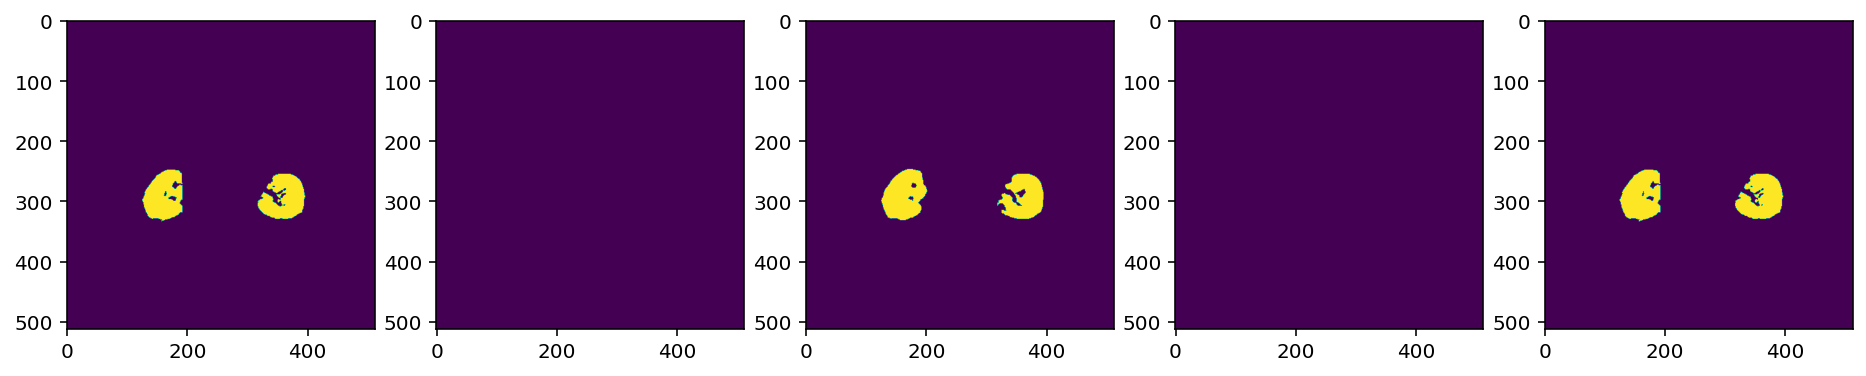

0.9667719558060566


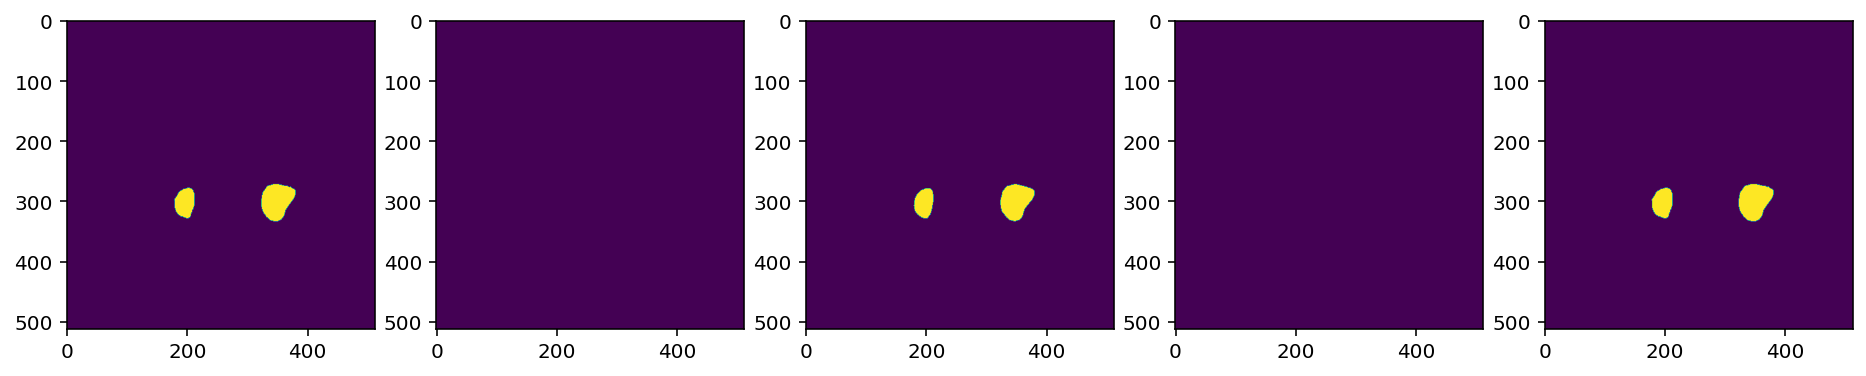

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.397813 	Validation Loss: 0.529275


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


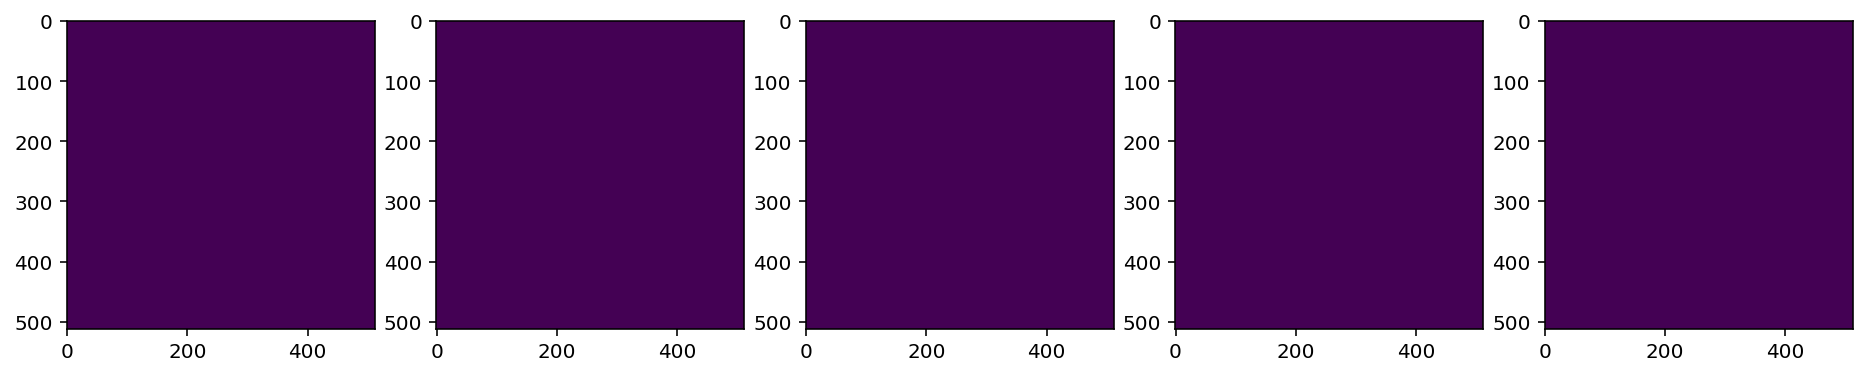

0.9451169576287044


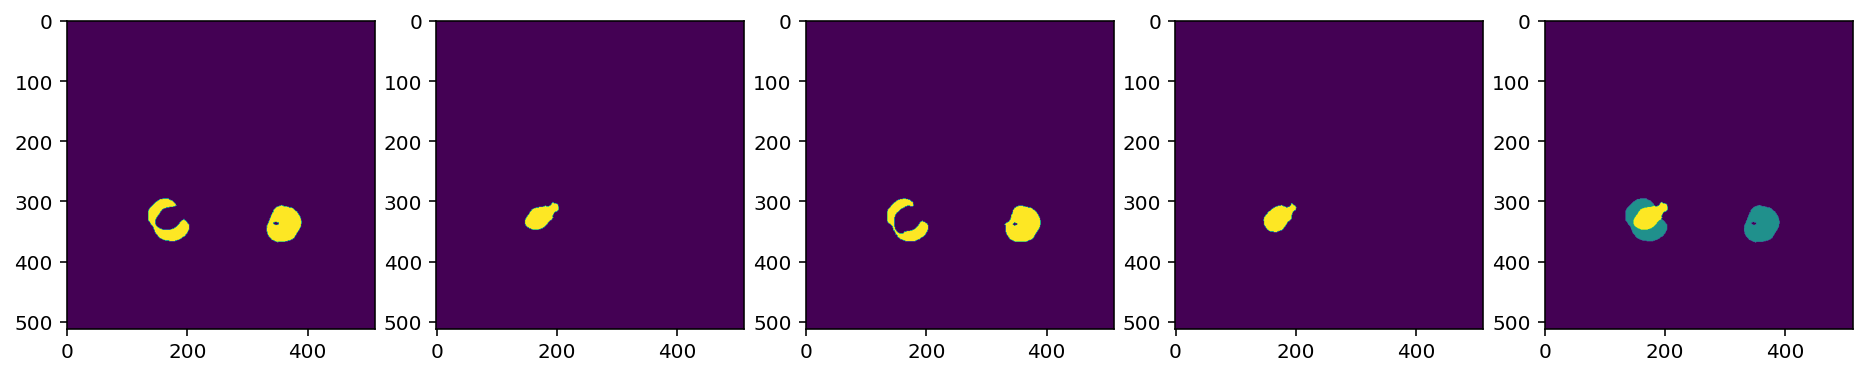

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.399726 	Validation Loss: 0.520151


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9608316259806831


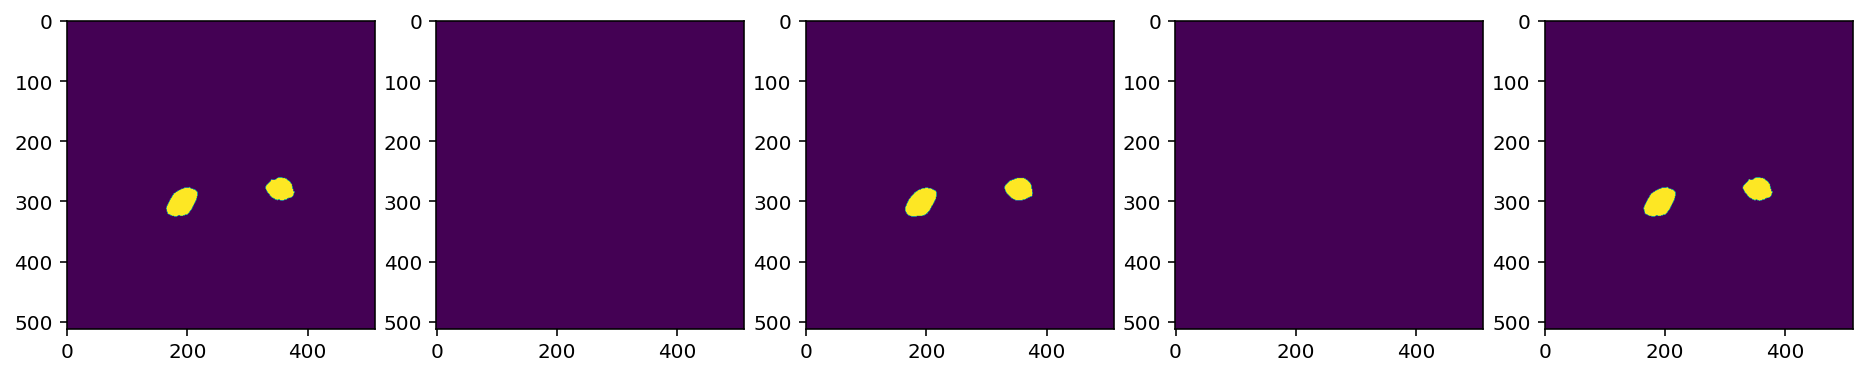

0.9709311845529599


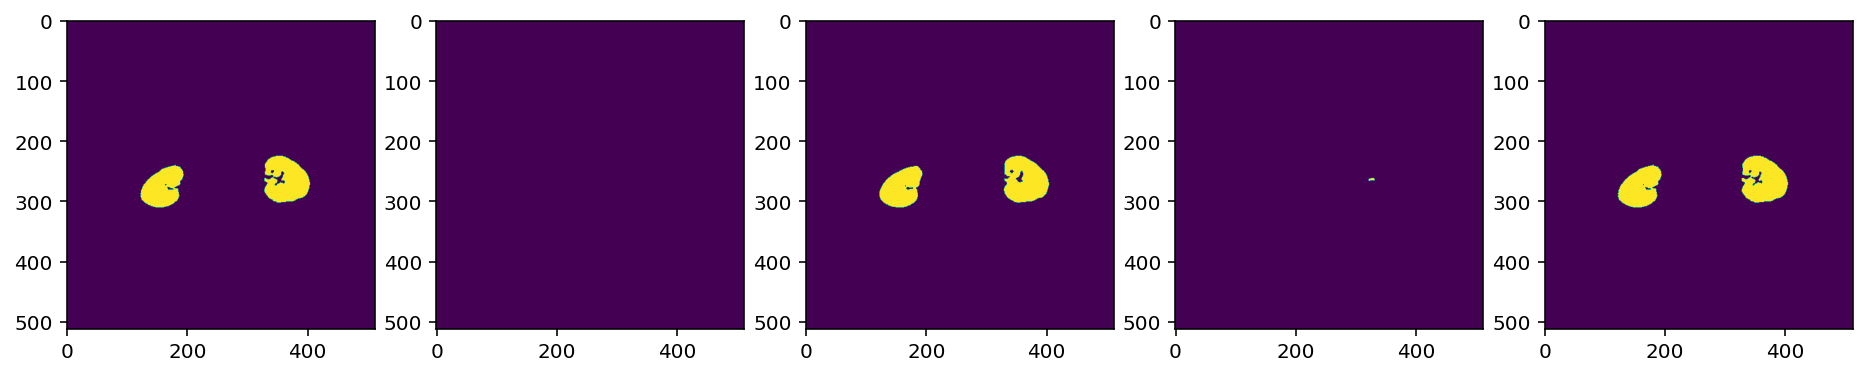

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.400552 	Validation Loss: 0.522153


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9654927856555023


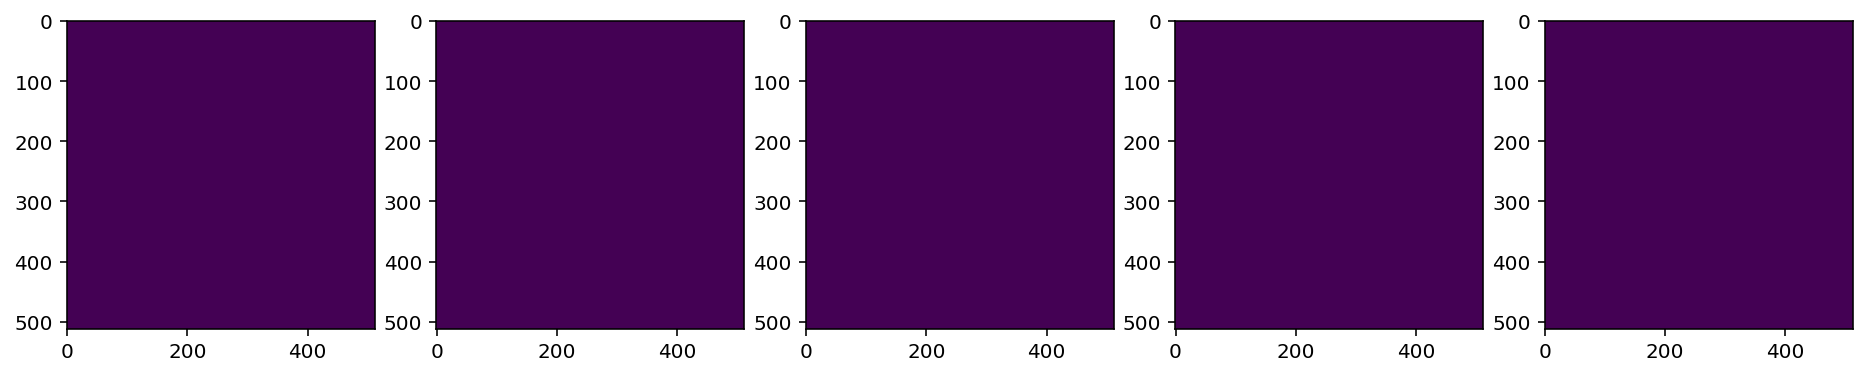

0.9868315876423942


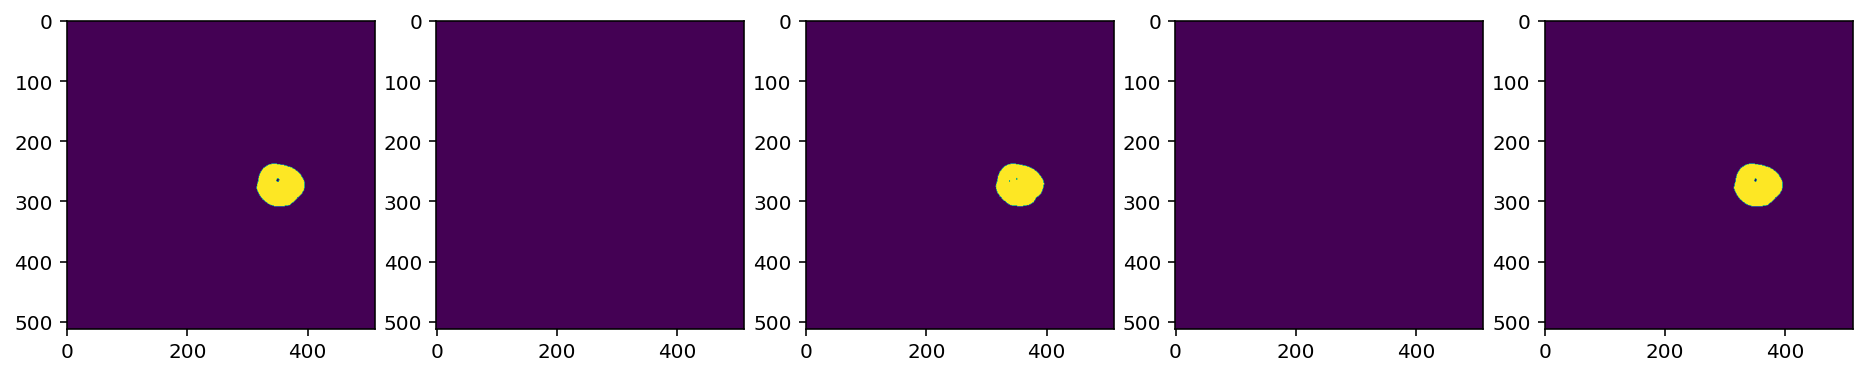

0.967456606989


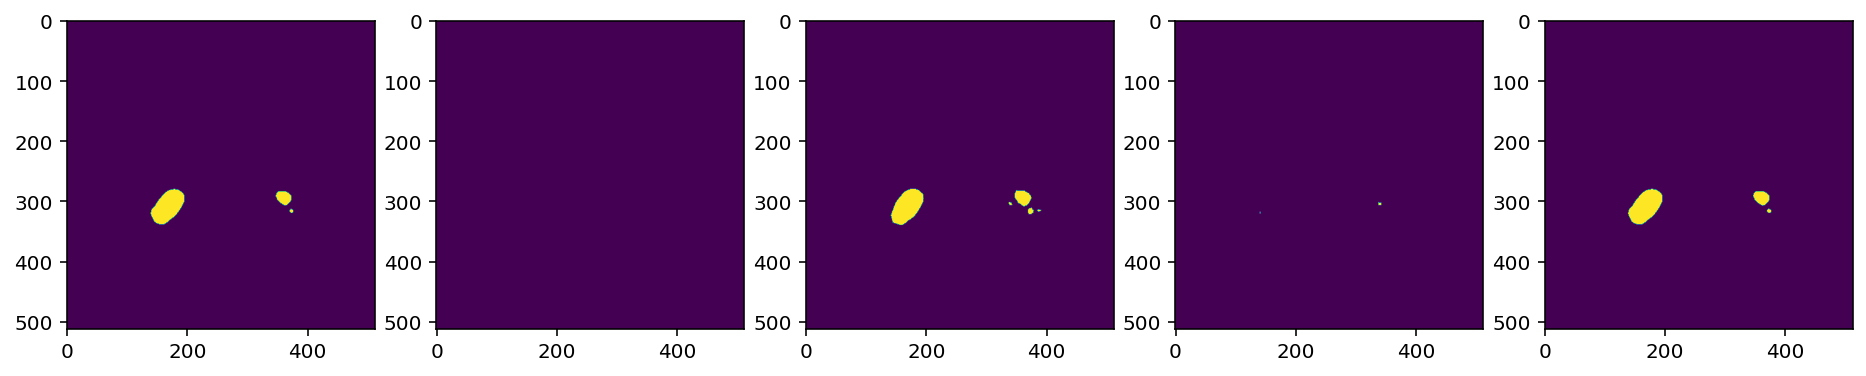

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.399591 	Validation Loss: 0.523340


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


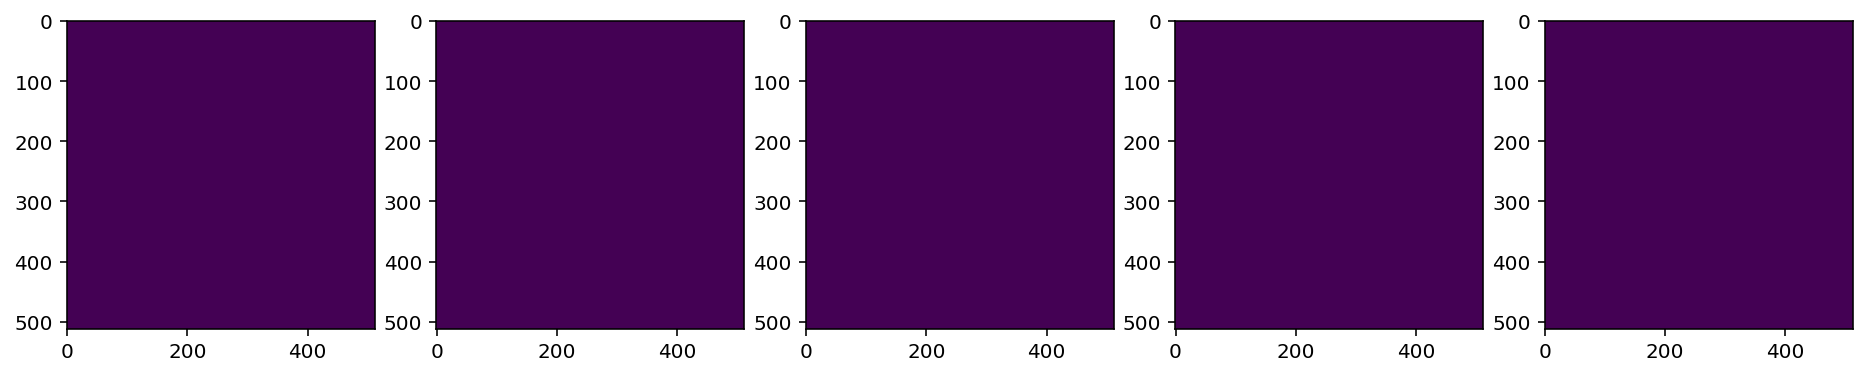

0.9763324254056678


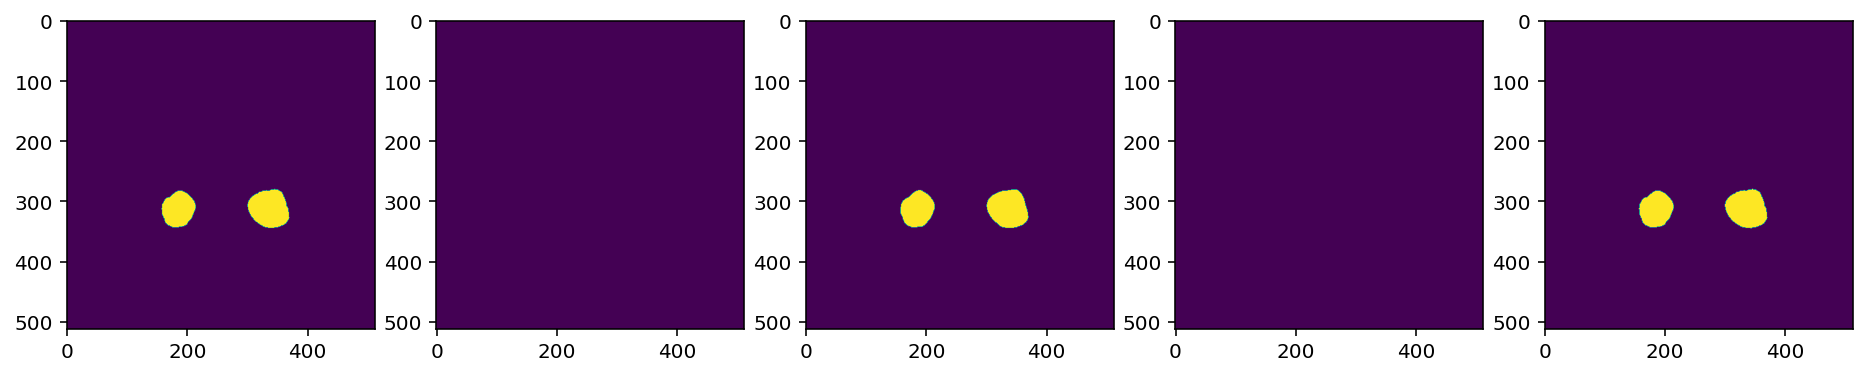

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.398680 	Validation Loss: 0.523859


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9579220786065212


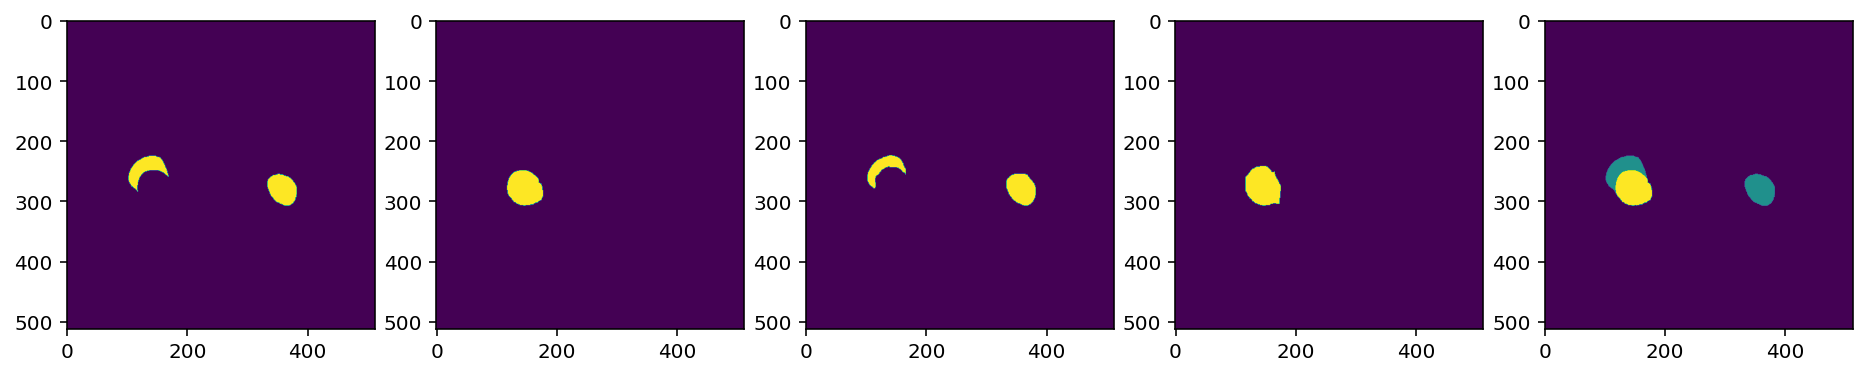

0.9787791152579959


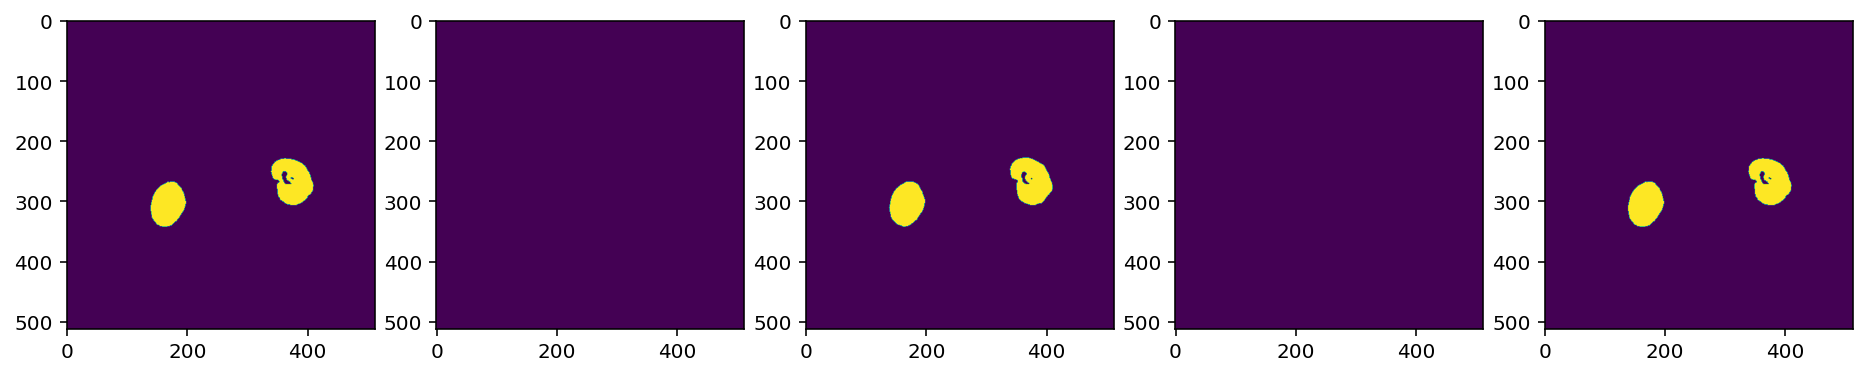

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.393424 	Validation Loss: 0.531252


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9795252574423026


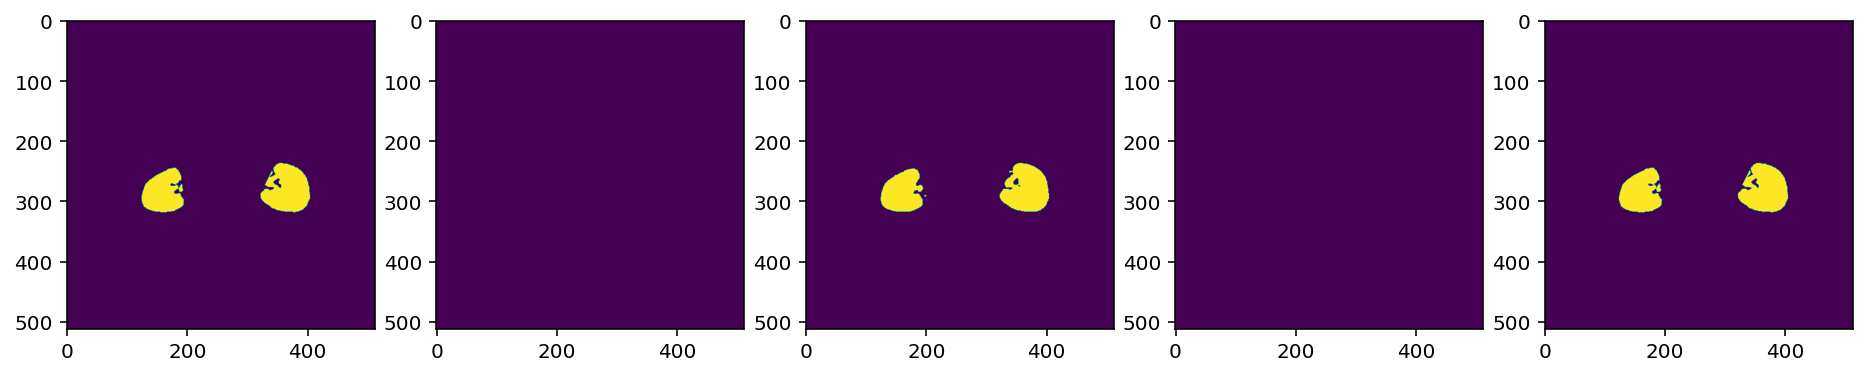

0.9385750581103361


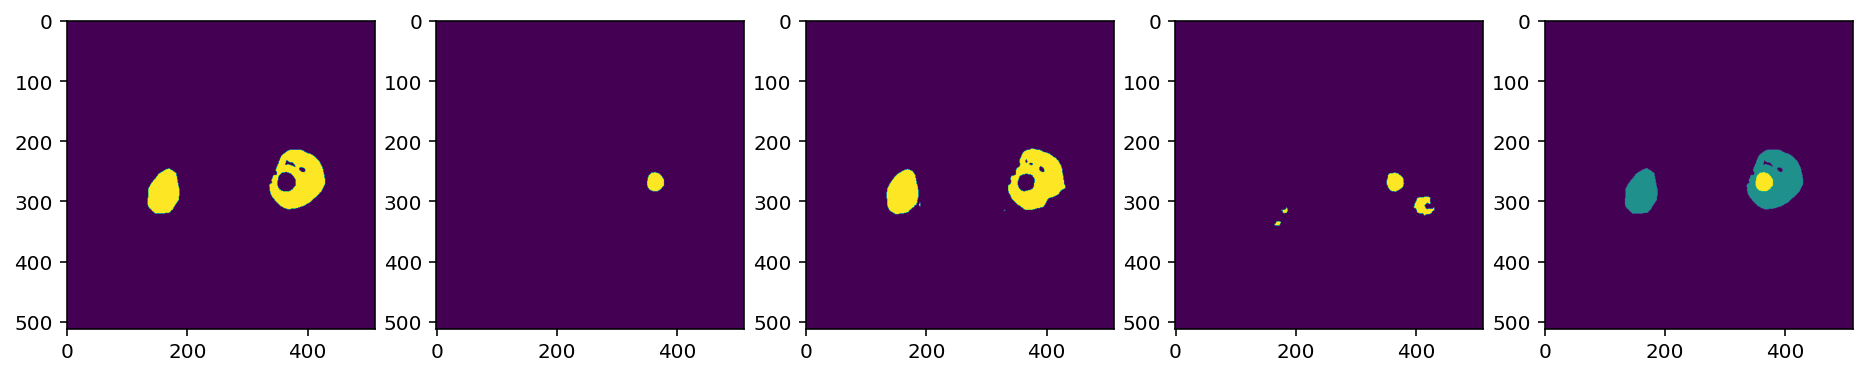

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.402540 	Validation Loss: 0.525582


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9577283364466134


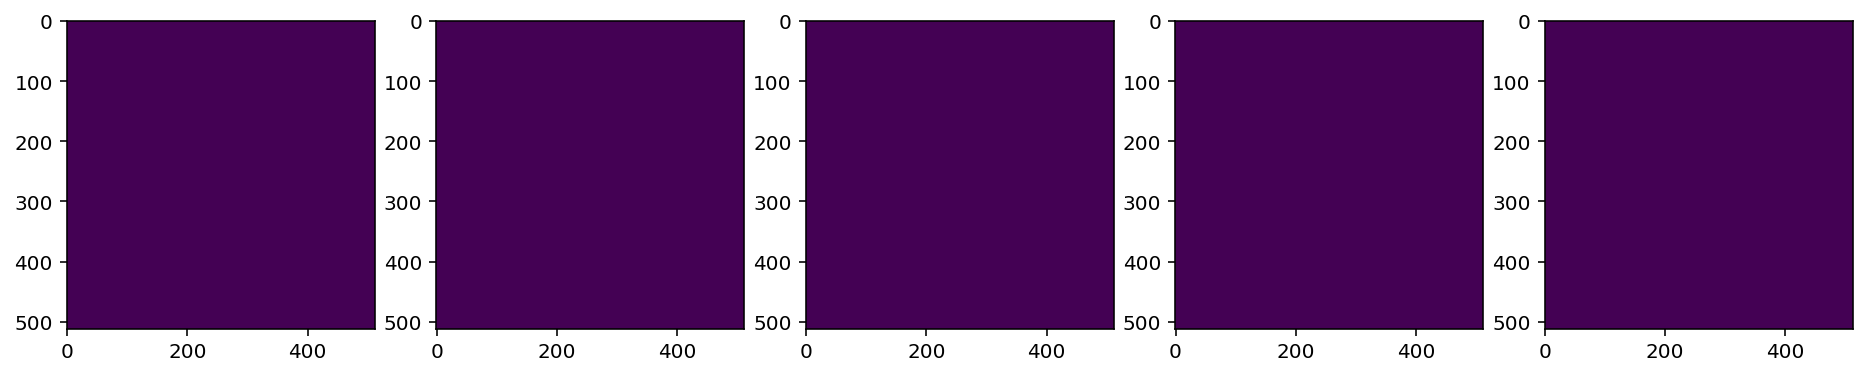

0.9157088963109594


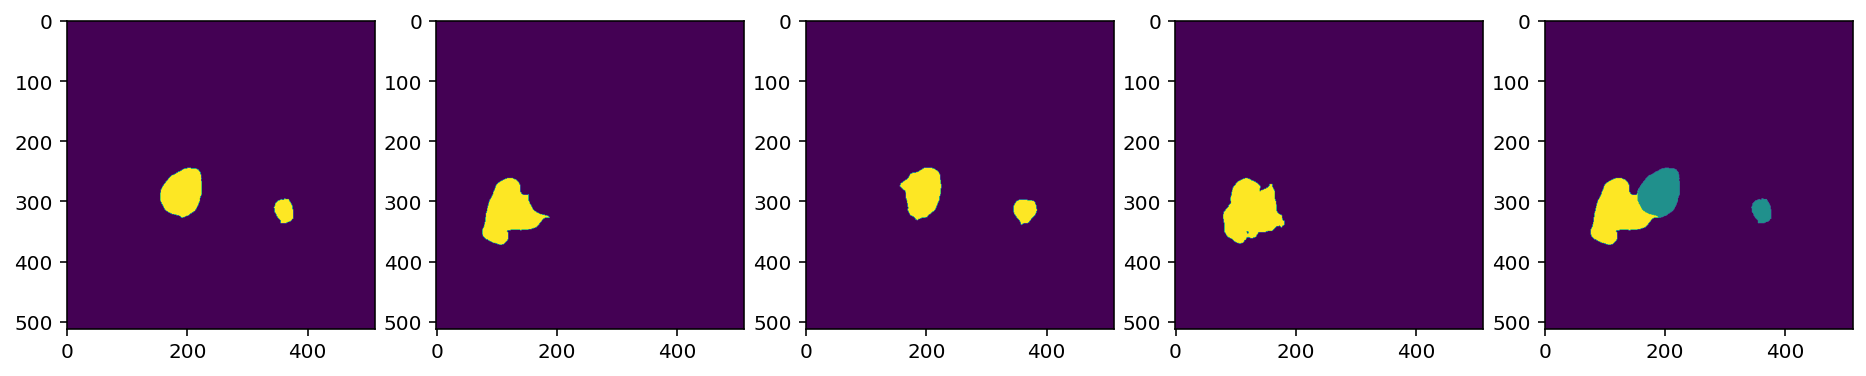

0.965991863163852


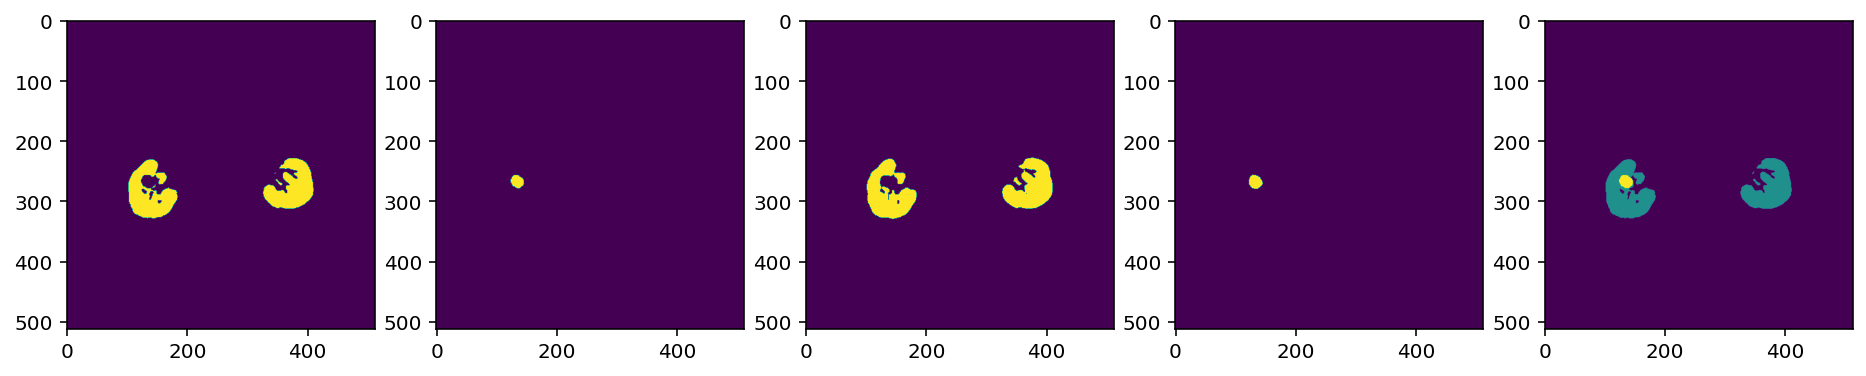

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.392214 	Validation Loss: 0.517733


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9841332892901682


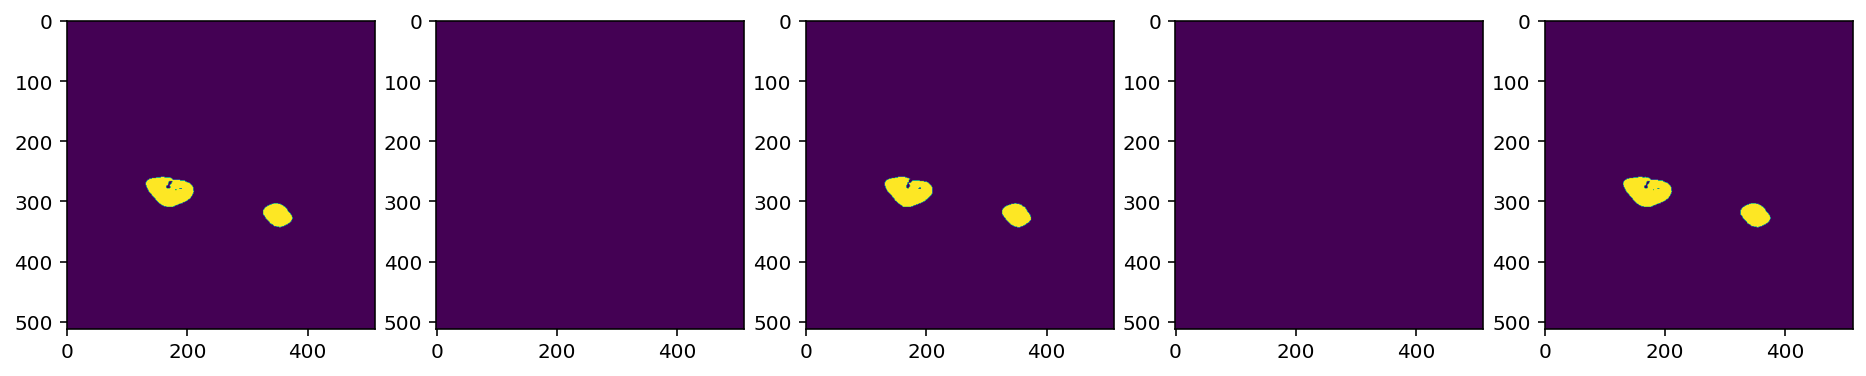

0.9719384433088476


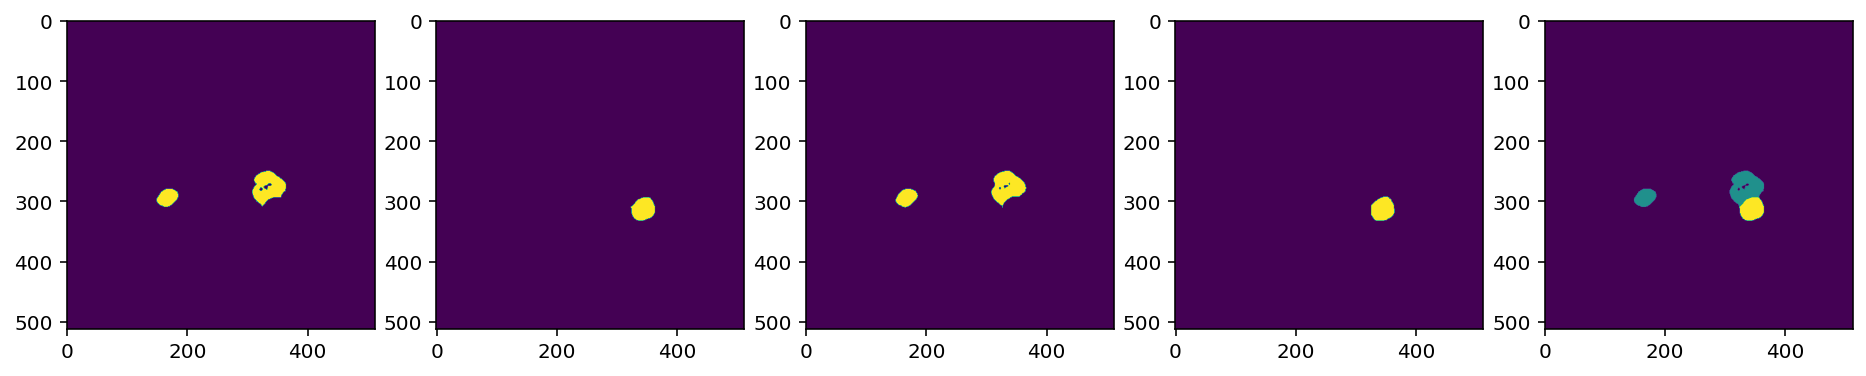

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.396867 	Validation Loss: 0.515181


  0%|          | 0/2240 [00:00<?, ?it/s]

0.7870802077849417


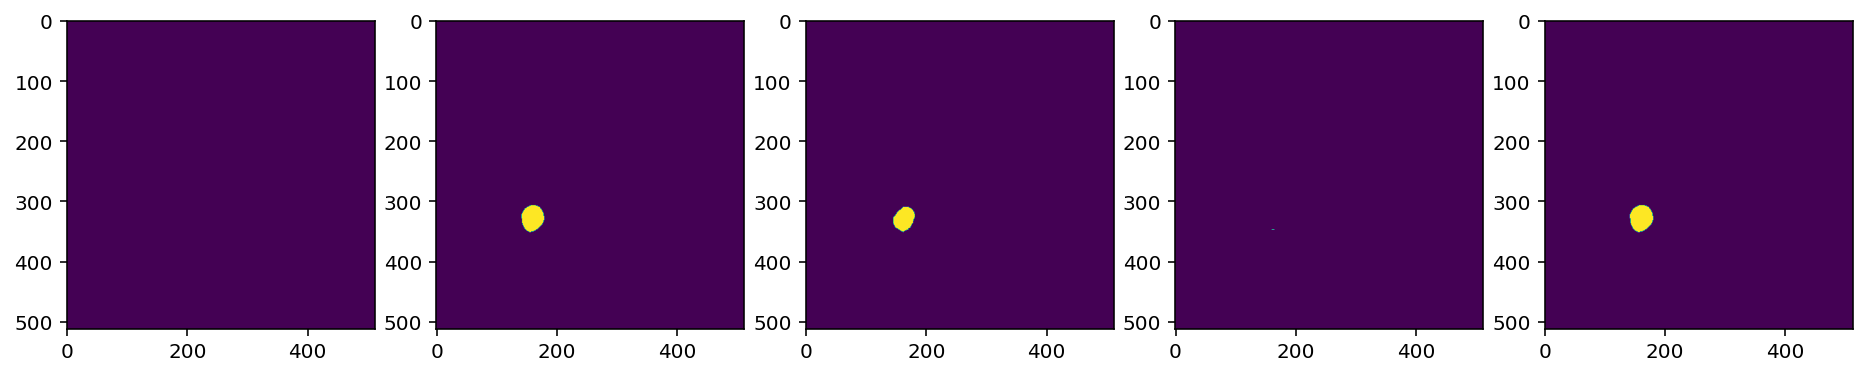

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


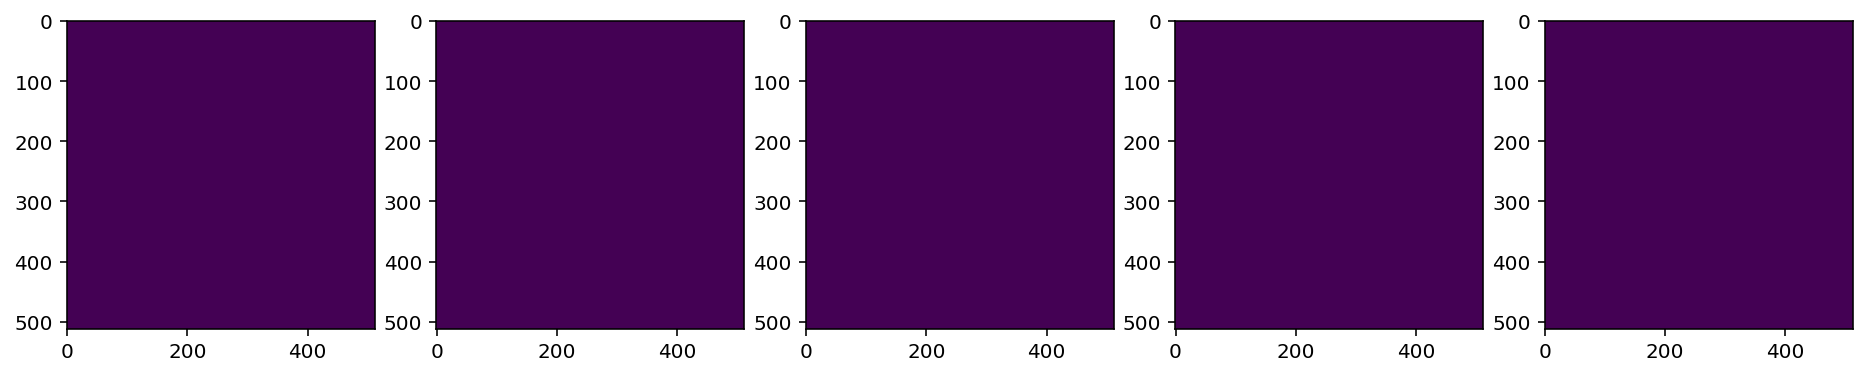

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.398646 	Validation Loss: 0.522389


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9775836509422551


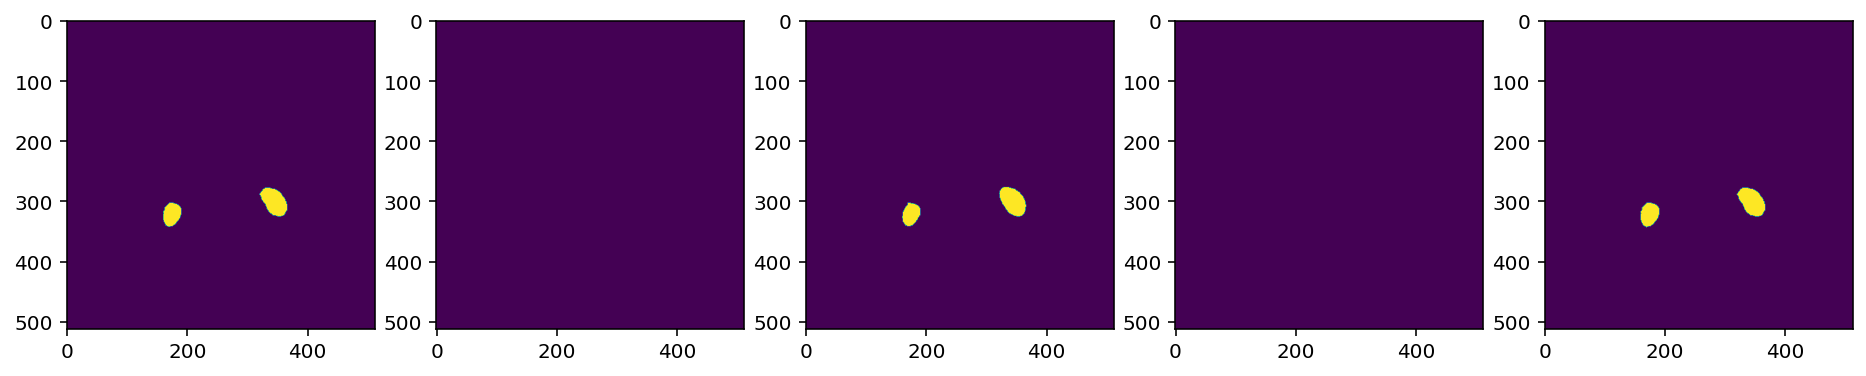

0.9702652636297155


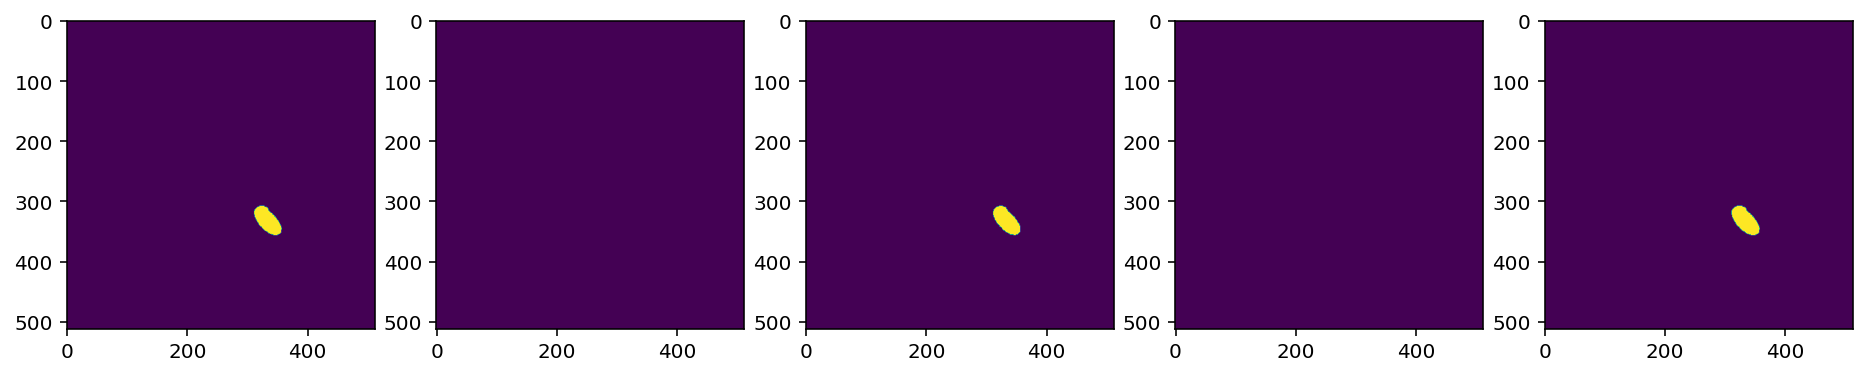

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.386900 	Validation Loss: 0.530483


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9364808655342763


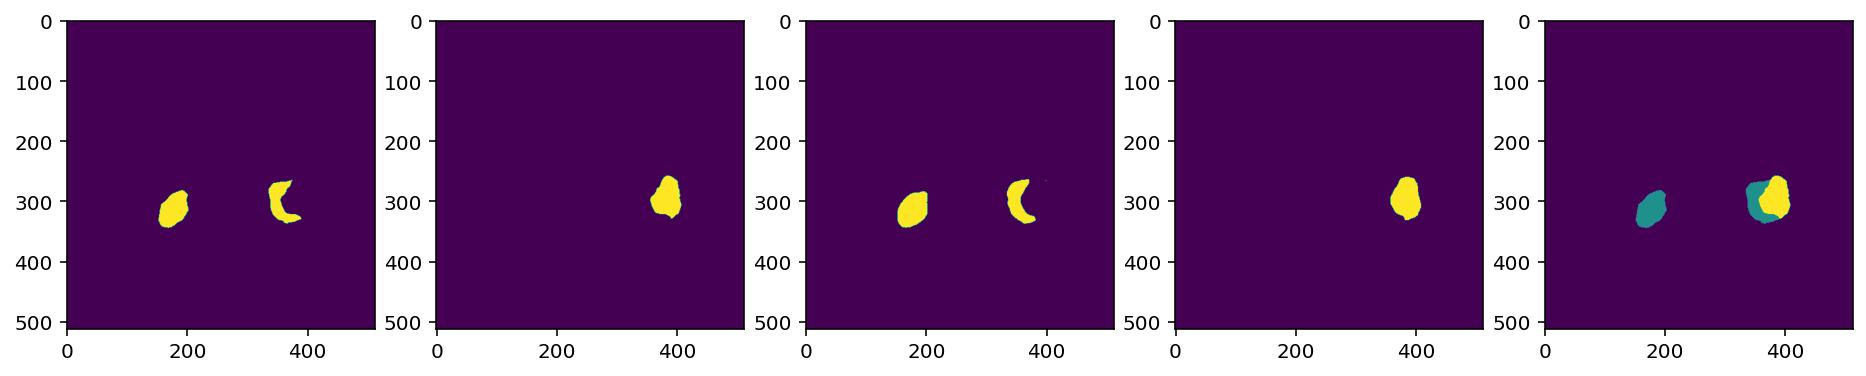

0.953966487188961


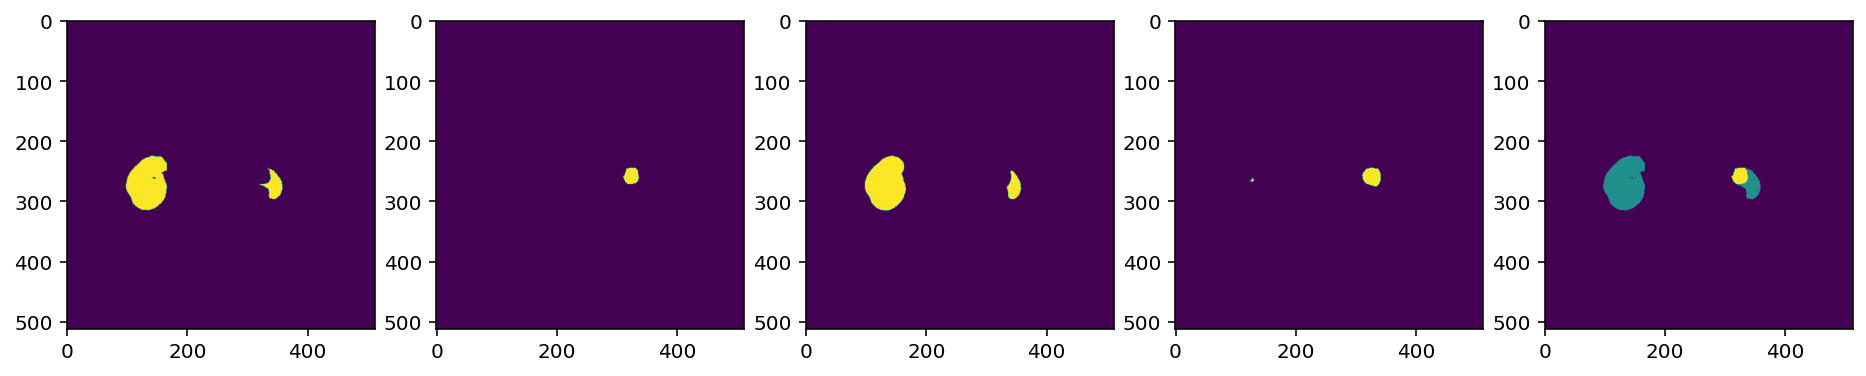

0.9602839268225849


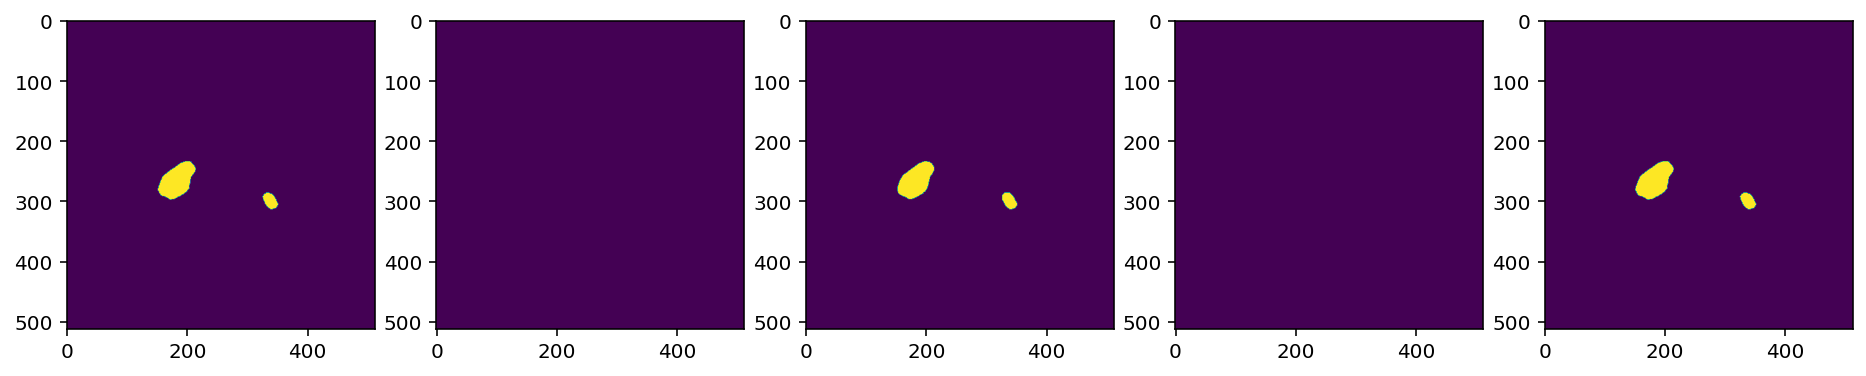

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.392112 	Validation Loss: 0.525852


  0%|          | 0/2240 [00:00<?, ?it/s]

0.960211549480573


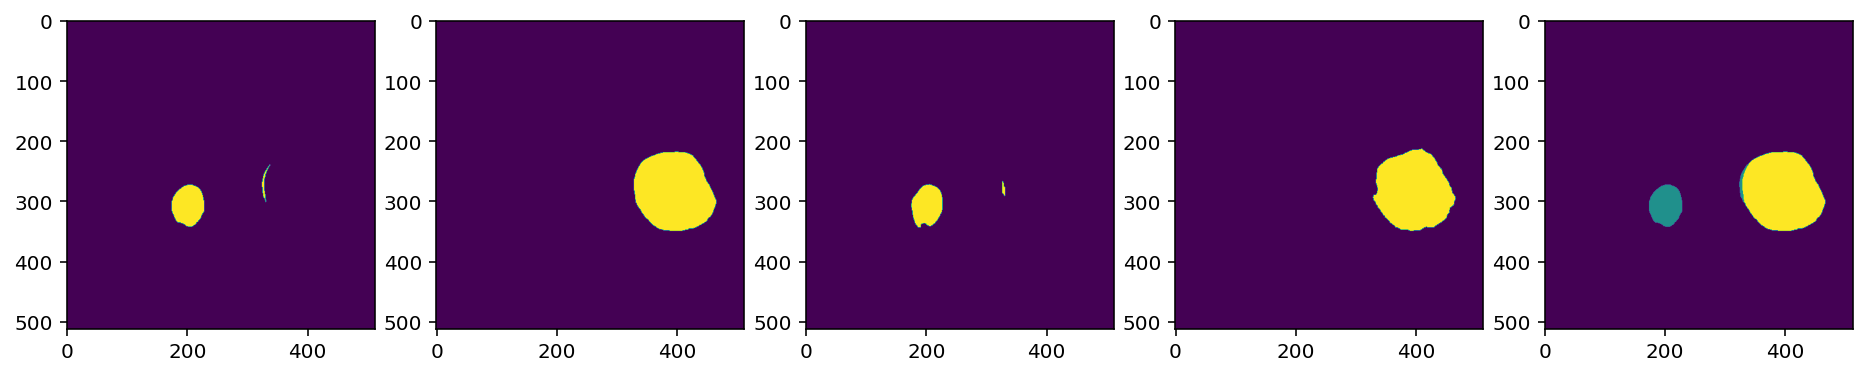

0.9614324242319394


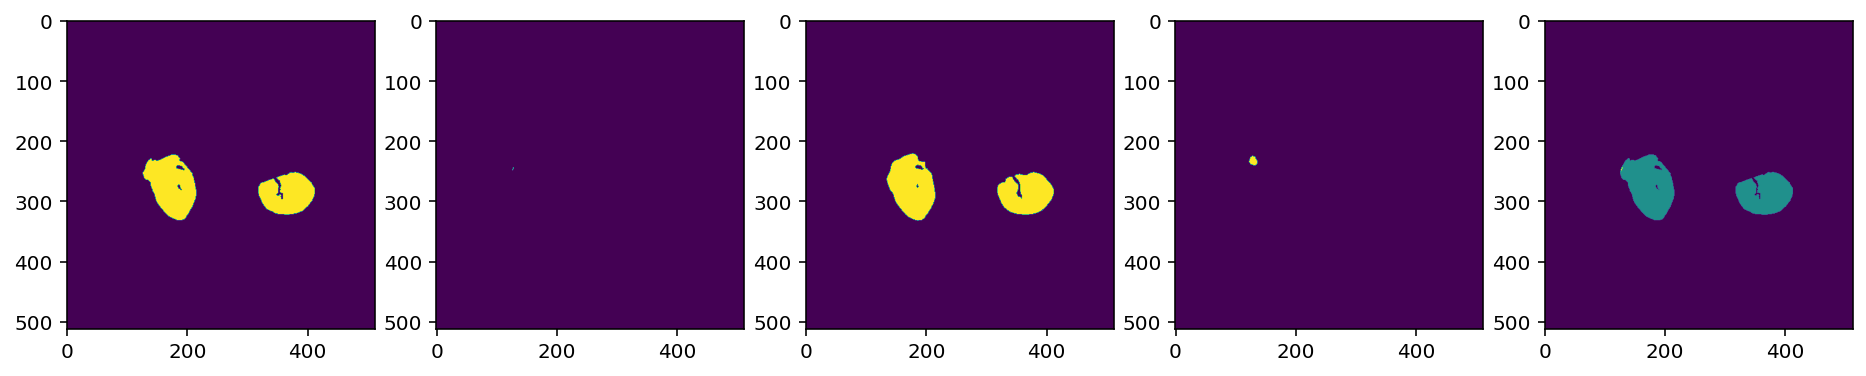

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.398261 	Validation Loss: 0.526924


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9694055284189316


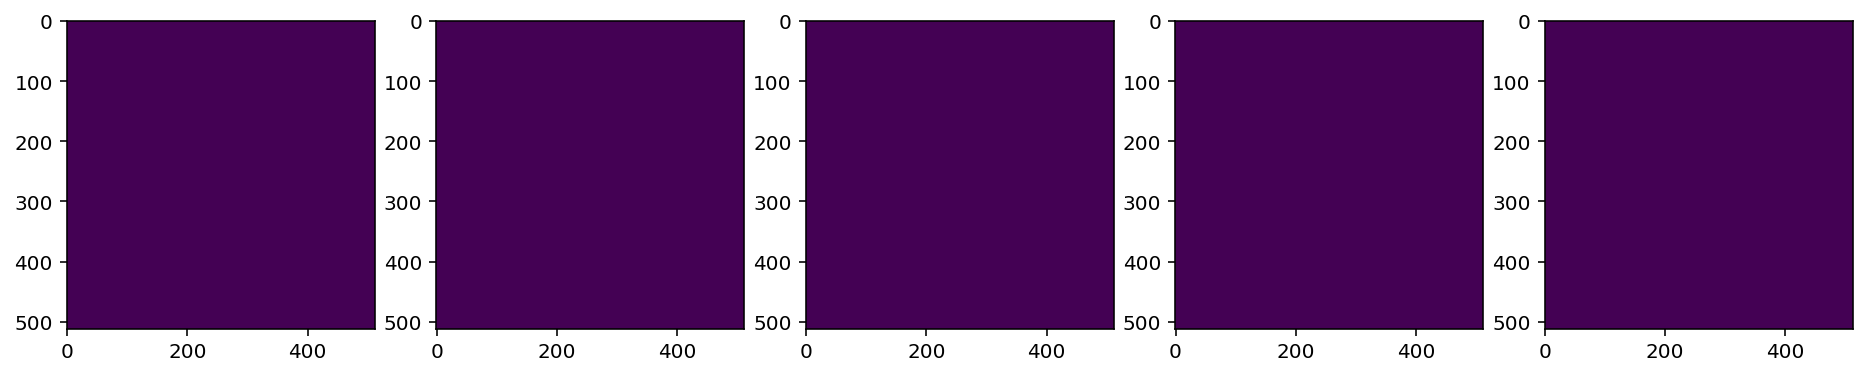

0.9687072528975226


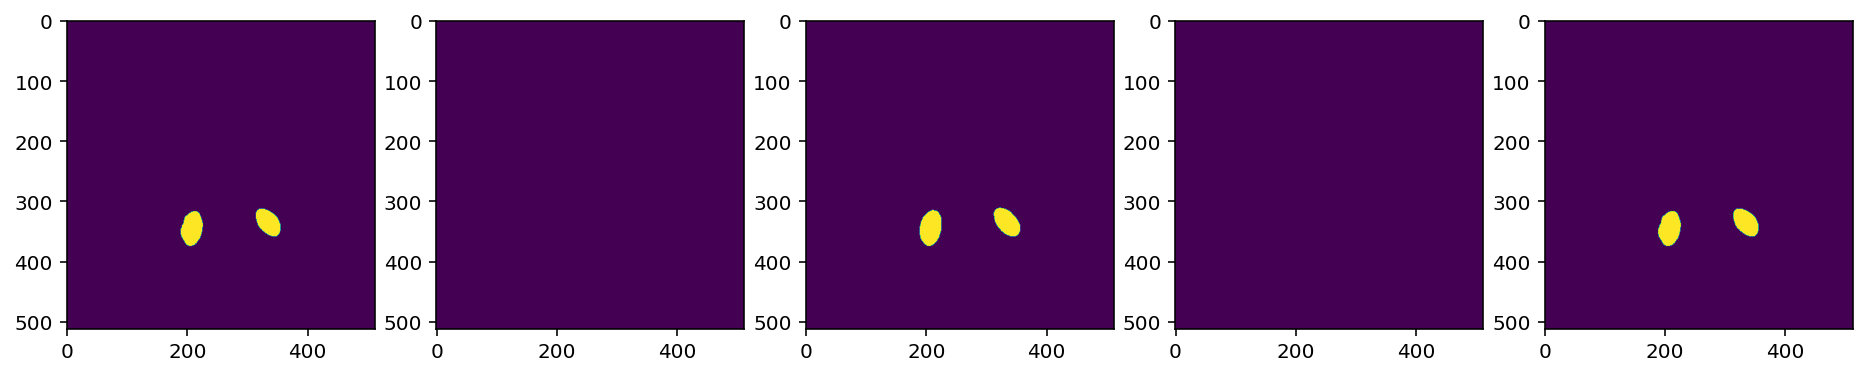

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.396330 	Validation Loss: 0.520215


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9763933703148235


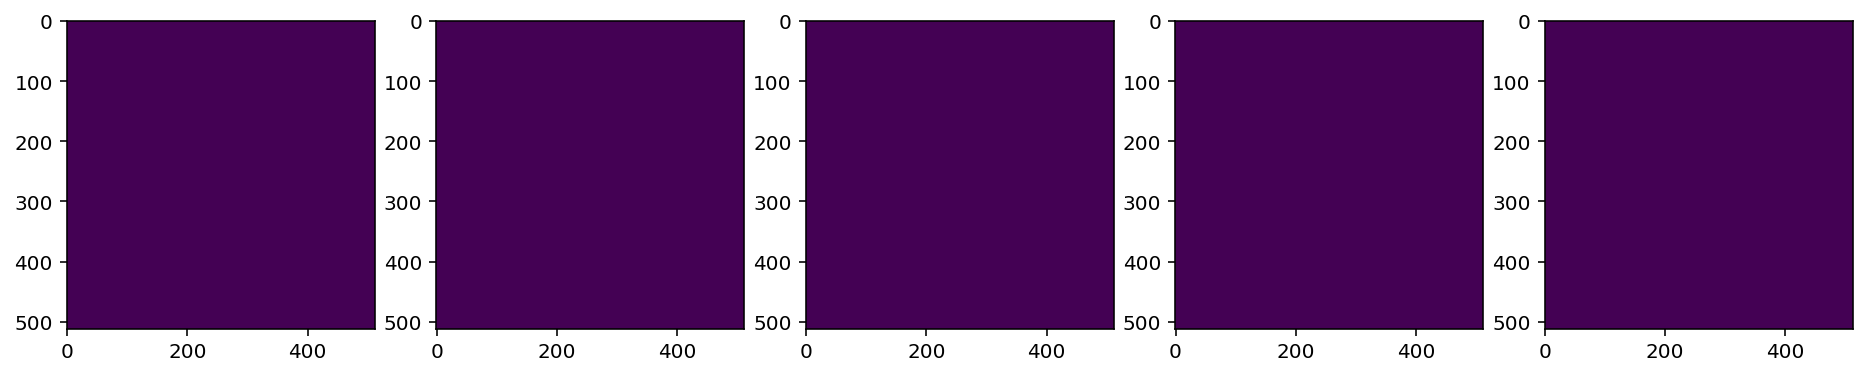

0.9695176767836755


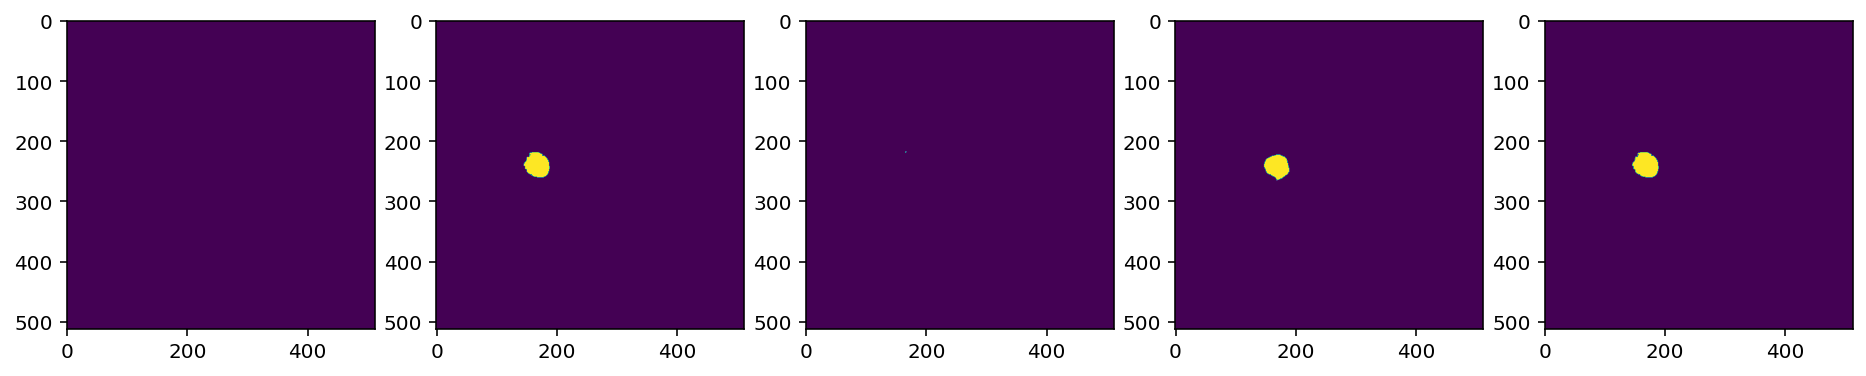

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.390120 	Validation Loss: 0.510618


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


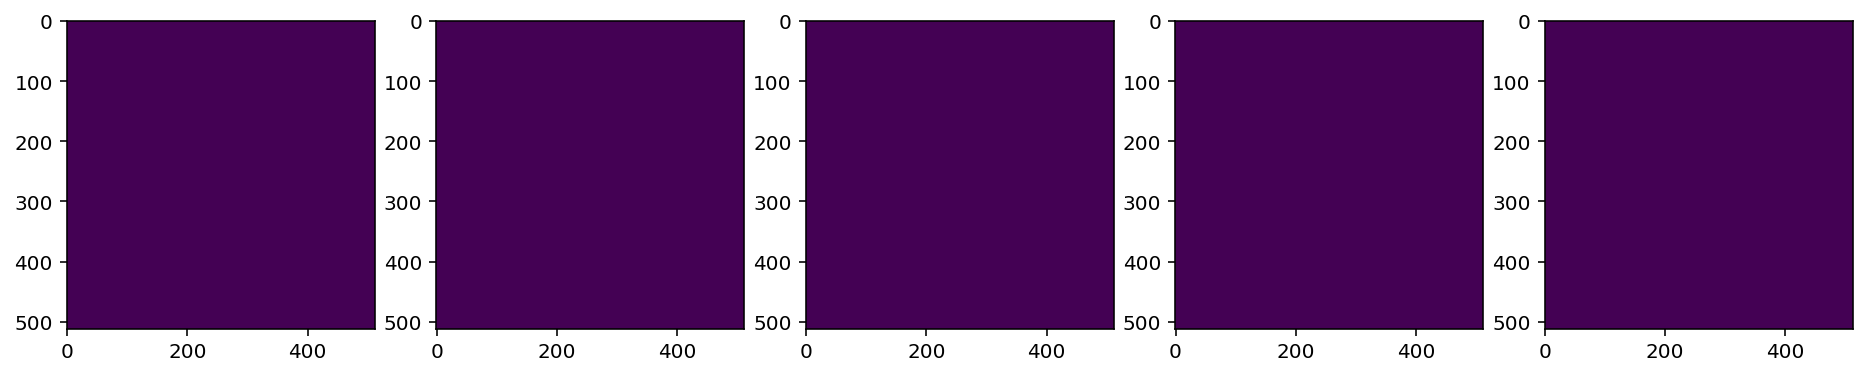

0.9804860950377681


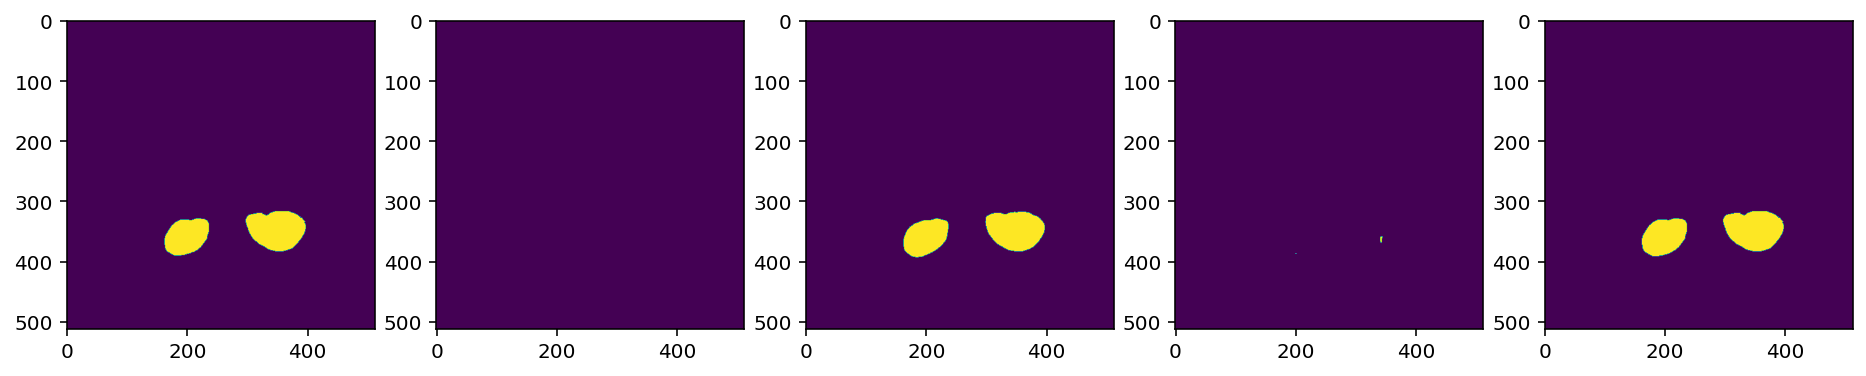

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.393021 	Validation Loss: 0.533208


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9717092101077662


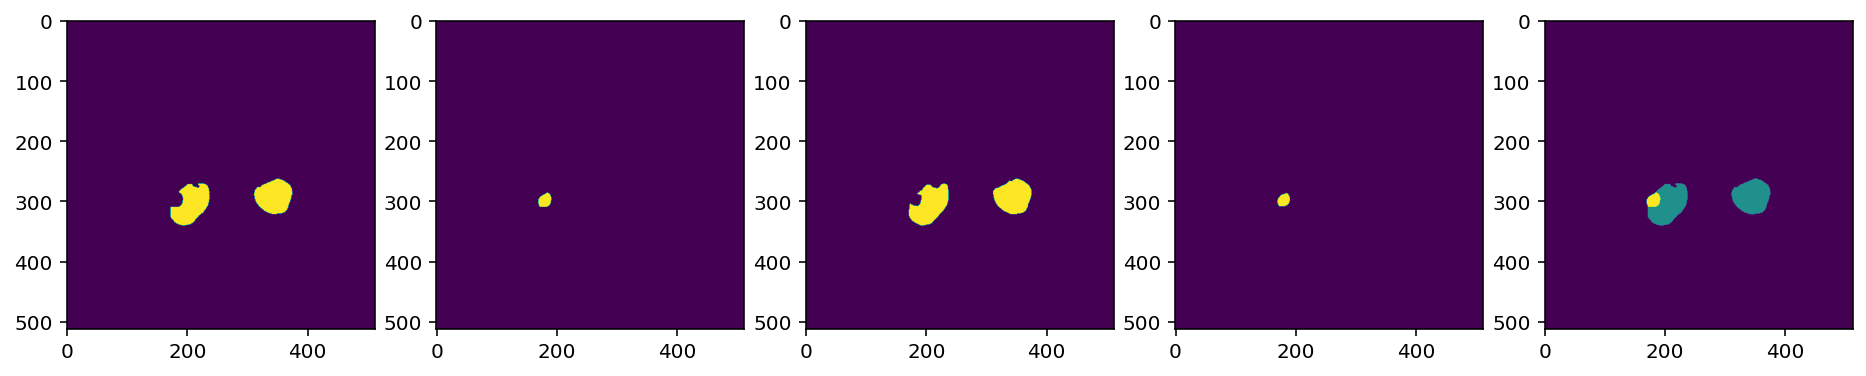

0.9747235469561473


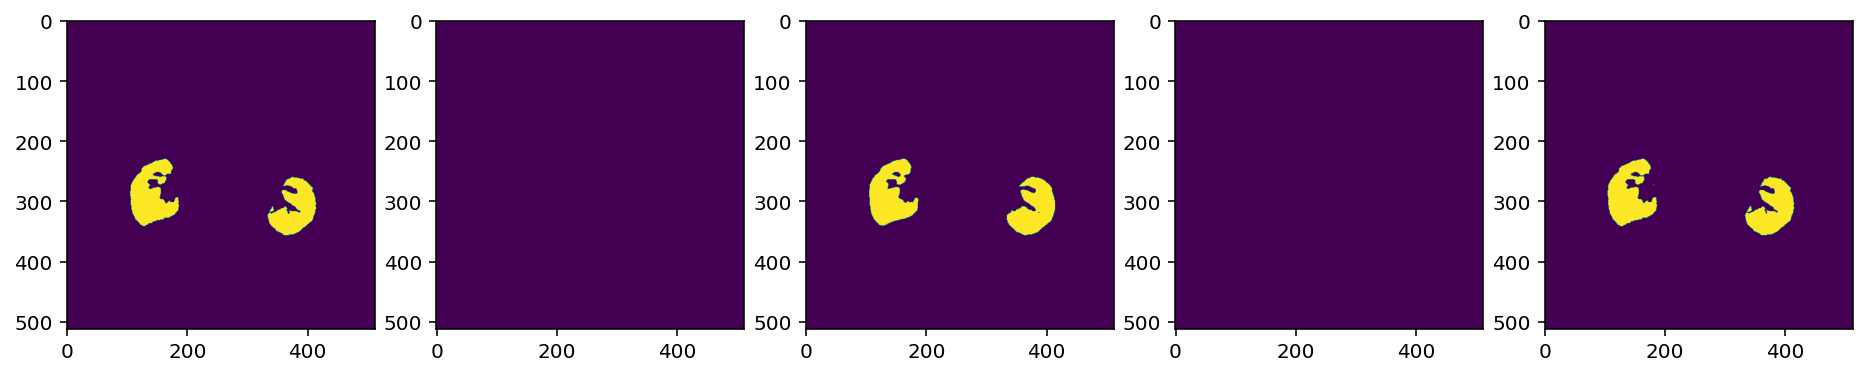

0.9618832714685128


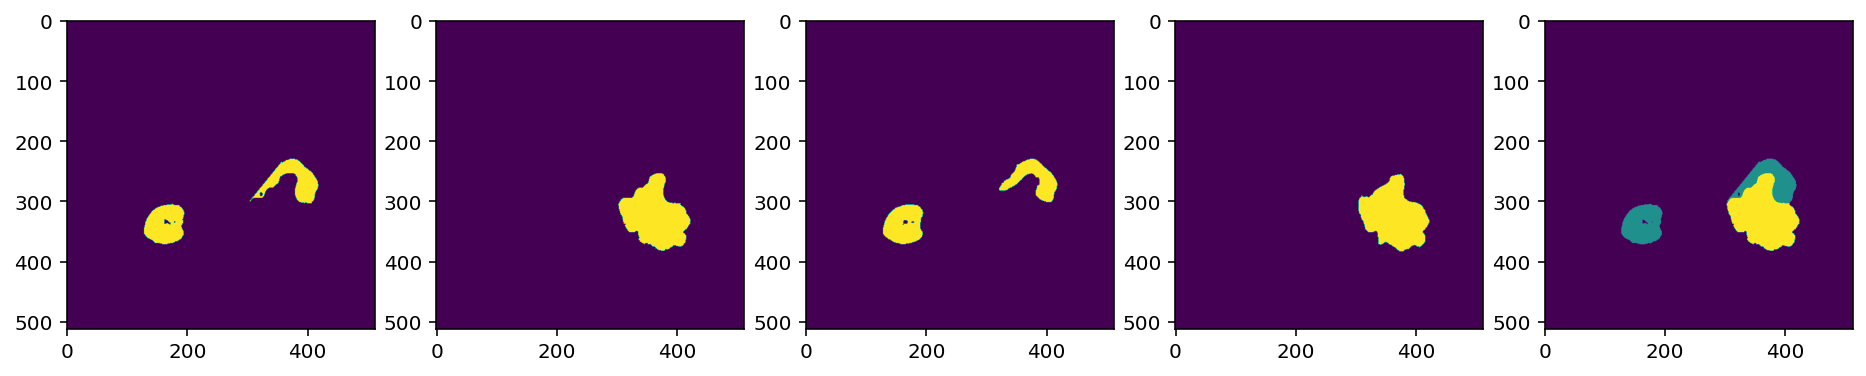

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.396547 	Validation Loss: 0.514221


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9595902414581645


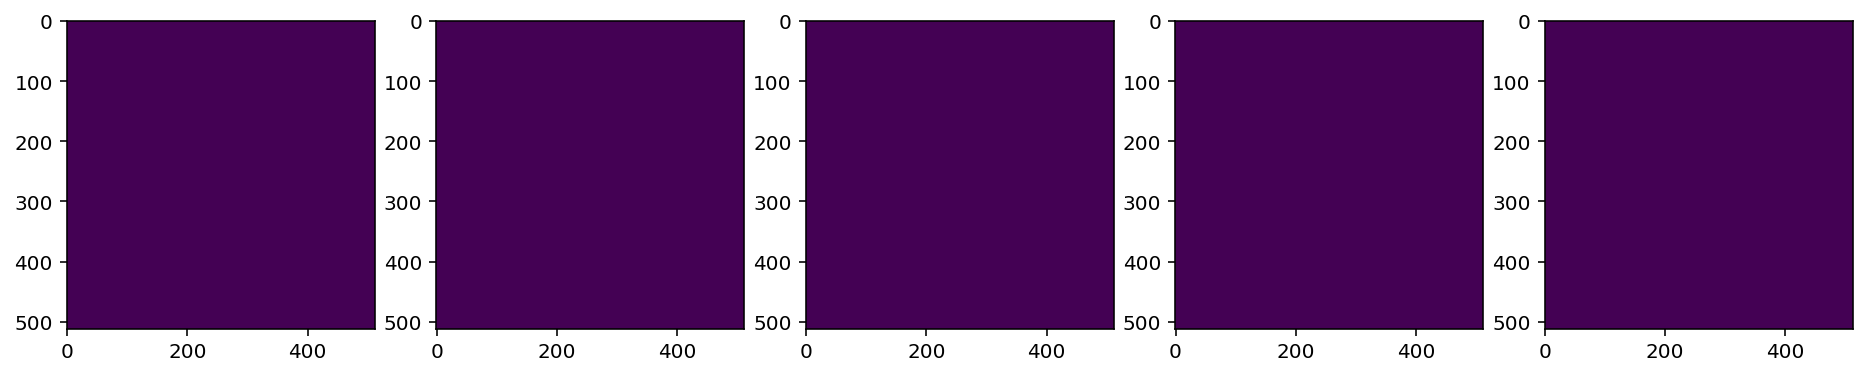

0.947086459758815


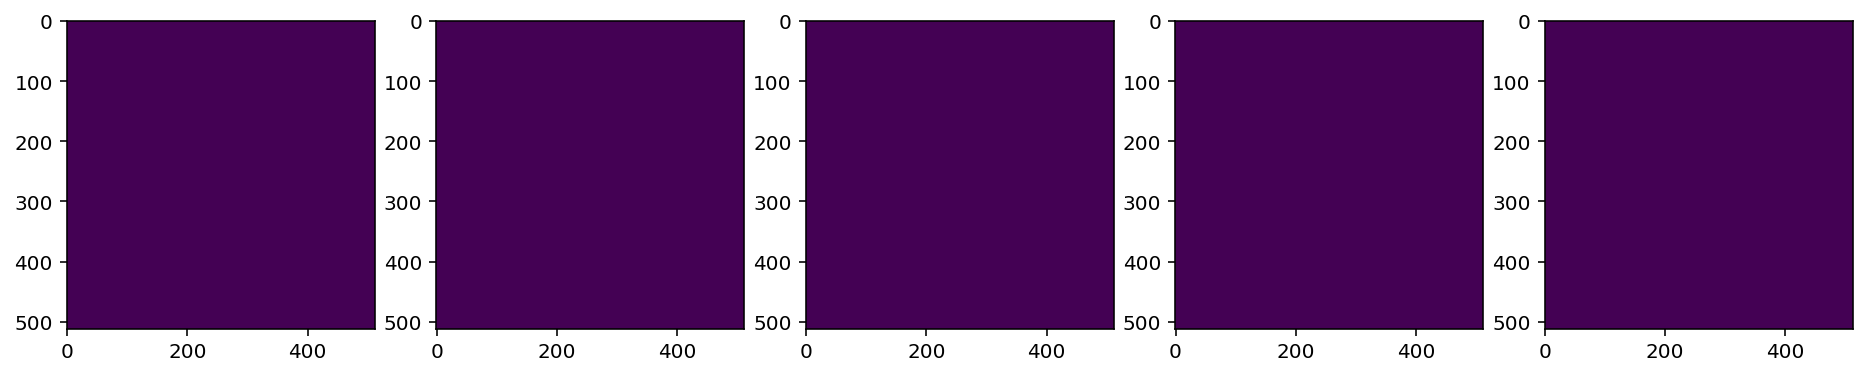

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.391301 	Validation Loss: 0.530935


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


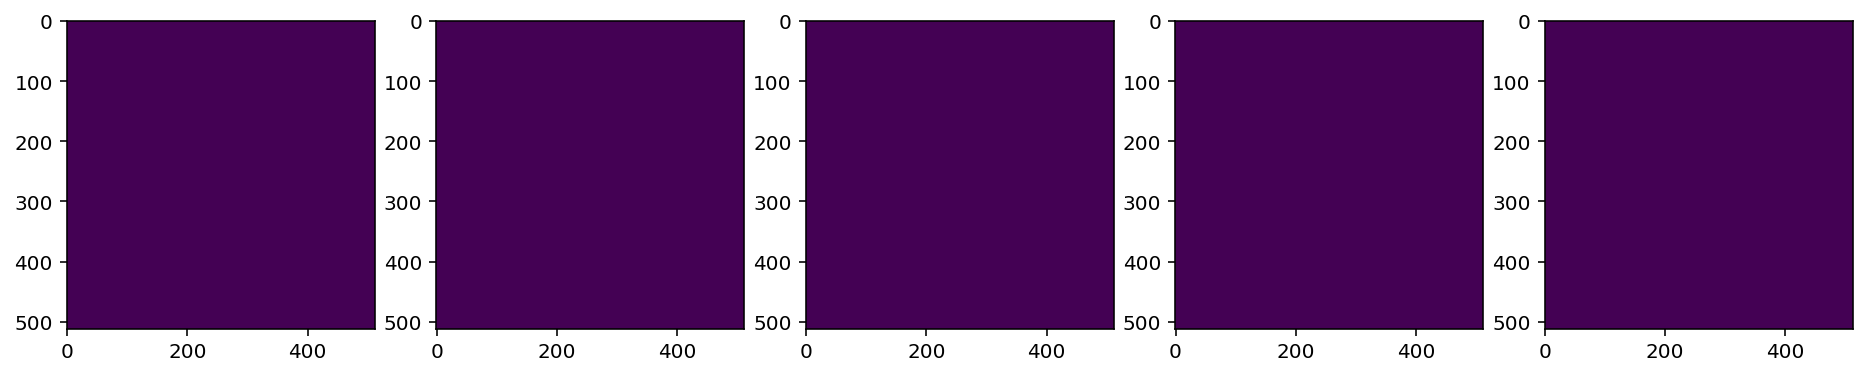

0.981469709242772


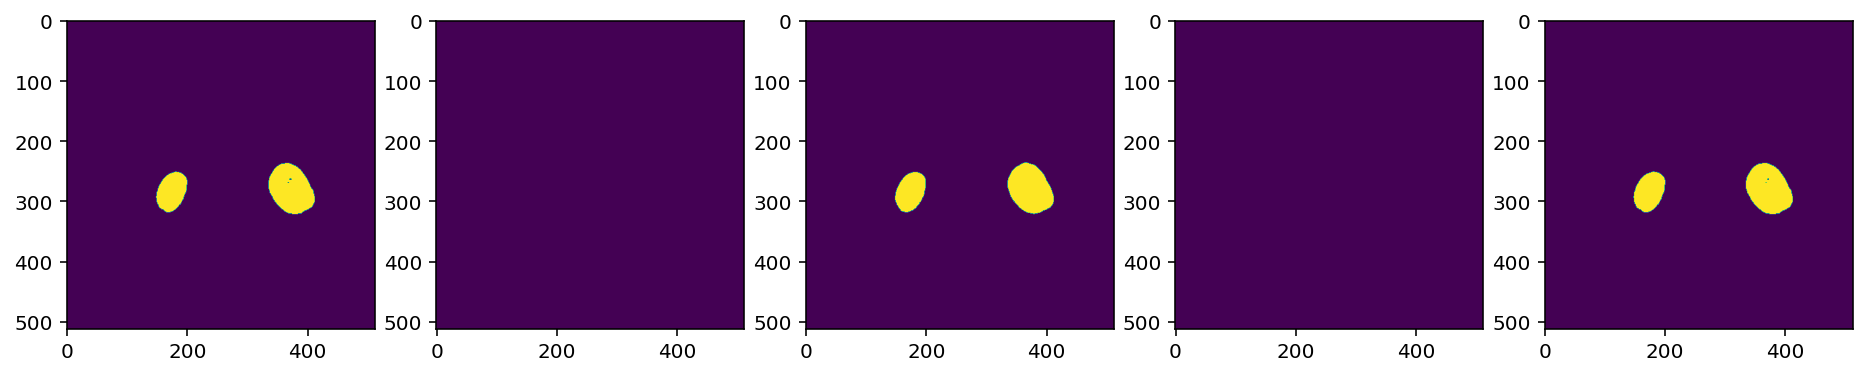

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.392657 	Validation Loss: 0.514228


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9784458594172372


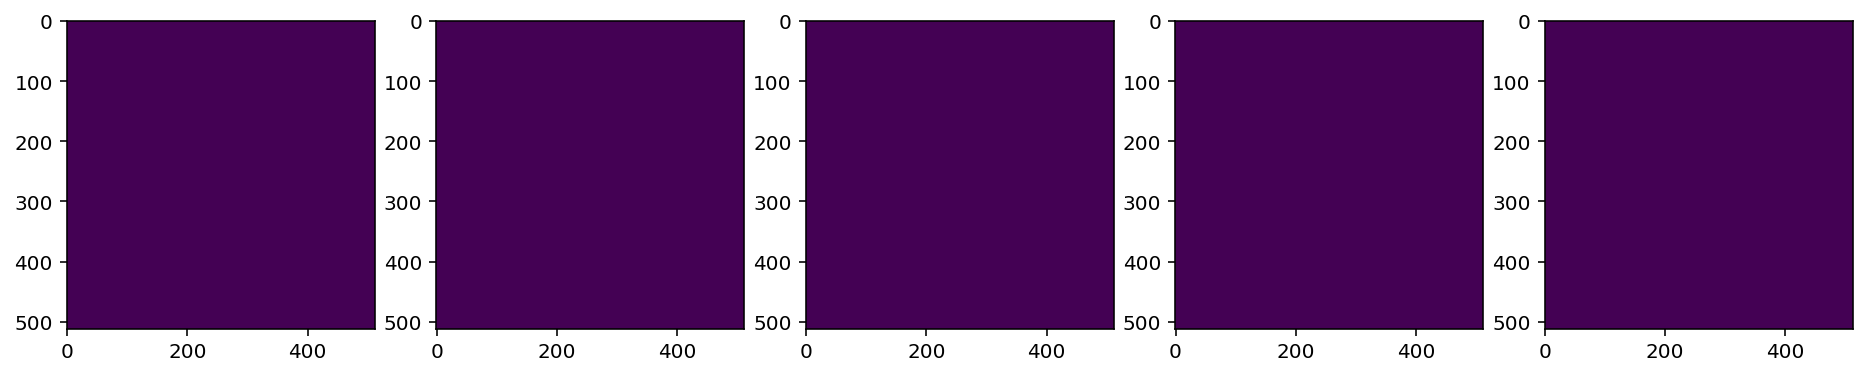

0.9807554189384327


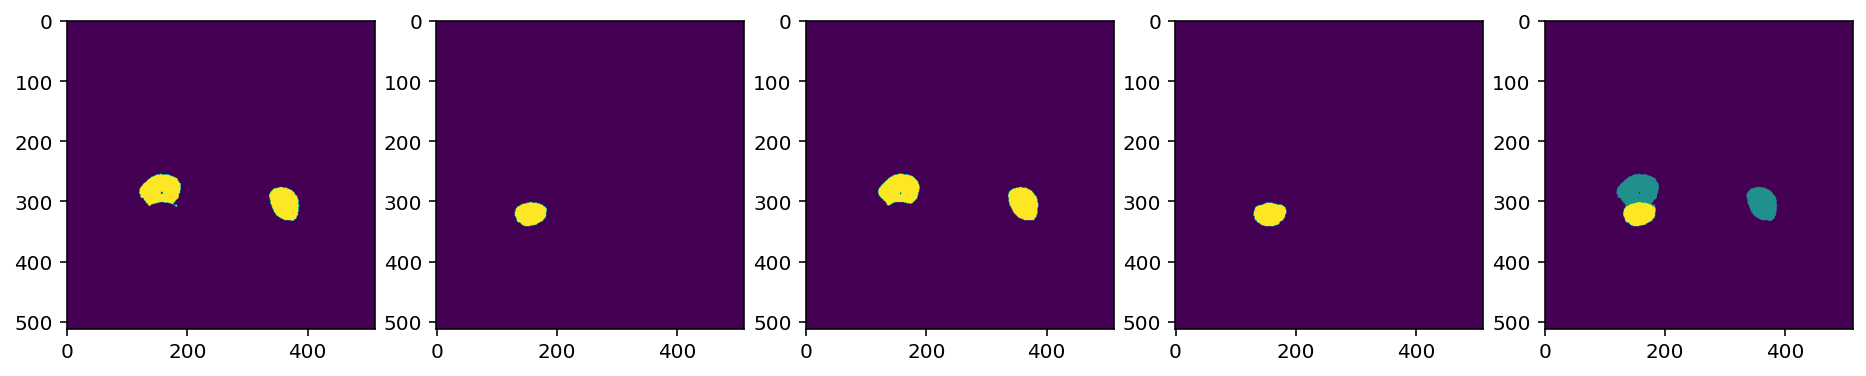

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.389858 	Validation Loss: 0.506068


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9696021120058388


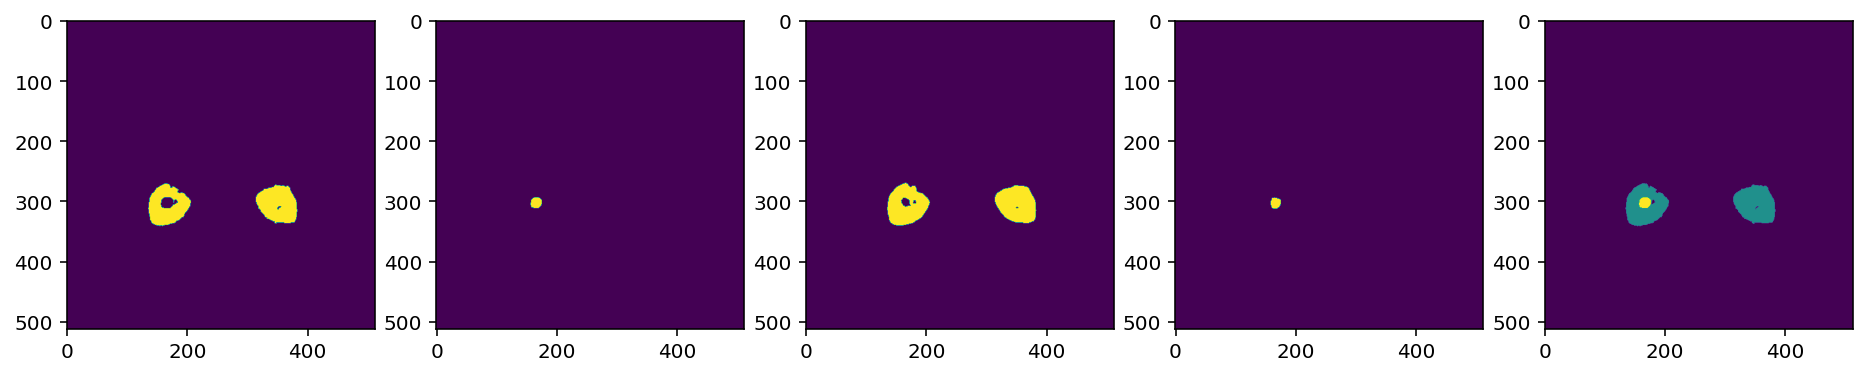

0.9421881698401289


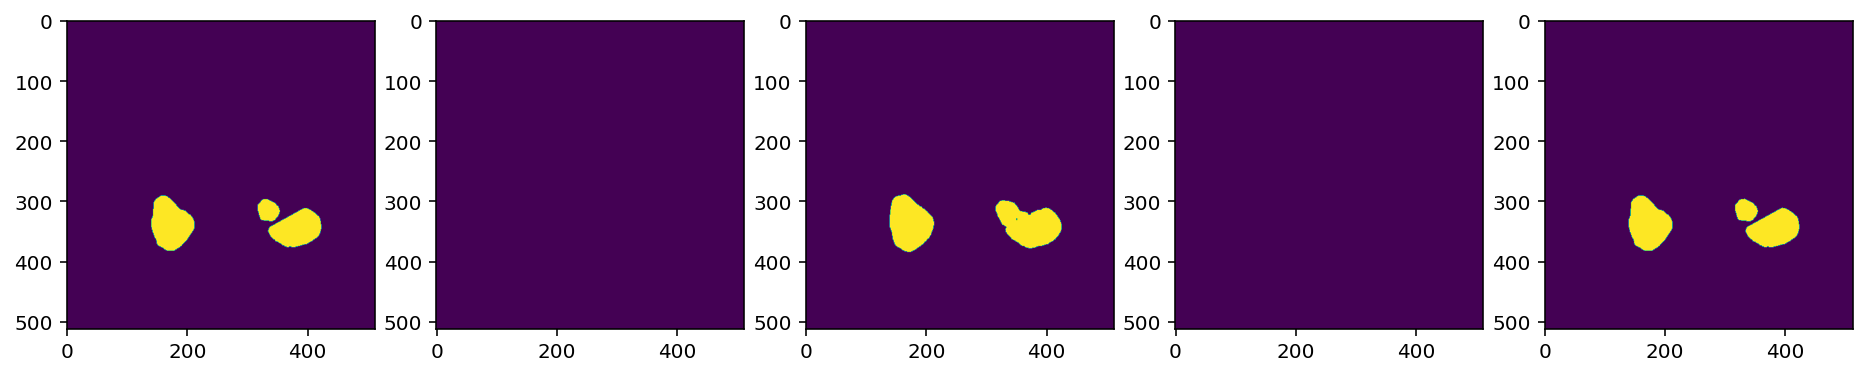

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


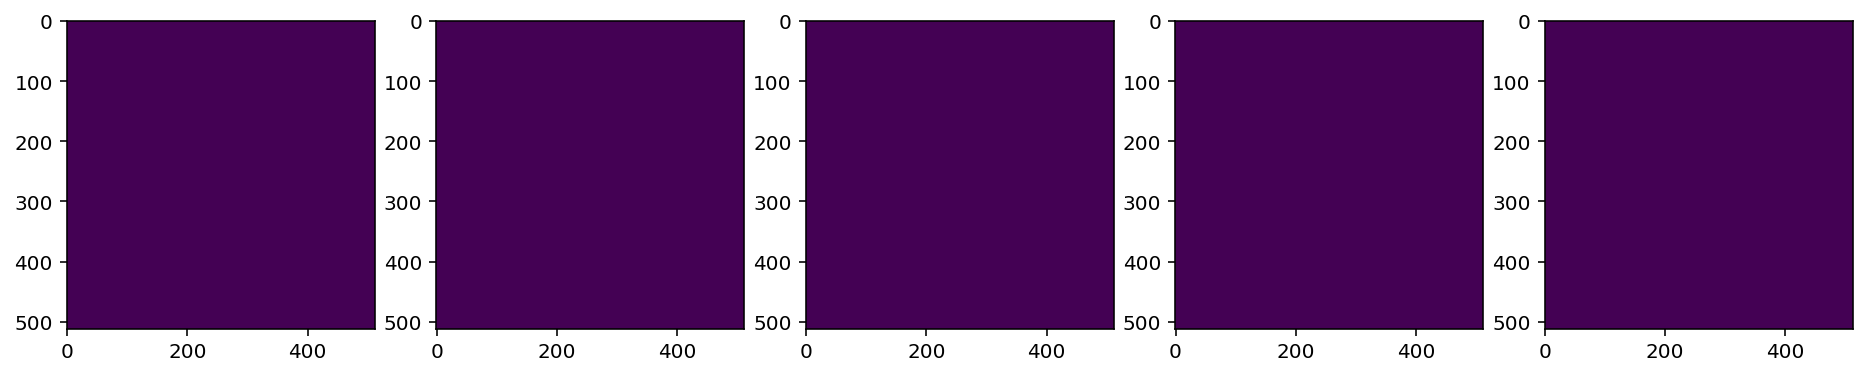

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.395239 	Validation Loss: 0.529602


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9361700764775267


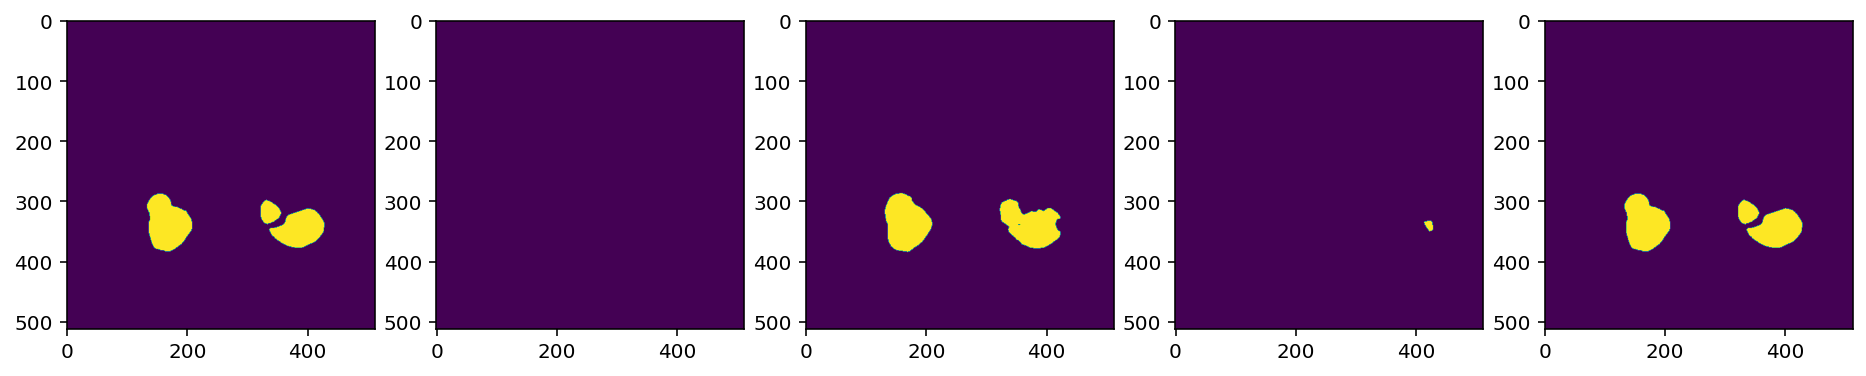

0.9850628677933583


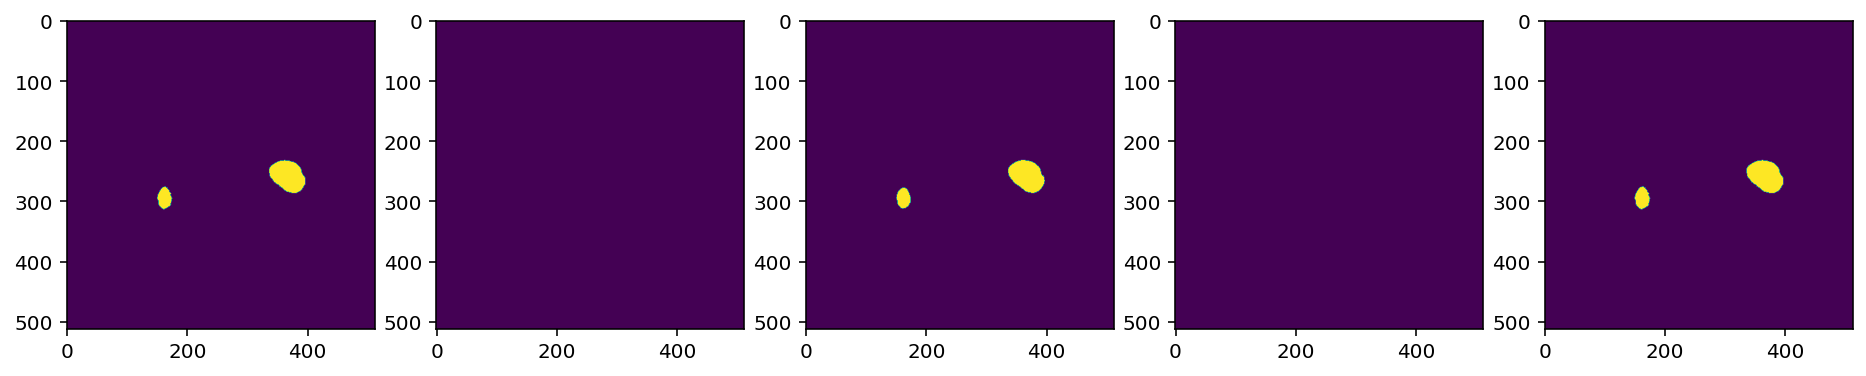

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.395292 	Validation Loss: 0.503888


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9716688410162326


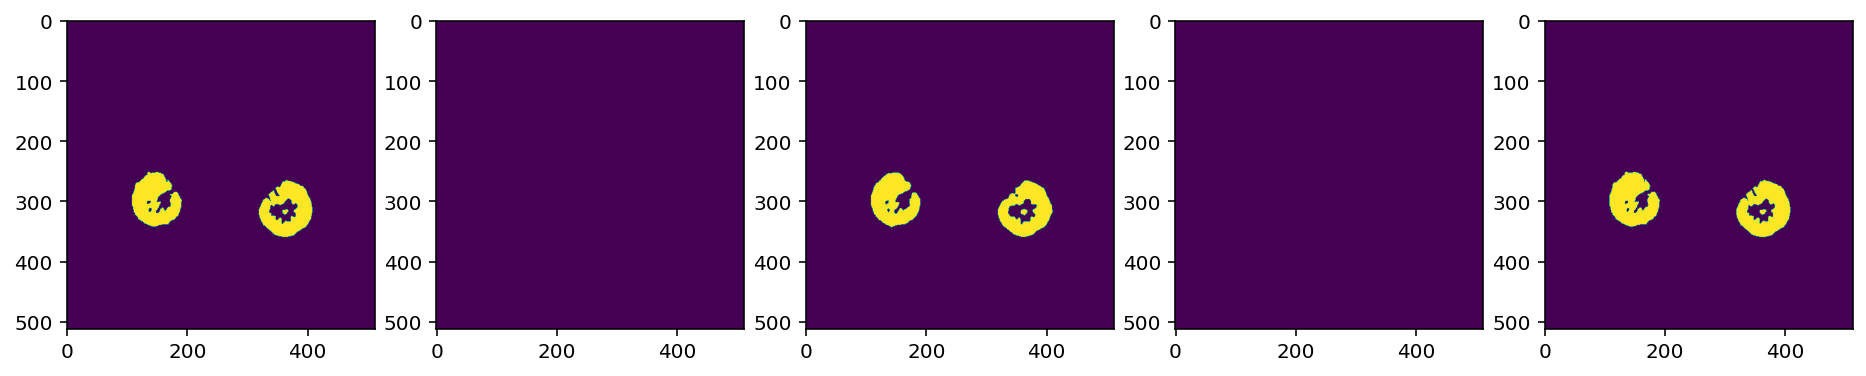

0.9809993501387261


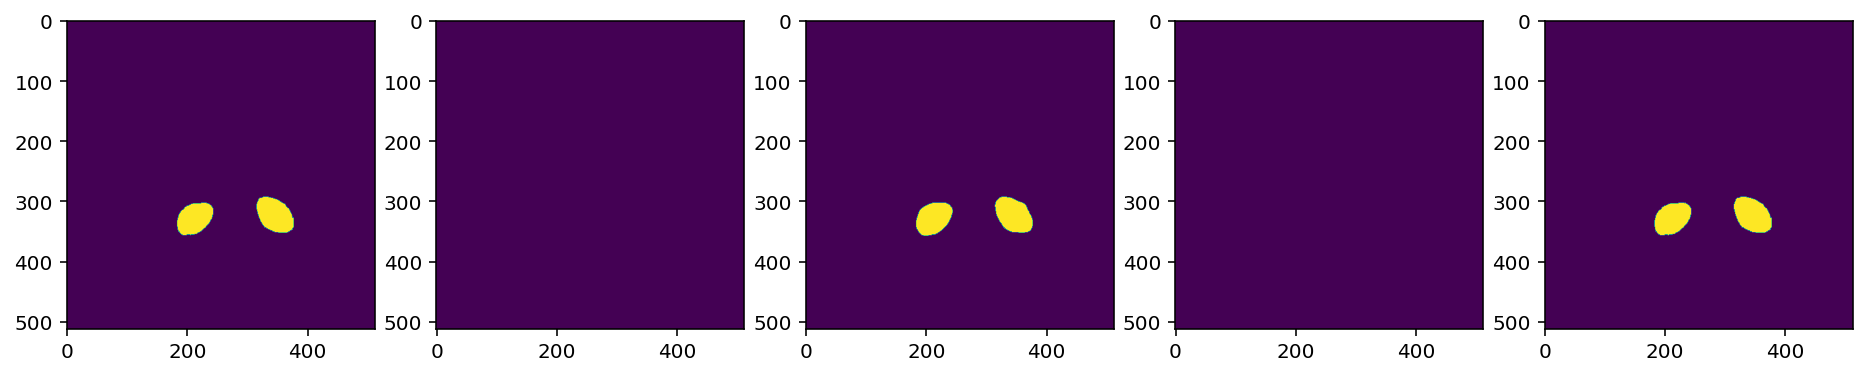

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.393287 	Validation Loss: 0.519936


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9796783489983163


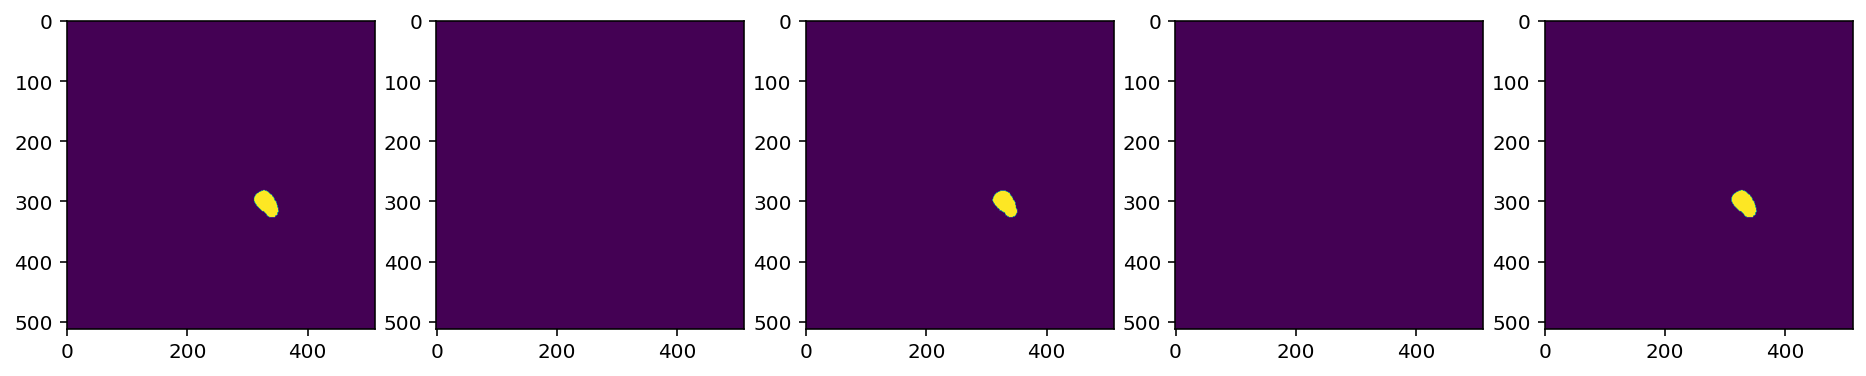

0.9853014155174588


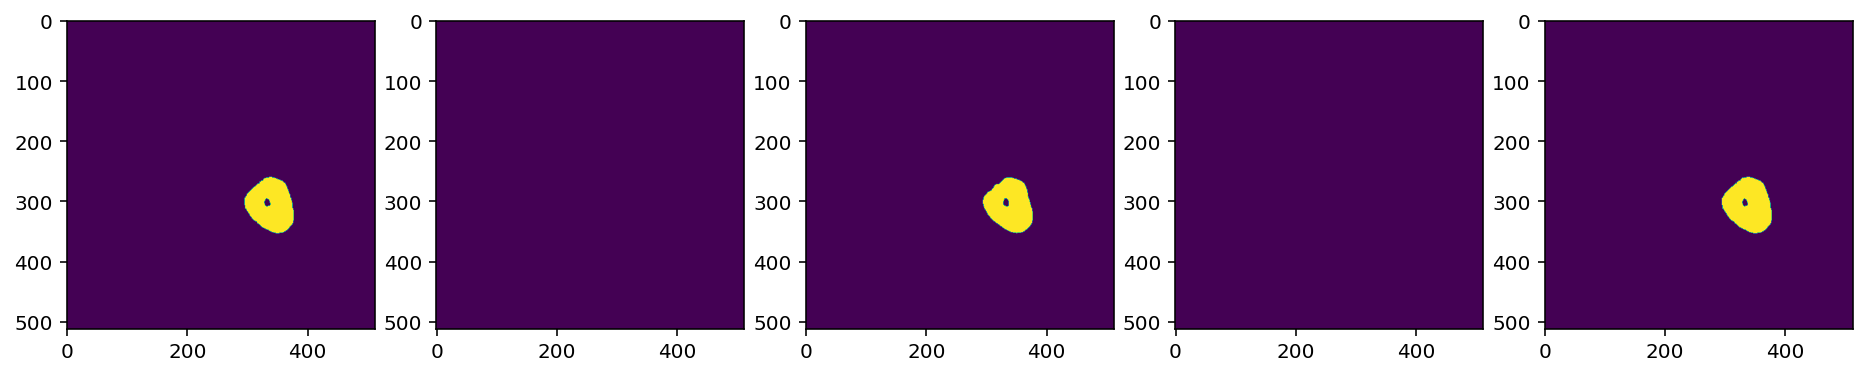

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.390669 	Validation Loss: 0.528341


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9701149949920455


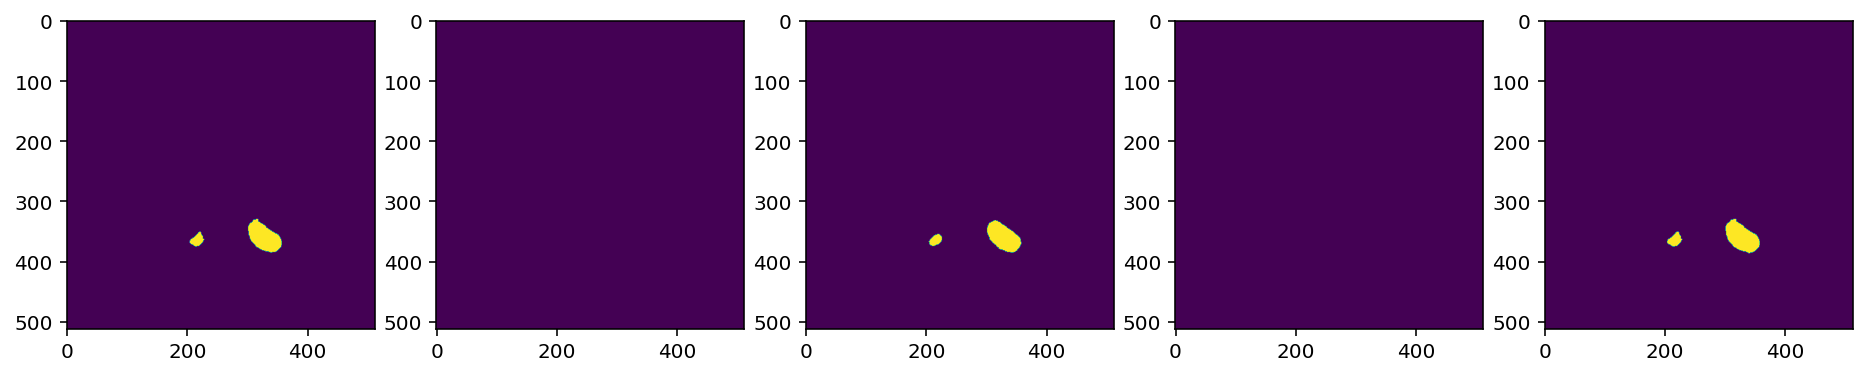

0.974025570629041


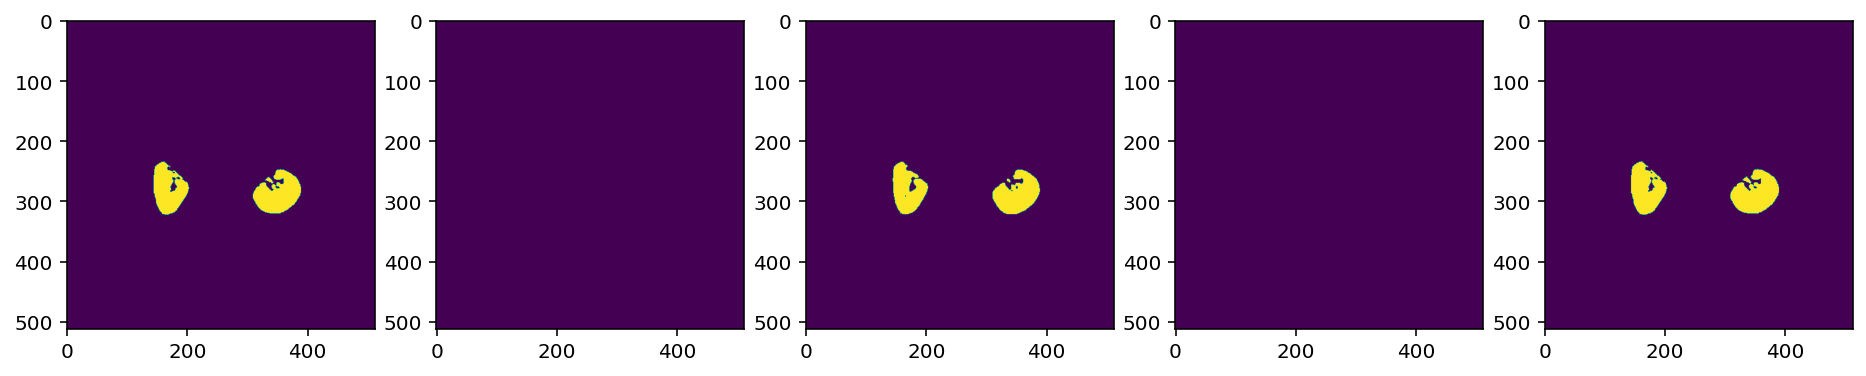

0.9853309198973352


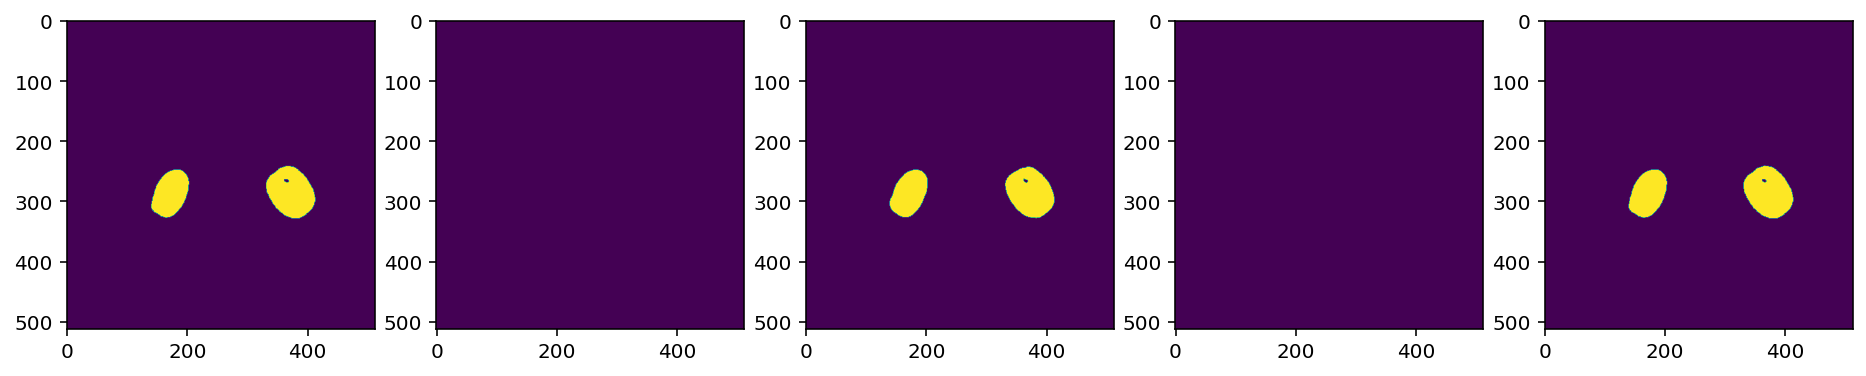

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.391932 	Validation Loss: 0.518116


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9531004966552326


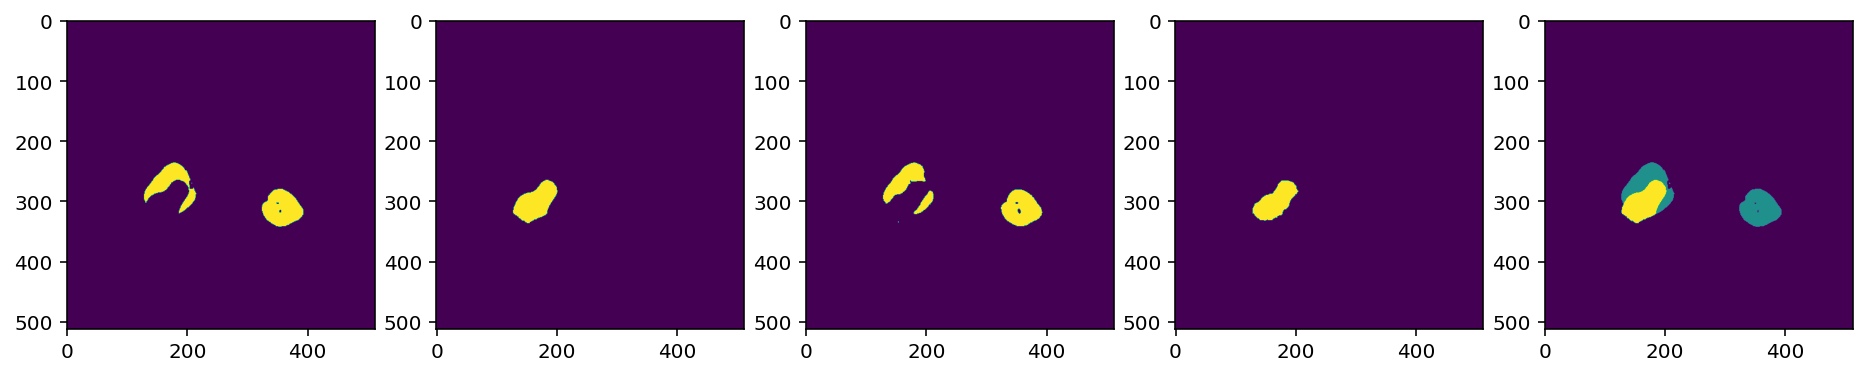

0.9852954150839377


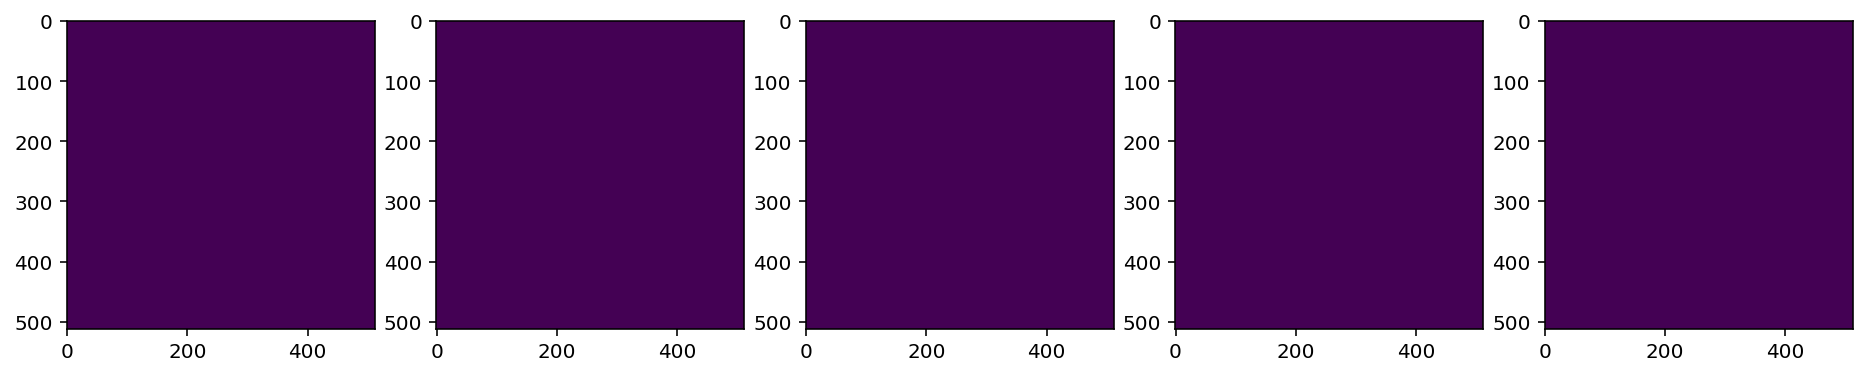

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.387555 	Validation Loss: 0.506812


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9605711382918618


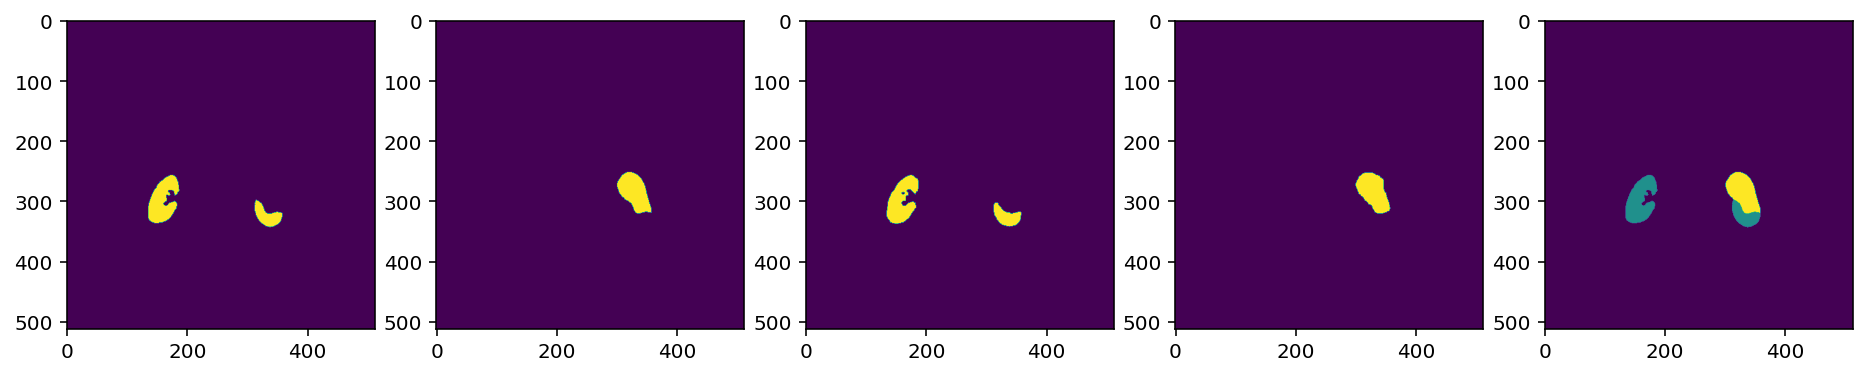

0.9835781455768478


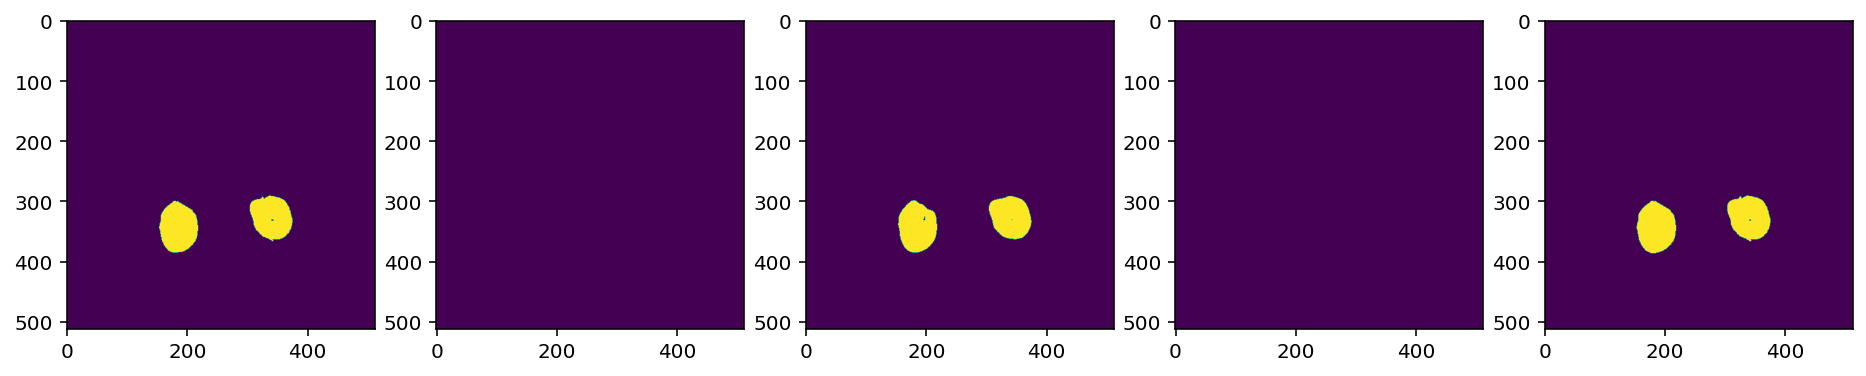

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.384699 	Validation Loss: 0.526571


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


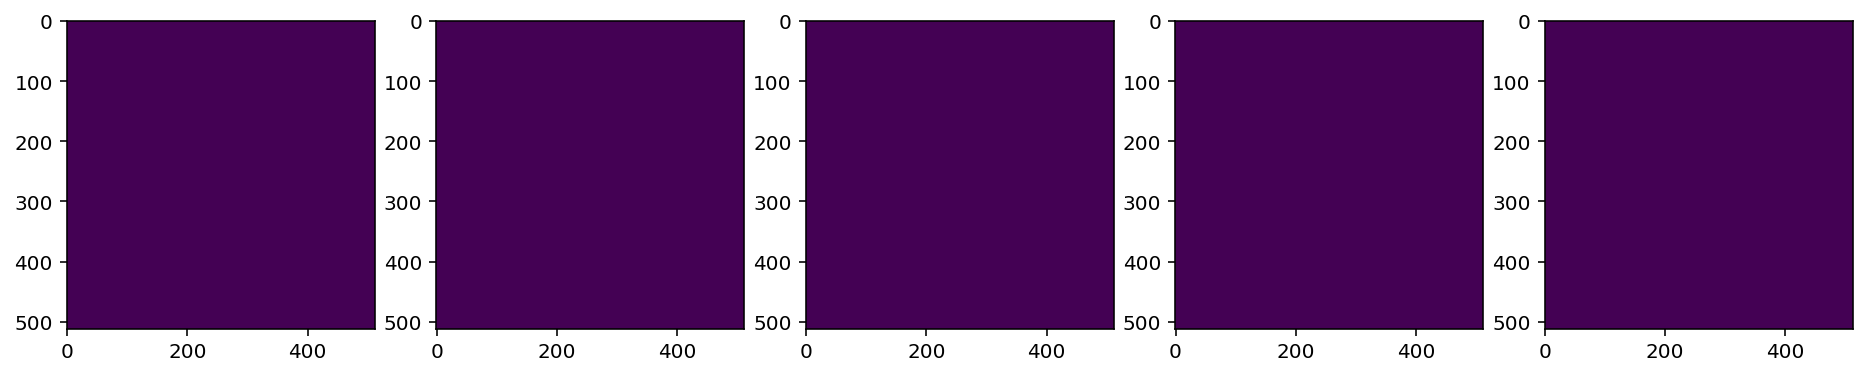

0.9628119278605203


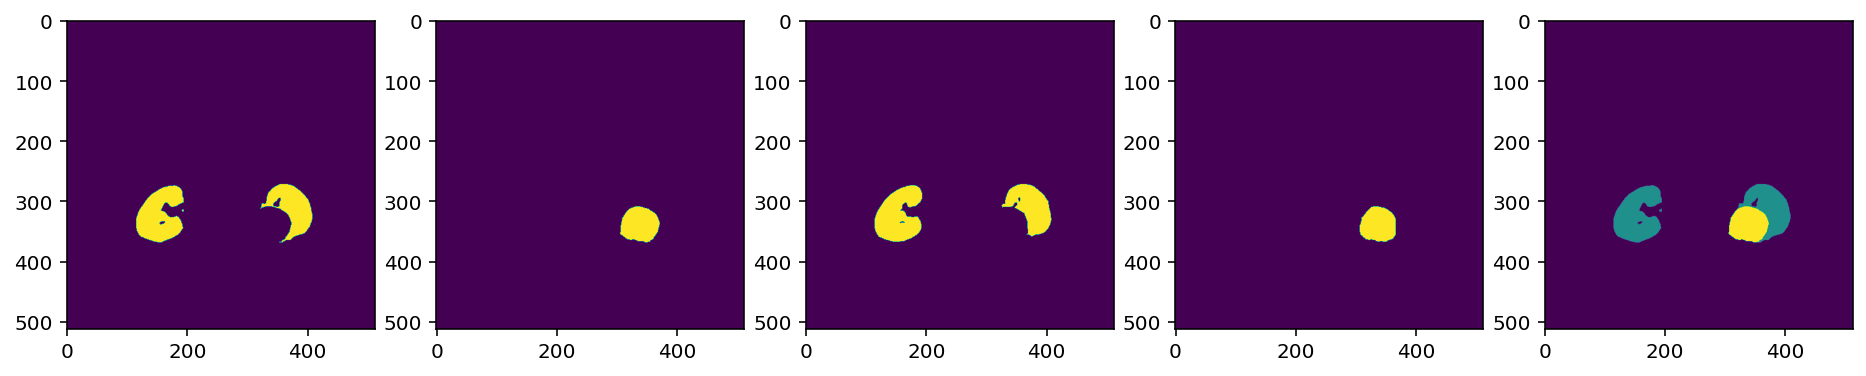

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.395349 	Validation Loss: 0.512765


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9809694552302721


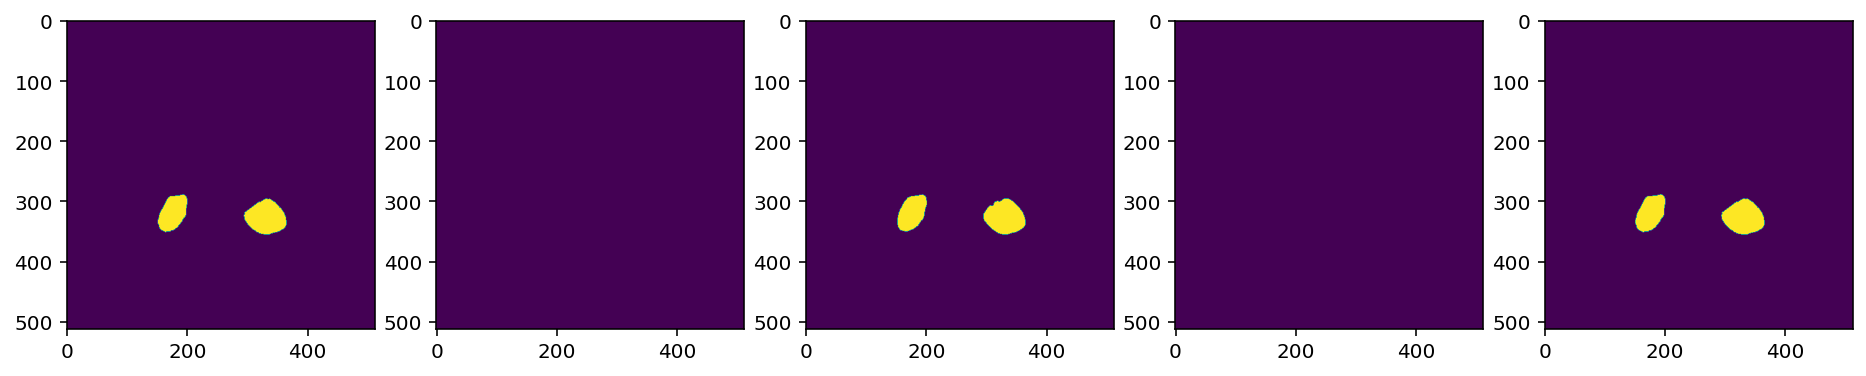

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


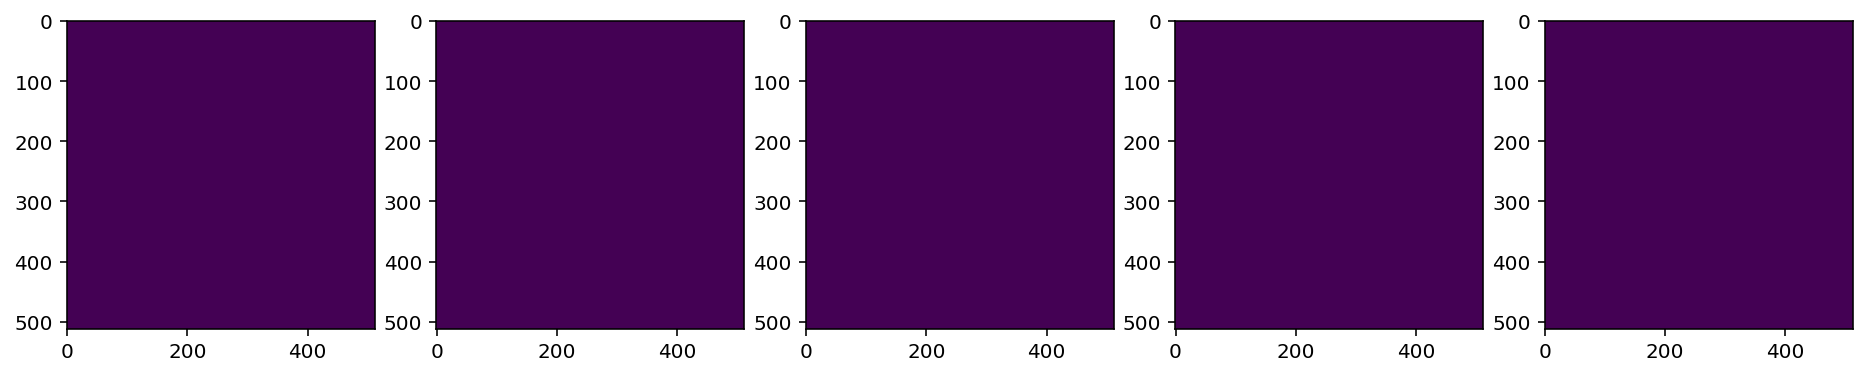

0.9829564456832536


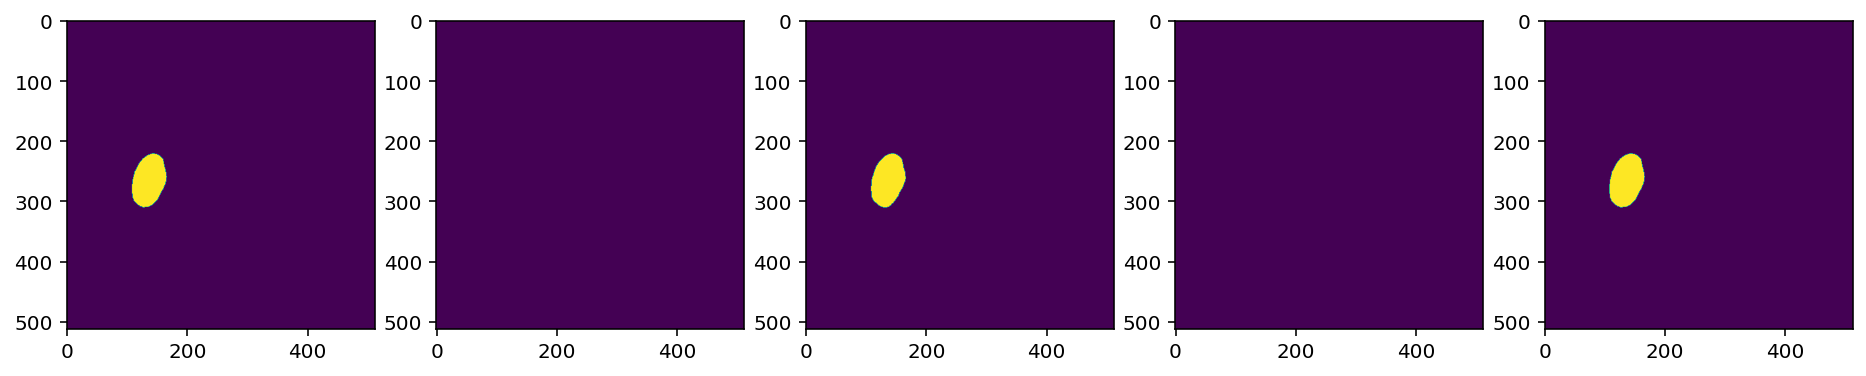

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.388612 	Validation Loss: 0.510873


  0%|          | 0/2240 [00:00<?, ?it/s]

0.945917088192792


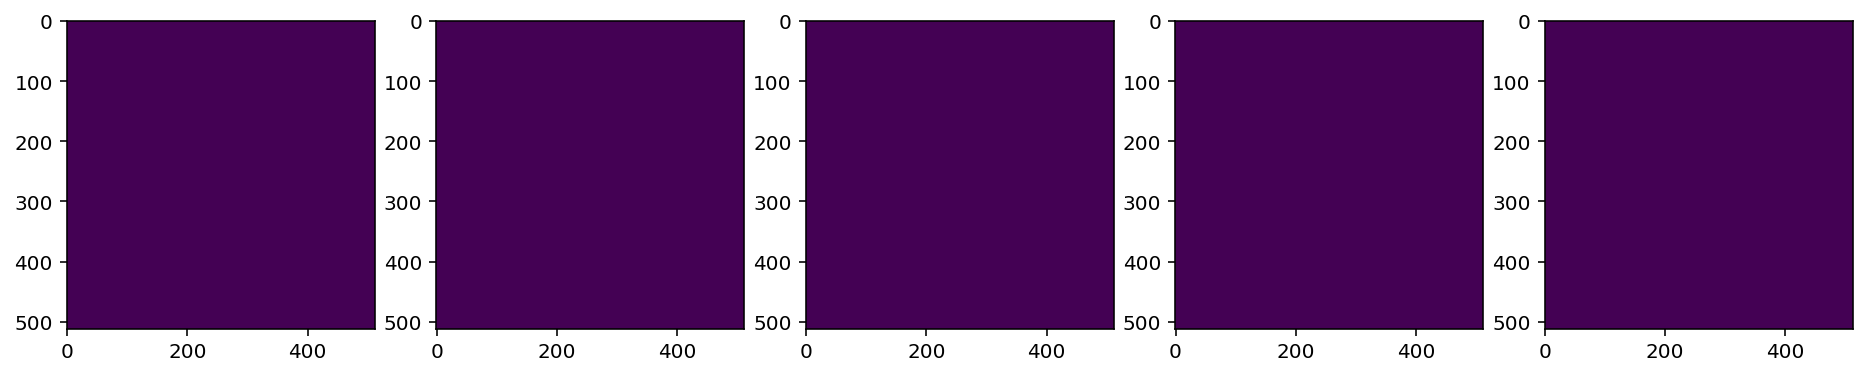

0.9673872697744015


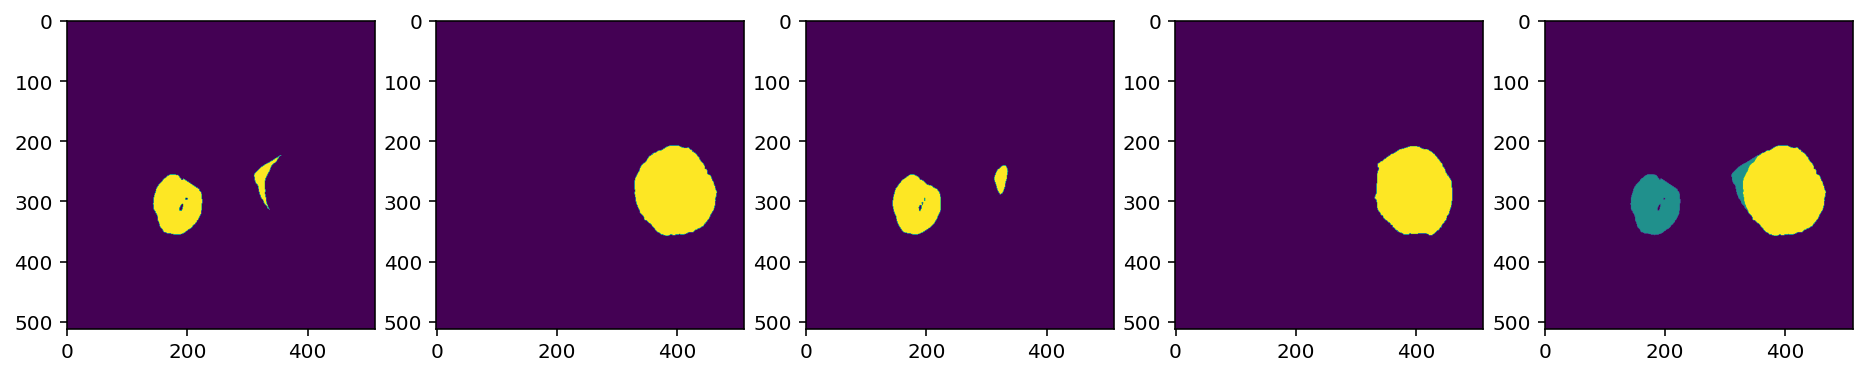

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.391324 	Validation Loss: 0.525489


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


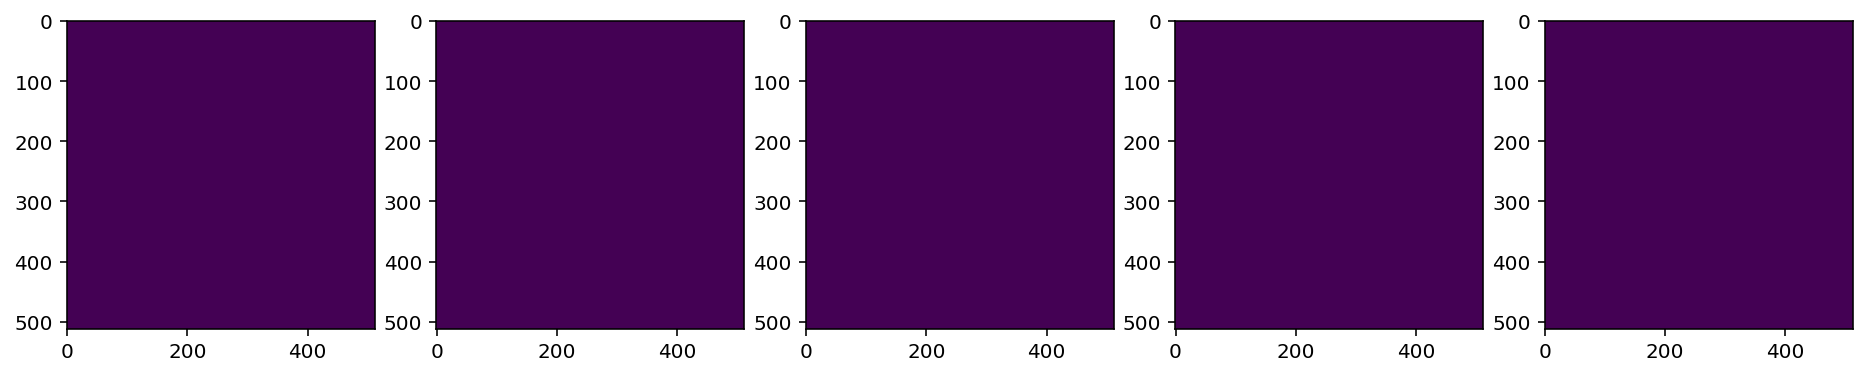

0.9700444782183109


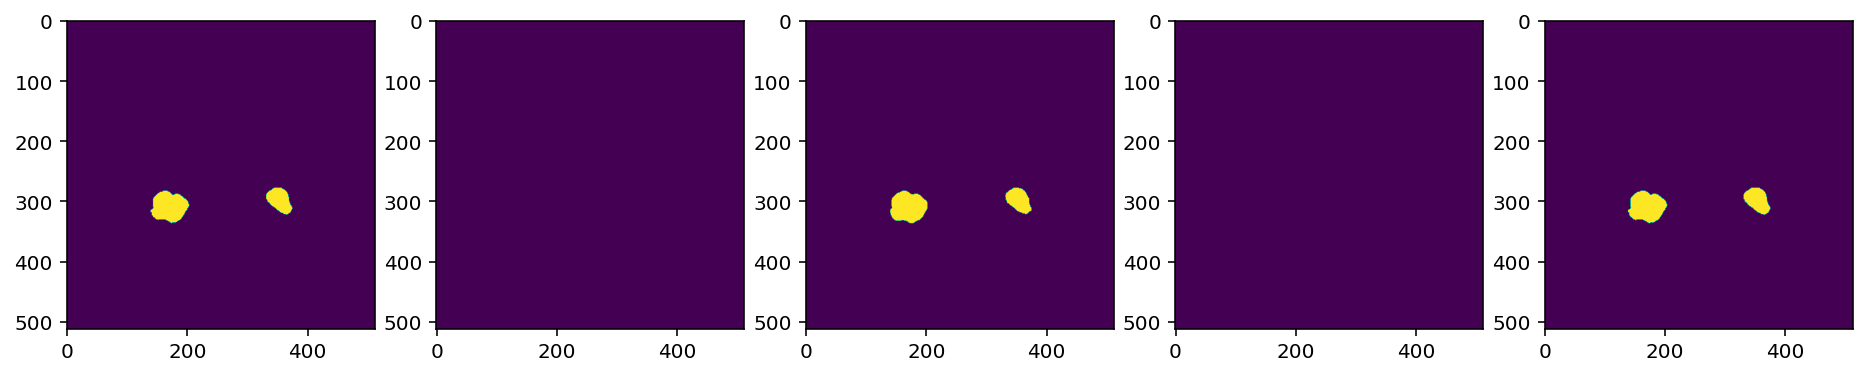

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.390252 	Validation Loss: 0.521877


In [ ]:
n_epochs = 100
cnt =0
valid_loss_min = np.inf  # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)
Iou=0
model.to(device)
for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels,a in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device) #cpu에 있는 데이터를 gpu에 보냄
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()

        cnt = cnt+1
        
        
        if cnt %1000==0:
            
            logits = logits.sigmoid()
            logits = mask_binarization(logits.detach().cpu(), 0.5)
            iou = compute_iou(logits,labels)
            print(iou)
            # y=torch.squeeze(labels[0])
            y=logits[0].detach().cpu().numpy()
            # x=data[0].detach().cpu().numpy()
            x=labels[0].detach().cpu().numpy()
            #y=labels[0].numpy()
            plt.figure(figsize=(16,18))
            plt.subplot(1,5,1)
            plt.imshow(x[0])
            plt.subplot(1,5,2)
            plt.imshow(x[1])
            plt.subplot(1,5,3)
            plt.imshow(y[0])
            plt.subplot(1,5,4)
            plt.imshow(y[1])
            plt.subplot(1,5,5)
            plt.imshow(a[0])
            plt.show()

    
    train_loss[e] /= len(train_loader)
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels,a in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    # scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'pretrainModel.pt')
        valid_loss_min = valid_loss[e]

In [ ]:
#Loss
plt.plot(train_loss)
plt.plot(valid_loss)

In [ ]:
model.load_state_dict(torch.load('pretrainModel.pt'))

<All keys matched successfully>

In [ ]:
len(test_loader)

640

torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])


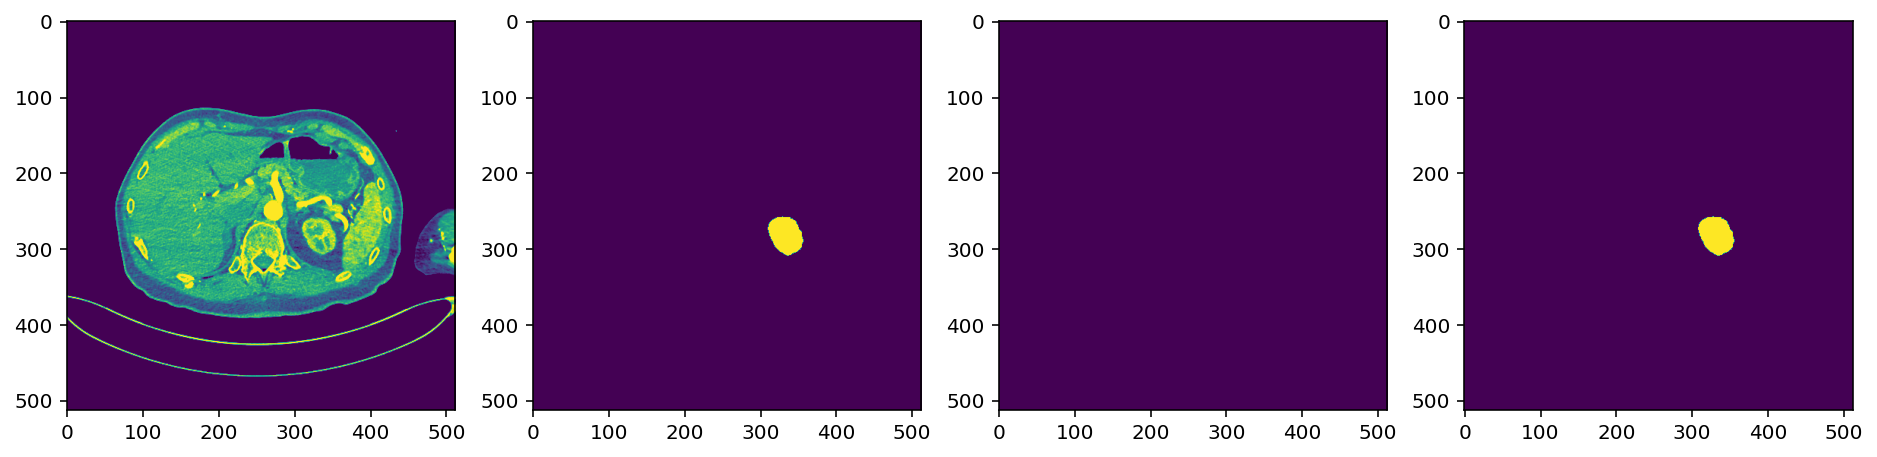

In [ ]:
images,labels,a = next(iter(test_loader))
print(images.shape)
print(labels.shape)
plt.figure(figsize=(16,18))
plt.subplot(1,4,1)
plt.imshow(images[0][0])
plt.subplot(1,4,2)
plt.imshow(labels[0][0])
plt.subplot(1,4,3)
plt.imshow(labels[0][1])
plt.subplot(1,4,4)
plt.imshow(a[0])
plt.show()

In [ ]:
len(test_loader)

640

In [ ]:
cnt =0
Iou=0
model.to(device)

with torch.no_grad(): 
        model.eval()
        for data, labels,a in tqdm(test_loader):
                data, labels = data.to(device), labels.to(device)
                # forward pass: compute predicted outputs by passing inputs to the model
                logits = model(data)
                logits = logits.sigmoid()
                logits = mask_binarization(logits.detach().cpu(), 0.5)
                iouu = compute_iou(logits,labels)
                iouu=np.round(iouu,3)*100
                if np.isnan(iouu)==True:
                    iouu=100
                Iou+=iouu

                labels=labels[0].detach().cpu().numpy()
                logits=logits[0].detach().cpu().numpy()
                cnt = cnt+1

print("Iou:",Iou/len(test_loader))



  0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encou

Iou: 88.98156250000001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
